# Introduction:
    This is a jupyter notebook which represents an academic research which was made as part of Data-Science Course.
    
The participants of the research are:
<br>
1. Amit Matalon (<a href="https://www.linkedin.com/in/amit-matalon/">Linkedin</a>)
2. Tomer Berkovich (<a href="https://www.linkedin.com/in/tomer-berkovich-496089230/">Linkedin</a>)
3. Aviv Aharon

# Mission #1 - Pre-Crawling Investigation:
    Before we have started the research, we had to take a look at the website and do some investigation..
    This investigation led us to the development tactic we needed in order to accomplish the mission.

# Mission #2 - Crawling:
    This part of the notebook shows the code of the crawling mission from the research sources.
    All the data of the research has been taken from the next sources:
    1. FlightRadar24
    2. Wikipedia
    
    The crawling involved inside the "selelnium" and "bs4" python modules.
    In order to get a data of the whole last year, we had to create a subscription account which allows us to get the data.
    In addition, in order to avoid block from the website we used time.sleep() in some places in the code.
    The crawling was challenging because of the following reasons:
    1. The website is dynamic, and so it's tables where the information is taken from.
    2. The website's anti DDOS attack mechanism
    3. The fact that each size of the web browser leads to different webpage source code
    4. The face that the website have a bug which happens when you want to see more data on specific airplane, but you've       already got all the data of the last year
    5. The HUGE amount of data which can be potentially collected from the website

In [1]:
###################
#                 #
#     Imports     #
#                 #
###################

from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from bs4 import BeautifulSoup
from datetime import datetime
from itertools import islice
# (Source: https://stackoverflow.com/a/57912823/2196301)
import chromedriver_binary  # Adds chromedriver binary to path
from os import listdir
import requests as req
import pandas as pd
import selenium
import platform
import pathlib
import logging
import ctypes
import time
import bs4
import os

###################
#                 #
#    Constants    #
#                 #
###################

FIRST_ELEMENT                     = 0
LAST_ELEMENT                      = -1
IS_LOGGED_IN                      = False
URL_OF_ALL_THE_AIRPLANES_TOGETHER = "https://www.flightradar24.com/data/aircraft/"
FLIGHTRADAR_MAIN_URL              = "https://www.flightradar24.com"
USER_AGENT                        = { 'User-agent' : 'Mozilla/5.0' }

NOT_FOUND_ERROR_MESSAGE_1         = "Sorry, historical data for this aircraft is not available."
NOT_FOUND_ERROR_MESSAGE_2         = "Sorry, but we could not find data for specified flight"

POSSIBLE_NOT_FOUND_ERRORS         = [NOT_FOUND_ERROR_MESSAGE_1, NOT_FOUND_ERROR_MESSAGE_2]
FLIGHT_RECORDS_TYPES_TO_REMOVE    = ( 'Unknown', 'Canceled', 'Scheduled', 'Diverted', 'Estimated', 'Delayed' )
COLUMNS_OF_RAW_DATAFRAME          = [ "Airline", "DateOfFlight", "Origin", "Destination", "FlightID", "FlightTime", "ScheduledTimeDeparture", "ActualTimeDepartue", "ScheduledTimeArriavl", "Status", "LandingTime" ]

PATH_OF_CSV_FILES                 = ".\\outputs\\dataframes\\"
PATH_OF_FAILED_AIRPLANES          = ".\\outputs\\"
PATH_OF_GENERAL_OUTPUTS           = ".\\outputs\\"

###################
#                 #
#     Globals     #
#                 #
###################

### DEBUG COUNTERS - CHANGE THE VALUES HERE ACCORDING OF YOUR WISH ###
___DEBUG___NUMBER_OF_AIRCRAFT_FAMILIES_TO_HANDLE_THEIR_DATA     = None
___DEBUG___NUMBER_OF_AIRPLANES_TO_CHECK_THEIR_DATA_AVAILABILITY = None
___DEBUG___NUMBER_OF_AIRPLANES_CHUNKS_TO_CRAWL_DATA_FROM        = None
___DEBUG___NUMBER_OF_AIRPLANES_IN_CHUNK_TO_CRAWL_THEIR_DATA     = None
___DEBUG___NUMBER_OF_FLIGHTS_PER_AIRPLANE                       = None

In [2]:
###################
#                 #
#     Methods     #
#                 #
###################

In [3]:
def chunk(it, size):
    """
    Split the given iterative object(list, string, tuple) to evenly sized chunks
    (Source: https://stackoverflow.com/a/22045226/2196301)
    """

    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

In [4]:
def get_path_of_current_py_file():
    """
    get_path_of_current_py_file()

    Purpose:
        Get the path of the current python file

    Parameters:
        None

    Return Value:
        [str] path - The path of the python file
    """

    path = str(pathlib.Path().resolve())

    if platform.system() == "Windows":
        path += "\\"
    else:
        path += "/"

    return path

In [5]:
def print_all_object_attributes(object):
    """
    print_all_object_attributes()

    Purpose:
        Print all attributes names of a given object and the attributes values
        (Source: https://stackoverflow.com/a/53820171/2196301)

    Parameters:
        [object] object - The object which all his attributes should be printed

    Return Value:
        None
    """
    
    for attributeName in dir(object):
        attributeData = getattr(object, attributeName)
        print(f"[{attributeName}] --> {attributeData}")

    return

In [6]:
def show_messagebox(text, title):
    """
    show_messagebox()

    Purpose:
        Print all attributes names of a given object and the attributes values
        (Source: https://stackoverflow.com/a/53820171/2196301)

    Parameters:
        [str] text  - The text of the messagebox
        [str] title - The title of the messagebox

    Return Value:
        None
    """

    # Source: https://stackoverflow.com/a/15275420/2196301
    ctypes.windll.user32.MessageBoxW(0, text, title, 1)
    return

In [7]:
def execute_automatic_login(driver):
    """
    execute_automatic_login()

    Purpose:
        Execute an automatically login to "FlightRadar24"

    Parameters:
        [selenium.webdriver.WebDriver] driver - The driver which points to the page where the login should be executed in.

    Return Value:
        None
    """

    global IS_LOGGED_IN

    if IS_LOGGED_IN == True:
        return    
    
    logger = logging.getLogger('selenium.webdriver.remote.remote_connection')
    logger.setLevel(logging.CRITICAL)

    print("[Crawling - Automatic Login] Logging in ...")
    driver.get("https://www.flightradar24.com/")
    driver.implicitly_wait(10)
    web = driver.find_elements(by=selenium.webdriver.common.by.By.CLASS_NAME, value='logout')[0]
    web.click() 

    emailField = driver.find_elements(by=selenium.webdriver.common.by.By.ID, value="fr24_SignInEmail")[0]
    emailField.send_keys("--> CENSORED <---")

    passwordField = driver.find_elements(by=selenium.webdriver.common.by.By.ID, value="fr24_SignInPassword")[0]
    passwordField.send_keys("--> CENSORED <---")

    passwordField.send_keys(Keys.ENTER)
    time.sleep(5)
    IS_LOGGED_IN = True

    return

In [8]:
def load_soup_object(url):
    """
    load_soup_object()

    Purpose:
        Create a BeautifulSoup object which allows to parse the given url.

    Parameters:
        [str] url - The url of the webpage which should be parsed with the BeautifulSoup object

    Return Value:
        [bs4.BeautifulSoup] souper - The BeautifulSoup object which allows to parse the given url.
    """

    # Request the html file from the server
    url_response = req.get(url, headers = USER_AGENT)

    # Extract the html file content
    url_html = url_response.text

    # Create a parser for the current page
    souper = BeautifulSoup(url_html, "html.parser")

    return souper

In [9]:
def scrape_aircraft_families_links(souper):
    """
    scrape_aircraft_families_links()

    Purpose:
        Retrieve a dictionary which contains each aircraft-family as key and it's link as value

    Parameters:
        [bs4.BeautifulSoup] souper - The BeautifulSoup object which the aircraft families and their links should be extracted from

    Return Value:
        [dict] records - The dictionary with the aircraft families and their links.
    """

    aTagsList = []
    records   = {}

    # Extract all the <li> tags from the html file, which contians inside them the <a> tags
    # (which actually contains the genre and it's link)
    strongTagsList = souper.findAll("strong")

    # For each <strong> tag - 
    for strongCurrent in strongTagsList:

        # Get the corresponding <a> tag which actually contains the airplane and it's link
        data = strongCurrent.find("a") # for debug

        aTagsList.append(strongCurrent.find("a"))

    aTagsList = [item for item in aTagsList if item is not None]

    # For each <a> tag
    for aCurrent in aTagsList:

        # Get the airplane and it's link
        airplaneName = aCurrent.text.rstrip()
        airplaneLink = FLIGHTRADAR_MAIN_URL + aCurrent["href"]
        records[airplaneName] = airplaneLink

    return records

In [10]:
def scrape_airplanes_links(souper):
    """
    scrape_airplanes_links()

    Purpose:
        Retrieve a dictionary which contains an airplane registration IDs as keys and their links as values,
        which is parsed from the given souper parameter object

    Parameters:
        [bs4.BeautifulSoup] souper - The BeautifulSoup object which the airplanes links should be extracted from

    Return Value:
        [dict] records - The dictionary with the airplanes names and their links.
    """

    aTagsList = []
    records   = {}

    # Extract all the <a> tags from the html file, which their class name is "regLinks"
    # (which actually contains an airplane and it's link)
    aTagsList = souper.find_all("a", class_ = "regLinks")

    # For each <a> tag
    for aCurrent in aTagsList:

        # Get the airplane and it's link
        # The [1:] is here in order to remove a single leading space in the beginning of the airplane name
        airplaneName = aCurrent.text.rstrip()[1:]
        airplaneLink = FLIGHTRADAR_MAIN_URL + aCurrent["href"]
        records[airplaneName] = airplaneLink

    return records

In [11]:
def remove_airplanes_without_available_data(airplanes_records, driver):
    """
    remove_airplanes_without_available_data()

    Purpose:
        This method is responsible to remove all the airplanes with no available data from the given dictionary
            
    Parameters:
        [dict] airplanes_records
        [selenim.webdriver.Edge] driver - A driver object with logged-on session which will allow to check for each airplane if there is available data for it.

    Return Value:
        [pandas.DataFrame]       outputDf - A DataFrame which includes all the flights of the current airplane.
                                            If there is no flights for this airplane, an empty DataFrame will be returned.
    """

    global ___DEBUG___NUMBER_OF_AIRPLANES_IN_CHUNK_TO_CRAWL_THEIR_DATA

    displayIndex = 0
    numberOfAirplanes = len(list(airplanes_records))

    # 1. Remove all the airplanes with no available data from the given dictionary 
    for airplane in list(airplanes_records)[:___DEBUG___NUMBER_OF_AIRPLANES_IN_CHUNK_TO_CRAWL_THEIR_DATA]:
        try:
            displayIndex += 1
            percentage = round(100 * (float(displayIndex) / numberOfAirplanes), 2)

            print(f"[Crawling - Validation] Checking the airplane \"{airplane}\" ({displayIndex}/{numberOfAirplanes} ({percentage}%))")

            # Get the url of the current airplane
            url = airplanes_records[airplane]
            
            # Open the url of the current airplane
            driver.get(url)

            isGoodAirplane = True

            if driver.current_url == URL_OF_ALL_THE_AIRPLANES_TOGETHER or NOT_FOUND_ERROR_MESSAGE_1 in driver.page_source or NOT_FOUND_ERROR_MESSAGE_2 in driver.page_source:
                reason = None

                if driver.current_url == URL_OF_ALL_THE_AIRPLANES_TOGETHER:
                    reason = "REASON: Redirected to general aircreaft families url"
                if NOT_FOUND_ERROR_MESSAGE_1 in driver.page_source:
                    reason = f"REASON: Contains \"{NOT_FOUND_ERROR_MESSAGE_1}\" in it"
                if NOT_FOUND_ERROR_MESSAGE_2 in driver.page_source:
                    reason = f"REASON: Contains \"{NOT_FOUND_ERROR_MESSAGE_2}\" in it"
                
                print(f"The airplane {airplane} should be deleted.")
                print(reason)
                print(f"[Crawling - Removal] Deleting the current airplane (\"{airplane}\")")
                del airplanes_records[airplane]
                isGoodAirplane = False
                print(f"[Crawling - Removal] Successfully deleted.")

            time.sleep(5)
        except Exception as err:
            print(str(err))
            print("Another Details:")
            print(f"Aricraft family type: {current_aircraft_family_name}")
            print(f"Airplane: {airplane}")
            with open(PATH_OF_FAILED_AIRPLANES + "airplanes_checks_failed.txt", "a") as fileobj:
                fileobj.write(airplane + "\n")
            continue

    return airplanes_records

In [12]:
def handle_ariplanes_data_records(current_aircraft_family_name, airplanes_records):
    """
    handle_ariplanes_data_records()

    Purpose:
        This method is responsible to handle the crawling process of the given aircraft family and it's airplanes.
            
    Parameters:
        [str] current_aircraft_family_name - The name of the current aircraft family
        [dict] airplanes_records - A dictionary which includes all the airplanes which belong to the given aircraft family

    Return Value:
        None
    """

    global ___DEBUG___NUMBER_OF_AIRPLANES_TO_CHECK_THEIR_DATA_AVAILABILITY
    global ___DEBUG___NUMBER_OF_AIRPLANES_CHUNKS_TO_CRAWL_DATA_FROM
    global ___DEBUG___NUMBER_OF_AIRPLANES_IN_CHUNK_TO_CRAWL_THEIR_DATA
    
    options = webdriver.EdgeOptions()
    options.add_argument("--log-level=OFF")
    options.add_argument("--silent")
    driver = webdriver.Edge(executable_path=r".\\tools\\msedgedriver.exe", options = options)
    
    # Order the webdriver to wait until the page is up or 15 seconds
    # (Source: https://www.youtube.com/watch?v=j7VZsCCnptM --> goto 14:20)
    driver.implicitly_wait(15)
    
    execute_automatic_login(driver)

    airplanes_records = remove_airplanes_without_available_data(airplanes_records, driver)
        
    for currentChunkOfAirplanes in list(chunk(list(airplanes_records), 30))[:___DEBUG___NUMBER_OF_AIRPLANES_CHUNKS_TO_CRAWL_DATA_FROM]:

        airplanes_dfs = []

        start = currentChunkOfAirplanes[0]

        # 2. For each airplane which have available data, download the table of that airplane
        for airplane in currentChunkOfAirplanes[:___DEBUG___NUMBER_OF_AIRPLANES_IN_CHUNK_TO_CRAWL_THEIR_DATA]:

            try:
                # Get the url of the current airplane
                url = airplanes_records[airplane]

                # Get a DataFrame for the current airplane and append it to the list of all the airplanes dataframes
                airplanes_dfs.append(get_table_of_current_airplane(driver, url))

            except Exception as err:
                print(str(err))
                print("Another Details:")
                print(f"Aricraft family type: {current_aircraft_family_name}")
                print(f"Airplane: {airplane} ({url})")
                with open(PATH_OF_FAILED_AIRPLANES + "airplanes_checks_failed.txt", "a") as fileobj:
                    fileobj.write(airplane + "\n")
                continue

        end = airplane

        dataframe_of_airplanes = pd.concat(airplanes_dfs)

        dataframe_of_airplanes.to_csv(PATH_OF_CSV_FILES + f"{current_aircraft_family_name}_airplanes_{start}_{end}.csv", index = False)
    return

In [13]:
def get_table_of_current_airplane(driver, url):
    """
    get_table_of_current_airplane()

    Purpose:
        This method is responsible to retrieve the table of the current airplane ID from its suitable url
            
    Parameters:
        [selenim.webdriver.Edge] driver - A driver object with logged-on session which will allow to scrape the table of the current airplane
        [str]                    url    - The url of the current airplane which it's data should be scraped.

    Return Value:
        [pandas.DataFrame]       outputDf - A DataFrame which includes all the flights of the current airplane.
                                            If there is no flights for this airplane, an empty DataFrame will be returned.
    """

    global ___DEBUG___NUMBER_OF_FLIGHTS_PER_AIRPLANE

    # Open the url of the current
    driver.get(url)

    # Get the airline name of the current airplane
    flight_company = get_flight_company_from_current_flight_page(driver)

    buttonWebElement = None

    try:
        buttonWebElement = driver.find_element(by=selenium.webdriver.common.by.By.CLASS_NAME, value="loadEarlierFlights")
    except selenium.common.exceptions.NoSuchElementException as err:
        print(datetime.now().strftime('[%Y-%m-%d][%H:%M:%S]') + "[Crwaling - Selenium] Button doesnt exists anymore in page !")

    # If we found the button (IE: If there's a continute to the table)
    while buttonWebElement != None:
        try:
            buttonWebElement.click()
            time.sleep(5)
            buttonWebElement = driver.find_element(by=selenium.webdriver.common.by.By.CLASS_NAME, value="loadEarlierFlights")
        except selenium.common.exceptions.NoSuchElementException as err:
            print(datetime.now().strftime('[%Y-%m-%d][%H:%M:%S]') + "[Crwaling - Selenium] Button doesnt exists anymore in page !")
            break

    table = driver.find_element(by=selenium.webdriver.common.by.By.ID, value = "tbl-datatable")
    
    # Get all the rows from the table
    linesOfTable = table.find_elements(by = selenium.webdriver.common.by.By.TAG_NAME, value = "tr")

    # Get all the lines which are not empty lines.
    linesOfTable = [line for line in linesOfTable if line.text != "" and "More than" not in line.text]

    allFlightsData = linesOfTable[1:]

    currentDateOfFlights = ""

    flights_records = []

    numberOfFlights = len(allFlightsData)

    if numberOfFlights == 1:
        # Return an empty DataFrame for any airplane with "1" fake record
        print(f"Looks like this airplane with the url {url} have no records at all (\"1\" fake record).")
        print("Skipping this airplane..")

        return pd.DataFrame()

    for i in range(0, numberOfFlights)[:___DEBUG___NUMBER_OF_FLIGHTS_PER_AIRPLANE]:

        displayIndex = i + 1
        percentage = round(100 * (float(displayIndex) / numberOfFlights), 2)

        print(f"[Crawling - Manipulation] Working on line {displayIndex}/{numberOfFlights} ({percentage}%)")

        # Extract all the <td> elements from the current <tr> item
        all_td_elements = allFlightsData[i].find_elements(by = selenium.webdriver.common.by.By.TAG_NAME, value = "td")
        
        # Remove all the <td> tags which doesn't contains the relevant information
        all_td_elements = [element for element in all_td_elements if element.text not in ('', ' ', ' Play', 'KML CSV  Live', 'KML CSV  Play', 'KML CSV Play')]

        # For each element, if timestamp exists for him (Source: https://stackoverflow.com/a/52433075/2196301) - return it, otherwise return it's text 
        # Syntax for conditional list comprehension is shown below (Source: https://stackoverflow.com/a/4260304/2196301)
        #                 [             f(x)              if                                                 condition                                             else     g(x)     for    x    in     sequence   ]
        all_td_elements = [get_time_from_element(element) if ((element.get_attribute('data-timestamp') != None) and (all_td_elements.index(element) in (5, 6, 7))) else element.text for element in all_td_elements]

        if "Landed" in all_td_elements[8]:
            item = all_td_elements[8].split(" ", 1)

            all_td_elements[8] = item[0]
            all_td_elements.append(item[1])
        elif "Estimated" in all_td_elements[8] or "Delayed" in all_td_elements[8]:
            item = all_td_elements[8].split(" ")

            all_td_elements[8] = " ".join(item[0:2])
            all_td_elements.append(None)
        else:
            if len(all_td_elements) == 9:
                all_td_elements.append(None)

            print(all_td_elements)

        # Insert the flight company as the first element of the current flight
        all_td_elements.insert(0, flight_company)

        # Insert the current flight record to the list which contains all the flights recrods of the current airplane
        flights_records.append(all_td_elements)

    # Create the pandas DataFrame
    outputDf = pd.DataFrame(flights_records, columns = COLUMNS_OF_RAW_DATAFRAME)
    print(f"[Crawling - Manipulation] DataFrame for the current airplane (url: {url}) has been successfully created !")
    print(outputDf)

    return outputDf

In [14]:
def get_flight_company_from_current_flight_page(driver):
    """
    get_flight_company_from_current_flight_page()

    Purpose:
        This method is responsible to retrieve the flight company of the current airplane.
        
    Parameters:
        [selenim.webdriver.Edge] driver        - A driver object with logged-on session which will allow to scrape the current airplane's
                                                 flight company from

    Return Value:
        [str]                    flightCompany - The name of the flight company (airline).
                                                 If there is no airline mentioned for this airplane - the operator name will be returned instead.
    """

    # Get all the <div> tags which owned the class "col-xs-5"
    div_element = driver.find_elements(by = selenium.webdriver.common.by.By.CLASS_NAME, value = "col-xs-5")[0]

    divText = div_element.text
    divData = divText.split("\n")

    flightCompany = None

    if divData[-1] == "-":
        if divData[-3] == "-":
            flightCompany = "Unknown"
        else:
            flightCompany = divData[-3]
    else:
        flightCompany = divData[-1]

    return flightCompany

In [15]:
def get_low_cost_airlines():
    """
    get_low_cost_airlines()

    Purpose:
        This method is responsible to retrieve a list of all the low-cost airlines which exists in the world (according to Wikipedia)

    Parameters:
        None

    Return Value:
        [list] listOfLowCostAirlines - The list with all the low-cost airlines in the world
    """
    
    # Create a parser for the current page
    souper = load_soup_object("https://en.wikipedia.org/wiki/List_of_low-cost_airlines")
    
    # Taking each table (total of 5) with the relevant low cost airlines by style property 
    # (Source: https://stackoverflow.com/questions/34549616/python-find-specific-line-within-div-by-style)
    divtag = souper.findAll('table', attrs={'style': 'width:70%;'})[0:-1]
    divtag = [element.findAll('li') for element in divtag] 
    
    listOfLowCostAirlines = []

    # Divtag returns a list of lists, therefore we enter each table seperatly and take the "string" from the element
    for list_of_elements in divtag:
        for element in list_of_elements:
            listOfLowCostAirlines.append(element.string)
    
    return listOfLowCostAirlines

In [16]:
def create_programs_directories():
    """
    create_programs_directories()

    Purpose:
        This method is responsible to create all the neccessary directories for the program.
    Parameters:
        None
    Return Value:
        None
    """

    for path in [PATH_OF_CSV_FILES, PATH_OF_FAILED_AIRPLANES]:
        if (is_folder_exists(path) == False):
            os.makedirs(path)

    return

In [17]:
def is_folder_exists(path):
    """
    is_folder_exists()

    Purpose:
        This method is responsible to check if a given folder path exists or not.
    Parameters:
        [str] path - The path which should be checked
    Return Value:
        [bool] <>  - True - if the folder exists, otherwise False.
    """

    return os.path.isdir(path)

In [18]:
def merge_all_csv_files_to_single_dataframe(path):
    """
    merge_all_csv_files_to_single_dataframe()

    Purpose:
        This method is responsible to merge all the .csv files in the given path into a single DataFrame object.
    Parameters:
        [str]              path      - The path with the files which should be merged.
    Return Value:
        [pandas.DataFrame] outputDf  - The DataFrame object which includes all the .csv files data.
    """

    # Get all the .csv file in the specific folder
    allCsvFiles = [fileItem for fileItem in listdir(path) if fileItem.endswith(".csv")]

    allDfs = []

    for currentCsv in allCsvFiles:

        # Read he current csv file, create a DataFrame from it and append the new DataFrame to the list
        allDfs.append(pd.read_csv(currentCsv))
  
    # Merge all the DataFrames in the list into one big DataFrame
    outputDf = pd.concat(allDfs)

    return outputDf

In [19]:
def get_time_from_element(element):
    """
    get_time_from_element()

    Purpose:
        This method is responsible to merge all the .csv files in the given path into a single DataFrame object.
    Parameters:
        [selenium.WebElement] element             - The element which the time should be extracted from it.
    Return Value:
        [datetime.DateTime]   datetimeReturnValue - A DateTime object which represents the timestamp value of the current element.
    """

    datetimeReturnValue = element.text

    data_timestamp = element.get_attribute('data-timestamp')
    data_offset = element.get_attribute('data-offset')

    # Assumption there's no offset
    offset = 0
    isValidValuesOfAttributes = (data_timestamp in ('', 'null')) == False

    if isValidValuesOfAttributes == True:
        timestamp = int(data_timestamp)

        # If the offset exists
        if (data_offset in ('', 'null')) == False:
            offset = int(data_offset)
    
        datetimeReturnValue = datetime.utcfromtimestamp(timestamp + offset)
        datetimeReturnValue = datetimeReturnValue.strftime("%d.%m.%Y, %H:%M")

    return datetimeReturnValue

### Launching Code:
    NOTE: The cell below cannot be executed in this notebook.

```Python
def main():
    """
    main()

    Purpose:
        This method is the main method of the crawling program.
    Parameters:
        None
    Return Value:
        None
    """

    global ___DEBUG___NUMBER_OF_AIRCRAFT_FAMILIES_TO_HANDLE_THEIR_DATA
    
    create_programs_directories()
    
    souper = load_soup_object(URL_OF_ALL_THE_AIRPLANES_TOGETHER)
    
    # For crawling all the aircraft famiies from a single host use the command:
    # all_aircraft_families_records = scrape_aircraft_families_links(souper)
    
    ################################################################
    ####                                                        ####
    ####                SUPER IMPORTANT NOTE !!!                ####
    ####             ______________________________             ####
    ####                                                        ####
    #### PLACE YOUR MANUAL DICTIONARY OF AIRCRAFT FAMILIES HERE ####
    ####        please look the commented example below..       ####
    ####                                                        ####
    ################################################################
    
    # all_aircraft_families_records = {
    #     'Aircraft family name #1 goes here': 'Link of aircraft family name #1 goes here',
    #     'Aircraft family name #2 goes here': 'Link of aircraft family name #2 goes here'
    # }
    
    all_airplanes_records = {}
    
    # Hover on each link in the dictionary of the aricraft families records
    for current_aircraft_family_name in list(all_aircraft_families_records.keys())[:___DEBUG___NUMBER_OF_AIRCRAFT_FAMILIES_TO_HANDLE_THEIR_DATA]:
        
        current_aircraft_family_record = all_aircraft_families_records[current_aircraft_family_name]
    
        print(datetime.now().strftime('[%Y-%m-%d][%H:%M:%S]') + "[Crawling] " + current_aircraft_family_record)
    
        # Create a souper object which will allow us to get all the registrations
        # (AKA the name of each airplane from that family) and their links
        souper = load_soup_object(current_aircraft_family_record)
    
        # Actually get the registrations and their links of the current aircraft family
        current_airplanes_records = scrape_airplanes_links(souper)
    
        handle_ariplanes_data_records(current_aircraft_family_name, current_airplanes_records)

    print("Mission Accomplished.")
    print("Press \"Enter\" key to watch the .csv files...")
    os.system("start " + PATH_OF_CSV_FILES)

    return

if __name__ == '__main__':
    main()
```

# Mission #3 - Preparation For Cleaning (Mission #4)
    The code in this section was used in order to merge all the different *.csv files of data into a single DataFrame.

In [20]:
###################
#                 #
#     Imports     #
#                 #
###################

import pandas as pd
import glob

In [21]:
###################
#                 #
#     Methods     #
#                 #
###################

In [22]:
def merge_all_df_files_to_single_dataframe(path = PATH_OF_CSV_FILES):
    """
    merge_all_df_files_to_single_dataframe()

    Purpose:
        This method is responsible to merge all the .csv files in the given path into a single DataFrame object.
    Parameters:
        [str]              path      - The path with the files which should be merged.
                                       Default path is ".\\outputs\\dataframes\\"
    Return Value:
        [pandas.DataFrame] outputDf  - The DataFrame object which includes all the .csv files data.
    """

    outputDf = pd.DataFrame()

    # Get all the .csv files in the given directroy (Source: https://stackoverflow.com/a/3215392/2196301)
    all_csv_files = glob.glob(path + "*.csv")

    for file in all_csv_files:
        currentDf = pd.read_csv(file)
        outputDf = pd.concat([outputDf, currentDf])

    return outputDf

In [23]:
df = merge_all_df_files_to_single_dataframe()
df.to_csv(PATH_OF_GENERAL_OUTPUTS + "dirtyDf.csv", index = False)
df

,Airline,DateOfFlight,Origin,Destination,FlightID,FlightTime,ScheduledTimeDeparture,ActualTimeDepartue,ScheduledTimeArriavl,Status,LandingTime
0,Mahan Air,20 Jan 2022,Kish Island (KIH),Tehran (THR),W51042,2:01,"20.01.2022, 17:00","20.01.2022, 17:21","20.01.2022, 18:35",Landed,7:22 PM
1,Mahan Air,20 Jan 2022,Tehran (THR),Kish Island (KIH),W51043,1:36,"20.01.2022, 14:10","20.01.2022, 14:25","20.01.2022, 15:55",Landed,4:00 PM
2,Mahan Air,20 Jan 2022,Kerman (KER),Tehran (THR),W51050,1:19,"20.01.2022, 05:30","20.01.2022, 05:45","20.01.2022, 07:10",Landed,7:04 AM
3,Mahan Air,19 Jan 2022,Tehran (THR),Kerman (KER),W51053,1:06,"19.01.2022, 23:40","19.01.2022, 23:53","20.01.2022, 01:20",Landed,12:59 AM
4,Mahan Air,19 Jan 2022,Baghdad (BGW),Kerman (KER),W51125,1:32,—,"19.01.2022, 16:58",—,Landed,7:00 PM
...,...,...,...,...,...,...,...,...,...,...,...
30404,Southwest Airlines,27 Jan 2021,Baltimore (BWI),Cleveland (CLE),WN3302,1:05,"27.01.2021, 09:10","27.01.2021, 09:20","27.01.2021, 10:30",Landed,3:25 PM
30405,Southwest Airlines,27 Jan 2021,Islip (ISP),Baltimore (BWI),WN3553,1:00,"27.01.2021, 06:20","27.01.2021, 06:28","27.01.2021, 07:45",Landed,12:28 PM
30406,Southwest Airlines,26 Jan 2021,Fort Lauderdale (FLL),Islip (ISP),WN203,2:31,"26.01.2021, 16:25","26.01.2021, 16:33","26.01.2021, 19:10",Landed,12:04 AM
30407,Southwest Airlines,25 Jan 2021,Houston (HOU),Fort Lauderdale (FLL),WN2576,2:12,"25.01.2021, 12:50","25.01.2021, 12:50","25.01.2021, 16:10",Landed,9:02 PM


# Mission #4 - Cleaning The Data:

<p>The code in this section was used in order to clean the DataFrame and prepare it to the next missions (like visualization and machine learning)</p>
    
### Basics
    Basic operations consisted "dropna" and "drop_duplicates".
    In addition, any row which had the value "—" / "Play" inside, was removed too.
    
### Splitting The Data
    Splitting operation was to split the columns "ScheduledTimeDeparture", "ActualTimeDepartue", "ScheduledTimeArriavl" to 2 columns - first for date and second for time.
    
### Re-Formatting Some Data
    Re-Formatting operation included removal of brackets from FlightID, for example.

In [24]:
###################
#                 #
#     Imports     #
#                 #
###################

import numpy as np

In [25]:
###################
#                 #
#     Methods     #
#                 #
###################

In [26]:
def clear_dataframe(inputDf):
    """
    clear_dataframe()
    
    Purpose:
        This method is responsible to clear the given input DataFrame object.
        The clear process includes:
        1. Remove lines with some NaN values
        2. Renaming columns names with mistakes from the crawling process
        3. Remove duplicative lines
        4. Create column for deltas between date & time departures and other indication column
        5. Re-Format some of the values in specific column
        6. Re-Arrange the order of the columns

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to clear

    Return Value:
        [pd.DataFrame] outputDf - The clean DataFrame object
    """

    outputDf = inputDf.copy(deep = True)

    # First of all, fix mistakes in columns names...
    outputDf = outputDf.rename(
        {
          "ActualTimeDepartue"   : "ActualTimeDeparture",
          "ScheduledTimeArriavl" : "ScheduledTimeArrival"
        }, axis='columns')

    # Drop lines with None values
    outputDf = outputDf.dropna()

    # Remove duplicative rows
    outputDf = outputDf.drop_duplicates(ignore_index = True)

    columns = outputDf.columns
    
    # Drop any rows that have "—" in the current column which is being checked
    for column in columns:
        outputDf = outputDf[outputDf[column] != "—"]
        outputDf = outputDf[outputDf[column] != "Play"]

    # Remove brackets from FlightID values which contains them
    outputDf["FlightID"] = outputDf["FlightID"].apply(lambda x: x.replace("(", "").replace(")", ""))

    # Calculate the diff between the scheduled time of departure and the actual time of departure
    outputDf = create_column_of_delta_between_departures_times(outputDf)

    # Split every column with time object to both "Date" and "Time" columns
    outputDf = split_times_columns_to_dates_and_times_columns(outputDf)

    # Calculate the diff between the scheduled date of departure and the actual date of departure
    outputDf = create_column_of_delta_between_departures_dates(outputDf)

    # Remove the column "LandingTime"
    outputDf = outputDf.drop(["Status"], axis = 1)

    # Convert the landing times to 24 hours format
    outputDf["LandingTime"] = outputDf["LandingTime"].apply(lambda x: convert_12_hours_time_to_24_hours_time(x))

    # Add "DeltaBetweenTimeDepratures (Symbol)" and "DeltaBetweenDateDepratures (Symbol)" columns
    outputDf = calculate_general_delta_status(outputDf, columns = "Symbol_Column")

    # Re-arrange the order of the column to our desired order
    columns = [
        "Airline",
        # "DateOfFlight",
        "Origin",
        "Destination",
        "FlightID",
        "FlightTime",
        "ScheduledDateDeparture",
        "ActualDateDeparture",
        #"DeltaBetweenDateDepratures (Symbol)",
        "DeltaBetweenDateDepratures (Value)",
        "ScheduledTimeDeparture",
        "ActualTimeDeparture",
        #"DeltaBetweenTimeDepratures (Symbol)",
        "DeltaBetweenTimeDepratures (Value)",
        "SymbolizedDeparturesDelta",
        "ScheduledDateArrival",
        "ScheduledTimeArrival",
        # "Status",
        "LandingTime"
        ]

    outputDf = outputDf[columns]
    outputDf = outputDf.rename({ "ActualDateDeparture" : "ActualDateDeparture (DateOfFlight)" }, axis='columns')

    return outputDf

In [27]:
def split_times_columns_to_dates_and_times_columns(inputDf):
    """
    split_times_columns_to_dates_and_times_columns()
    
    Purpose:
        This method is responsible to split the column which contains the date and the time into seperate columns.
    
    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to work on
    
    Return Value:
        [pd.DataFrame] outputDf - The ready DataFrame after the current work
    """
    
    outputDf = inputDf.copy(deep = True)
    
    columns = ["ScheduledTimeDeparture", "ActualTimeDeparture", "ScheduledTimeArrival"]
    
    for timeColumn in columns:
        dateColumn = timeColumn.replace("Time", "Date")
        outputDf[[dateColumn, timeColumn]] = outputDf[timeColumn].str.split(", ", expand = True)
    
    return outputDf

In [28]:
def create_column_of_delta_between_departures_times(inputDf):
    """
    create_column_of_delta_between_departures_times()
    
    Purpose:
        This method is responsible to create column which contains the delta between the depratures times.

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to work on

    Return Value:
        [pd.DataFrame] outputDf - The ready DataFrame after the current work
    """

    outputDf = inputDf.copy(deep = True)

    outputDf['DeltaBetweenTimeDepratures (Value)'] = outputDf.apply(lambda row: calculate_delta_between_departure_times(row["ActualTimeDeparture"], row["ScheduledTimeDeparture"]), axis=1)

    return outputDf

In [29]:
def create_column_of_delta_between_departures_dates(inputDf):
    """
    create_column_of_delta_between_departures_dates()
    
    Purpose:
        This method is responsible to create column which contains the delta between the depratures dates.

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to work on

    Return Value:
        [pd.DataFrame] outputDf - The ready DataFrame after the current work
    """

    outputDf = inputDf.copy(deep = True)

    outputDf['DeltaBetweenDateDepratures (Value)'] = outputDf.apply(lambda row: calculate_delta_between_departure_dates(row["ActualDateDeparture"], row["ScheduledDateDeparture"]), axis=1)

    return outputDf

In [30]:
def calculate_general_delta_status(inputDf, columns = "all"):
    """
    calculate_general_delta_status()
    
    Purpose:
        This method is responsible to calculate the general delta status and append the requested columns from that
        calculation process.
        The available columns which can be appended are:
        1. "DeltaBetweenDateDepratures (Value)" - A column which includes the delta between the date departures
        2. "DeltaBetweenTimeDepratures (Value)" - A column which includes the delta between the time departures
        3. "DeltaBetweenDepratures (Value)"     - A column which includes the value of the total difference between
                                                  the scheduled departure value vs the actual departure value.
        4. "SymbolizedDeparturesDelta"          - A column which indicates the general status of the scheduled departure
                                                  value vs the actual departure value.
                                                  ("early" = -1, "on time" = 0, "late" = 1)

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to work on
        [str]          columns  - An str value which indicates which columns to append to the given DataFrame:
                                  "all"                - append all the available columns
                                  "parameters_columns" - append the columns:
                                                            "DeltaBetweenDateDepratures (Value)"
                                                            "DeltaBetweenTimeDepratures (Value)"
                                                            "DeltaBetweenDepratures (Value)"
                                  "symbol_column"      -append the "SymbolizedDeparturesDelta" column only.

    Return Value:
        [pd.DataFrame] outputDf - The ready DataFrame after the current work
    """

    columns = columns.lower()

    outputDf = inputDf.copy(deep = True)
    tempDf   = inputDf.copy(deep = True)
    
    # Convert the delta value between the 2 departure dates to minutes presentation
    tempDf["DeltaBetweenDateDepratures (Value)"] = tempDf["DeltaBetweenDateDepratures (Value)"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "date"))

    # Convert the delta value between the 2 departure times to minutes presentation
    tempDf["DeltaBetweenTimeDepratures (Value)"] = tempDf["DeltaBetweenTimeDepratures (Value)"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "time"))

    # Calculate the sum of the minutes of "DeltaBetweenDateDepratures (Value)" and "DeltaBetweenTimeDepratures (Value)" in order to get the final amount of minutes,
    # which will later indicate if the status of the flight is early (-1), on time (0) or late (1)
    tempDf["DeltaBetweenDepratures (Value)"] = tempDf["DeltaBetweenDateDepratures (Value)"].astype(np.number) + tempDf["DeltaBetweenTimeDepratures (Value)"].astype(np.number)

    # Get the suitable symbol for each row ** In Generally Speaking ** - (-1) for early, (0) for on time and (1) for late
    tempDf["SymbolizedDeparturesDelta"] = tempDf["DeltaBetweenDepratures (Value)"].apply(lambda deltaValue: convert_date_deprature_delta_value_to_symbol(deltaValue))

    if columns == "all":
        outputDf["DeltaBetweenDateDepratures (Value)"] = tempDf["DeltaBetweenDateDepratures (Value)"]
        outputDf["DeltaBetweenTimeDepratures (Value)"] = tempDf["DeltaBetweenTimeDepratures (Value)"]
        outputDf["DeltaBetweenDepratures (Value)"]     = tempDf["DeltaBetweenDepratures (Value)"]
        outputDf["SymbolizedDeparturesDelta"]          = tempDf["SymbolizedDeparturesDelta"]
    elif columns == "parameters_columns":
        outputDf["DeltaBetweenDateDepratures (Value)"] = tempDf["DeltaBetweenDateDepratures (Value)"]
        outputDf["DeltaBetweenTimeDepratures (Value)"] = tempDf["DeltaBetweenTimeDepratures (Value)"]
        outputDf["DeltaBetweenDepratures (Value)"]     = tempDf["DeltaBetweenDepratures (Value)"]
    elif columns == "symbol_column":
        outputDf["SymbolizedDeparturesDelta"]          = tempDf["SymbolizedDeparturesDelta"]

    return outputDf

In [31]:
def calculate_delta_between_departure_times(actualTime, scheduledTime):
    """
    calculate_delta_between_departure_times()

    Purpose:
        This method is responsible to calculate the delta between departure times in the given actual time of the flight with the scheduled time of the flight
        and return the delta.
    Parameters:
        [string] actualTime    - The actual time as a string which the time should be extracted from it.
        [string] scheduledTime - The scheduled time as a string which the time should be extracted from it.
    Return Value:
        [string] delta                         - The delta after the calculation as a string.
                                                 The format of the variable that returns : "hours:minutes"
    """

    delta = None

    actuaFlightlTime = datetime.strptime(actualTime, "%d.%m.%Y, %H:%M")
    scheduledFlightTime = datetime.strptime(scheduledTime, "%d.%m.%Y, %H:%M")
    isBigger = (actuaFlightlTime > scheduledFlightTime)
    
    if isBigger != True:
        finalTime = (scheduledFlightTime - actuaFlightlTime)
        minutes = int(finalTime.seconds /60) 
        hours = int(minutes / 60)
        finalTime = f"{hours}:{minutes-hours*60}"
        if actuaFlightlTime.day != scheduledFlightTime.day:
            tDelta = datetime.strptime(finalTime, "%H:%M")
            delta = str(tDelta)
            delta = delta.split(" ")[-1]
            delta = delta.rsplit(":",1)[0]
            if delta[0] == '0':
                delta = delta.split("0",1)[-1]
            delta = f"-{delta}"

        else:
            veryFinalTime = datetime.strptime(finalTime, "%H:%M")
            delta = str(veryFinalTime)
            delta = delta.split(" ")[-1]
            delta = delta.rsplit(":",1)[0]
            if delta[0] == '0':
                delta = delta.split("0",1)[-1]
            if delta == '0:00':
                delta = f"{delta}"
            else:
                delta = f"-{delta}"

    else:
        finalTime = (scheduledFlightTime - actuaFlightlTime)
        minutes = int(finalTime.seconds /60) 
        hours = int(minutes / 60)
        finalTime = f"{hours}:{minutes-hours*60}"
        time24 = "00:00"
        if actuaFlightlTime.day != scheduledFlightTime.day:
            tDelta = datetime.strptime(time24, "%H:%M") - (datetime.strptime(finalTime, "%H:%M"))
            delta = str(tDelta)
            delta = delta.split(", ")[-1].rsplit(":",1)[0]
            delta = f"{delta}"

        else:
            veryFinalTime = actuaFlightlTime - scheduledFlightTime
            delta = str(veryFinalTime)
            delta = delta.split(" ")[-1]
            delta = delta.rsplit(":",1)[0]
            delta = f"{delta}"
   
    return delta

In [32]:
def calculate_delta_between_departure_dates(actualDate, scheduledDate):
    """
    calculate_delta_between_departure_dates()
    
    Purpose:
        This method is responsible to calculate the delta between the scheduled and actual dates of departure.
    Parameters:
        [str] actualDate    - The actual date of departure
        [str] scheduledDate - The scheduled date of departure

    Return Value:
        [int] days          - The delta between the dates, in days.
    """

    ActualDateDeparture = datetime.strptime(actualDate, "%d.%m.%Y")
    ScheduledDateDeparture = datetime.strptime(scheduledDate, "%d.%m.%Y")

    diff = ActualDateDeparture - ScheduledDateDeparture

    return diff.days

In [33]:
def convert_12_hours_time_to_24_hours_time(time_in_12_hours_format):
    """
    convert_12_hours_time_to_24_hours_time()
    
    Purpose:
        This method is responsible to convert a given 12 hours formatted time to 24 hours formatted time.
    Parameters:
        [str] time_in_12_hours_format - The time value in 12 hours format representation

    Return Value:
        [str] time_in_24_hours_format - The time value in 24 hours format representation
    """

    in_time = datetime.strptime(time_in_12_hours_format, "%I:%M %p")
    time_in_24_hours_format = datetime.strftime(in_time, "%H:%M")

    return time_in_24_hours_format

In [34]:
def convert_time_to_minutes_presentation(input, inputType):
    """
    convert_time_to_minutes_presentation()
    
    Purpose:
        This method is responsible to convert a given time (this could be a time representation of dates or hours==times)
        to minutes presentation.
    Parameters:
        [int / str] input       - The dates presentation (int) or hours presentation (str).
        [str]       inputType   - An str value which indicates which type ov conversion is needed:
                                  "time" - Means that the input value represents time (str)
                                  "date" - Means that the input value represents date (int)
                                
    Return Value:               
        [int]       returnValue - The presentation of the input, in minutes.
    """

    returnValue = None

    if inputType.lower() == "time":

        input = str(input)
        signIndicator = -1 if input[0]=="-" else 1
        input = input.split(":")
        returnValue = signIndicator * ((int(input[0]) * 60) + int(input[1]))

    elif inputType.lower() == "date":

        returnValue = input * 24 * 60
    
    return returnValue

In [35]:
def convert_date_deprature_delta_value_to_symbol(value):
    """
    convert_date_deprature_delta_value_to_symbol()
    
    Purpose:
        This method is responsible to convert a given date departure value (in minutes) to its matching symbol, where:
        (-1) - Means "early"
        ( 0) - Means "on time"
        (+1) - Means "late"
    Parameters:
        [int] value       - The time value in minutes.

    Return Value:
        [int] returnValue - The matching symbol of the given value
    """

    returnValue = None

    if value < 0:
        returnValue = -1
    elif value == 0:
        returnValue = 0
    else: # elif value > 0:
        returnValue = 1

    return returnValue

In [36]:
cleanDf = clear_dataframe(df)
cleanDf.to_csv(PATH_OF_GENERAL_OUTPUTS + "cleanDf.csv", index = False)
cleanDf

,Airline,Origin,Destination,FlightID,FlightTime,ScheduledDateDeparture,ActualDateDeparture (DateOfFlight),DeltaBetweenDateDepratures (Value),ScheduledTimeDeparture,ActualTimeDeparture,DeltaBetweenTimeDepratures (Value),SymbolizedDeparturesDelta,ScheduledDateArrival,ScheduledTimeArrival,LandingTime
0,Mahan Air,Kish Island (KIH),Tehran (THR),W51042,2:01,20.01.2022,20.01.2022,0,17:00,17:21,0:21,1,20.01.2022,18:35,19:22
1,Mahan Air,Tehran (THR),Kish Island (KIH),W51043,1:36,20.01.2022,20.01.2022,0,14:10,14:25,0:15,1,20.01.2022,15:55,16:00
2,Mahan Air,Kerman (KER),Tehran (THR),W51050,1:19,20.01.2022,20.01.2022,0,05:30,05:45,0:15,1,20.01.2022,07:10,07:04
3,Mahan Air,Tehran (THR),Kerman (KER),W51053,1:06,19.01.2022,19.01.2022,0,23:40,23:53,0:13,1,20.01.2022,01:20,00:59
5,Mahan Air,Kerman (KER),Tehran (THR),W51078,1:27,19.01.2022,19.01.2022,0,17:00,20:24,3:24,1,19.01.2022,18:50,21:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656318,Southwest Airlines,Baltimore (BWI),Cleveland (CLE),WN3302,1:05,27.01.2021,27.01.2021,0,09:10,09:20,0:10,1,27.01.2021,10:30,15:25
1656319,Southwest Airlines,Islip (ISP),Baltimore (BWI),WN3553,1:00,27.01.2021,27.01.2021,0,06:20,06:28,0:08,1,27.01.2021,07:45,12:28
1656320,Southwest Airlines,Fort Lauderdale (FLL),Islip (ISP),WN203,2:31,26.01.2021,26.01.2021,0,16:25,16:33,0:08,1,26.01.2021,19:10,00:04
1656321,Southwest Airlines,Houston (HOU),Fort Lauderdale (FLL),WN2576,2:12,25.01.2021,25.01.2021,0,12:50,12:50,0:00,0,25.01.2021,16:10,21:02


<blockquote>As we can see, the DataFrame is much better now and allows us to go ahead to the next missions.
This is exactly what we wanted !!!</blockquote>

# Mission #5 - Visualization:
    The code in this section was used in order to visualize the clean DataFrame in order to conclude some facts about the collected data.

In [37]:
###################
#                 #
#     Imports     #
#                 #
###################

import os           
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib import cm
import numpy as np
import pprint
import operator
get_ipython().run_line_magic('matplotlib', 'inline')

In [38]:
flights_count_per_month = {
        "01" : 0,
        "02" : 0,
        "03" : 0,
        "04" : 0,
        "05" : 0,
        "06" : 0,
        "07" : 0,
        "08" : 0,
        "09" : 0,
        "10" : 0,
        "11" : 0,
        "12" : 0
        }

lates_count_per_month = {
        "01" : 0,
        "02" : 0,
        "03" : 0,
        "04" : 0,
        "05" : 0,
        "06" : 0,
        "07" : 0,
        "08" : 0,
        "09" : 0,
        "10" : 0,
        "11" : 0,
        "12" : 0
        }

dictOfSymbolizedDelta = None
topToChoose = 30
differentColors = ['#F1948A', '#BB8FCE', '#85C1E9', '#73C6B6', '#82E0AA', '#F8C471', '#E59866', '#D7DBDD', '#424949', '#566573']

In [39]:
###################
#                 #
#     Methods     #
#                 #
###################

In [40]:
def one_dim_plot(sr, plot_type, axis, title=None):
    """
    The following is expected:
    --- Complete the 'one_dim_plot' function to plot the given 'sr' series.

        Input parameters:
        - 'sr' - a series containing values and their frequency (count).
                 * The index of the series represents the values.
                 * The values could be numbers of strings.
        - 'plot_type' - the type of the plot, which you need to plot.
                        * There are three possible plot types:  'bar', 'pie' or 'line'.
        - 'axis'      - the axis which you need to plot into.
                        * Depending on the plot type you will use, you could set the
                          plot destination of the plot, using ax=axis, or using
                          axis.plot or axis.bar and so on.
    IMPORTANT NOTES:
    * DO NOT create new axes or figures.
    * DO NOT explicitly display the figure (remove plt.show())
    """

    # Note:
    #   In series:
    #       data = the values
    #       index = the keys (or the labels)

    returnValue = None

    """
    # In our case, the index is the nubmer and the data its his frequency
    if plot_type in ("bar", "pie", "line"):
        returnValue = sr.plot(kind=plot_type, ax=axis)
    
    return returnValue
    """
    
    if plot_type == "bar":
        # Source: https://datatofish.com/bar-chart-python-matplotlib/
        axis.bar(sr.keys(), sr.values)
    elif plot_type == "barh":
        axis.barh(sr.keys(), sr.values)
    elif plot_type == "line":
        # Source: https://datatofish.com/line-chart-python-matplotlib/
        # axis.plot(sr.keys(), sr.values)
        # "x values are optional and default to range(len(y))." (Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html)
        axis.plot(sr.values)
    elif plot_type == "pie":        
        # Set the colors pallette of the pie chart for better visualization
        # (Source: https://www.pythonprogramming.in/how-to-pie-chart-with-different-color-themes-in-matplotlib.html)
        # theme = plt.get_cmap('hsv')
        # axis.set_prop_cycle("color", [theme(1. * i / len(sr.values)) for i in range(len(sr.values))])
        # axis.pie(sr.values, autopct='%1.2f%%', wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True})
        
        axis.pie(sr.values, autopct='%1.2f%%', wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, colors = differentColors)
        legend = axis.legend(sr.keys(), loc="right",bbox_to_anchor=(1.5, 0.5))
    elif plot_type == "scatter":
        # Plot scatter plots for each column pair, of the given 'df' dataframe,
        # which has a high Pearson correlation coefficient
        axis.scatter(sr.keys(), sr.values)
    elif plot_type == "hist":
        axis.hist(sr.values, bins = bins)
    if title != None:
        plt.title(title)

In [41]:
def increment_flights(date, lates_mode):
    """
    """

    if lates_mode == True:
        lates_count_per_month[date.split(".")[1]] += 1
    else:
        flights_count_per_month[date.split(".")[1]] += 1

    return

In [42]:
def get_percentage_of_flights_by_airline(inputDf, whichToReturn = "all"):
    """
    Calculate the percentage and retrieve the airlines with their percentages of flights
    """

    
    # Count the total number of flights
    totalNumberOfFlights = len(inputDf)

    # Count the number of flights for each airline
    #print(inputDf.groupby(['Airline']).sum())

    airlines = inputDf["Airline"].value_counts().index.tolist()
    flightsPerAirline = inputDf["Airline"].value_counts().values.tolist()

    #print(airlines)
    #print(flightsPerAirline)
        
    percentages = [round(100 * (float(value) / totalNumberOfFlights), 2) for value in inputDf["Airline"].value_counts().values.tolist()]
    #print(percentages)
    
    if whichToReturn.lower() == "most":
        airlines = airlines[:topToChoose]
        percentages = percentages[:topToChoose]
        
    elif whichToReturn.lower() == "least": 
        airlines = airlines[-topToChoose:]
        percentages = percentages[-topToChoose:]

    return airlines, percentages

<blockquote>Let's take a look at the first graph, which will show us the flights of the top 30 airlines by their volume from the last year.</blockquote>

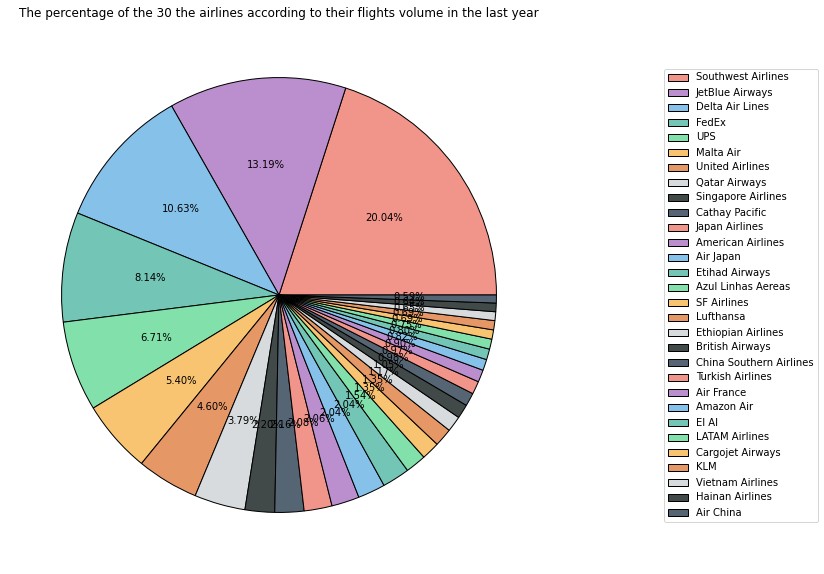

In [43]:
airlinesSortedByTraffic, perTopAirlines = get_percentage_of_flights_by_airline(cleanDf, whichToReturn = "most")

# Select top airlines
fig, axes = plt.subplots(1, figsize=(30,10))
srTopAirlines = pd.Series(perTopAirlines , index=airlinesSortedByTraffic)
one_dim_plot(srTopAirlines, 'pie', axes, title = f"The percentage of the {topToChoose} the airlines according to their flights volume in the last year")

<blockquote>We can show this information as numeric values too:</blockquote>

In [44]:
def countAirlinesToDictionary(inputDf):
    """
    This function will count the amount of times a unique value will be displayed in the 'Airline' column in the DF.
    That way, the function will count the amount of flights per Airline.
    """

    dictionaryOfAirlines = {}
    listOfAirlines = []
    cleanListOfAirlines = []

    listOfAirlines = inputDf['Airline'].tolist()

    for val in listOfAirlines:
        # Check if exists in unique_list or not
        if val not in cleanListOfAirlines:
            cleanListOfAirlines.append(val)

    values, counts = np.unique(listOfAirlines, return_counts = True)

    zip_ite = zip(values, counts)
    dictionaryOfAirlines = dict(zip_ite)

    return dictionaryOfAirlines

In [45]:
def topOfAllDictionaries(df):
    """
    Using the dictionary created before, this function will return two lists:
    The first list contains the amount top Airlines by volume.
    The second list contains that amount of flights per top airline.
    """
    
    top = {}

    airlineNew = df
    filteredAirline = {key : value for key, value in airlineNew.items() if value is not None}
    airlineNew.clear()
    airlineNew.update(filteredAirline)

    dict_list = sorted(df.items(), key=operator.itemgetter(1),reverse=True)
    top = list(dict_list)[:topToChoose]
    topAirlines, topAirlinesFlightsCount = zip(*top)

    return topAirlines, topAirlinesFlightsCount

{'Southwest Airlines': 248385, 'JetBlue Airways': 163521, 'Delta Air Lines': 131702, 'FedEx': 100952, 'UPS': 83207, 'Malta Air': 67078, 'United Airlines': 56975, 'Qatar Airways': 46888, 'Singapore Airlines': 27229, 'Cathay Pacific': 26829, 'Japan Airlines': 25730, 'American Airlines': 25613, 'Air Japan': 25256, 'Etihad Airways': 25204, 'Azul Linhas Aereas': 19117, 'SF Airlines': 16773, 'Lufthansa': 16764, 'Ethiopian Airlines': 14560, 'British Airways': 12939, 'China Southern Airlines': 12045, 'Turkish Airlines': 12007, 'Air France': 11230, 'Amazon Air': 10160, 'El Al': 9904, 'LATAM Airlines': 9267, 'Cargojet Airways': 8503, 'KLM': 8488, 'Vietnam Airlines': 8132, 'Hainan Airlines': 7962, 'Air China': 7365}


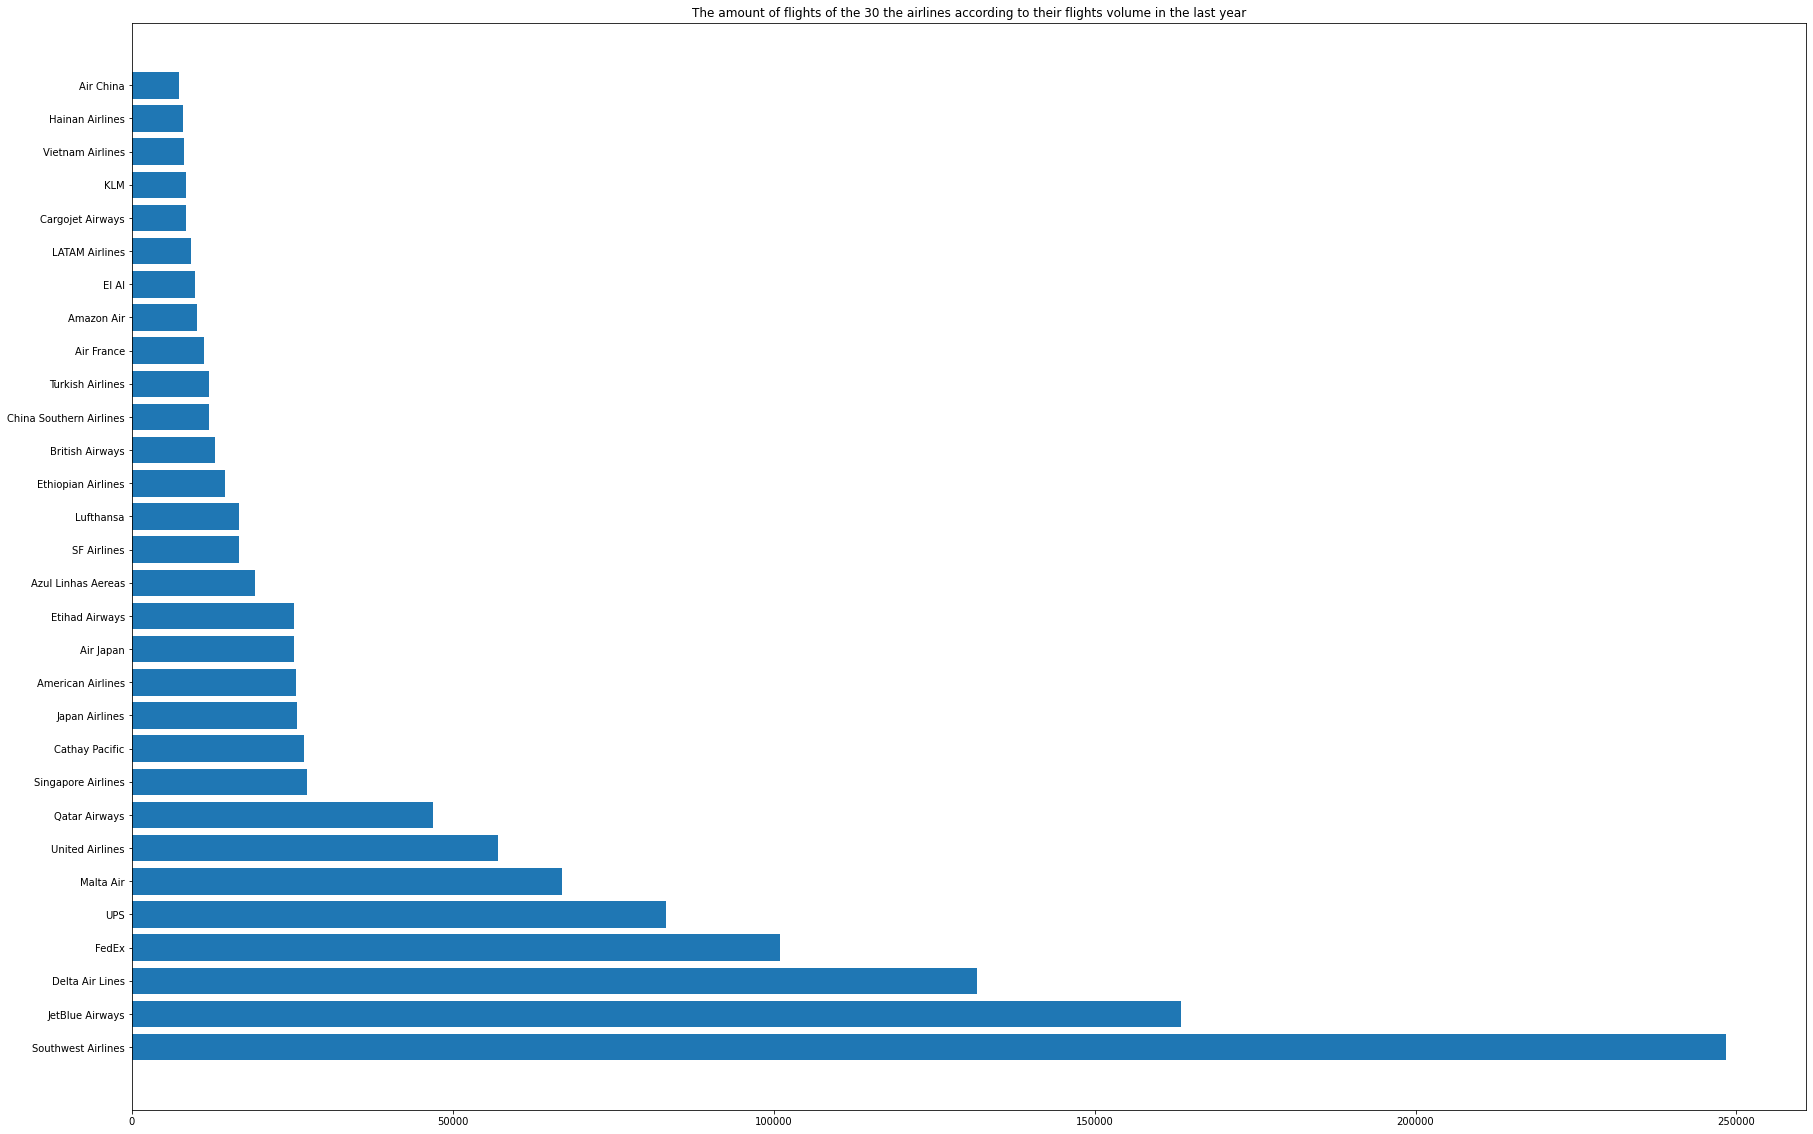

In [46]:
# Top 20 of each
dictionaryOfAirlines = countAirlinesToDictionary(cleanDf)
topAirline, topValuesAirline = topOfAllDictionaries(dictionaryOfAirlines)
topAirline = dict(zip(topAirline, topValuesAirline))

print(topAirline)

# Select top airlines
fig, axes = plt.subplots(1, figsize=(30,20))
srTopAirlines = pd.Series(topValuesAirline , index=topAirline)
one_dim_plot(srTopAirlines, 'barh', axes, title = f"The amount of flights of the {topToChoose} the airlines according to their flights volume in the last year")

<blockquote>
<b>
<br>
Now let's take a look at the percentage of flights per month in the last year ....
<br>
<br>
</b>
</blockquote>

In [47]:
def get_percentage_of_flights_by_months(inputDf):
    """
    This function will calculate the percentage of flights per month, out of the 12 months of the year.
    The function will do this calculation using all the flights per month devided by the total number of flights in the DF.
    """

    global flights_count_per_month

    # Count the total number of flights
    totalNumberOfFlights = len(inputDf)

    # Count the total number of flights
    totalNumberOfFlights = len(inputDf)

    inputDf["ActualDateDeparture (DateOfFlight)"].apply(lambda x: increment_flights(x, False))

    percentages = [round(100 * (float(value) / totalNumberOfFlights), 2) for value in flights_count_per_month.values()]

    print(flights_count_per_month)
    print(percentages)

    return percentages

{'01': 127727, '02': 71929, '03': 97723, '04': 103515, '05': 110370, '06': 121078, '07': 136741, '08': 137538, '09': 138399, '10': 147011, '11': 145759, '12': 157824}
[8.54, 4.81, 6.53, 6.92, 7.38, 8.1, 9.14, 9.2, 9.25, 9.83, 9.75, 10.55]


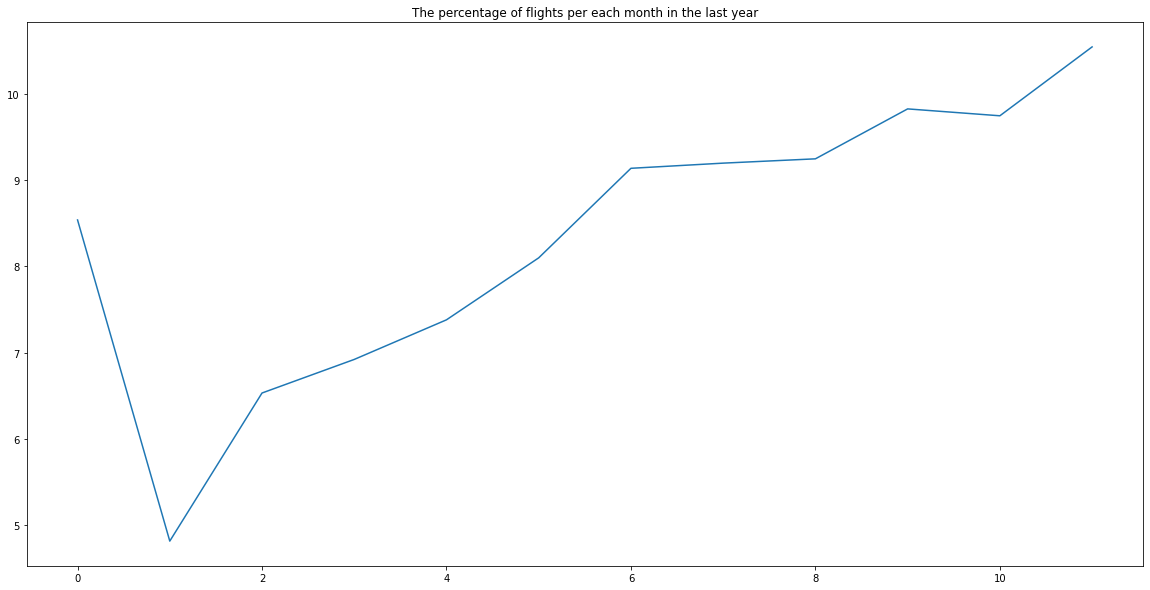

In [48]:
percentageOfFlightsPerMonth = get_percentage_of_flights_by_months(cleanDf)

# Percentages of flights per month
fig, axes = plt.subplots(1, figsize=(20,10))
srPercentageOfFlightsPerMonth = pd.Series(percentageOfFlightsPerMonth , index = flights_count_per_month.keys())
one_dim_plot(srPercentageOfFlightsPerMonth, 'line', axes, title = "The percentage of flights per each month in the last year")

<blockquote>
<b>
<br>
Awesome ! as we see this is very common sense!
The reason for the peak from November to January is the New Year's Eve and The Christmas :)
<br>
<br>
</b>
</blockquote>

<blockquote>
<b>
<br>
Now let's take a look at the amount of lates per month.
<br>
<br>
</b>
</blockquote>

In [49]:
def get_lates_mean_by_months(inputDf):
    """
    This function will calculate the mean of each flight per month.
    That way, we can see the amount of flights made per month out of the entire year.
    """

    global flights_count_per_month
    global lates_count_per_month

    inputDf.loc[inputDf["SymbolizedDeparturesDelta"] == 1]["ActualDateDeparture (DateOfFlight)"].apply(lambda x: increment_flights(x, True))

    keys = flights_count_per_month.keys()

    # For each key from the list above (== for each month) divide the number of lates in that month by the total number of flights in that month
    lates_by_months = [ round((float(lates_count_per_month[key]) / flights_count_per_month[key]), 2) for key in keys ]

    return lates_by_months

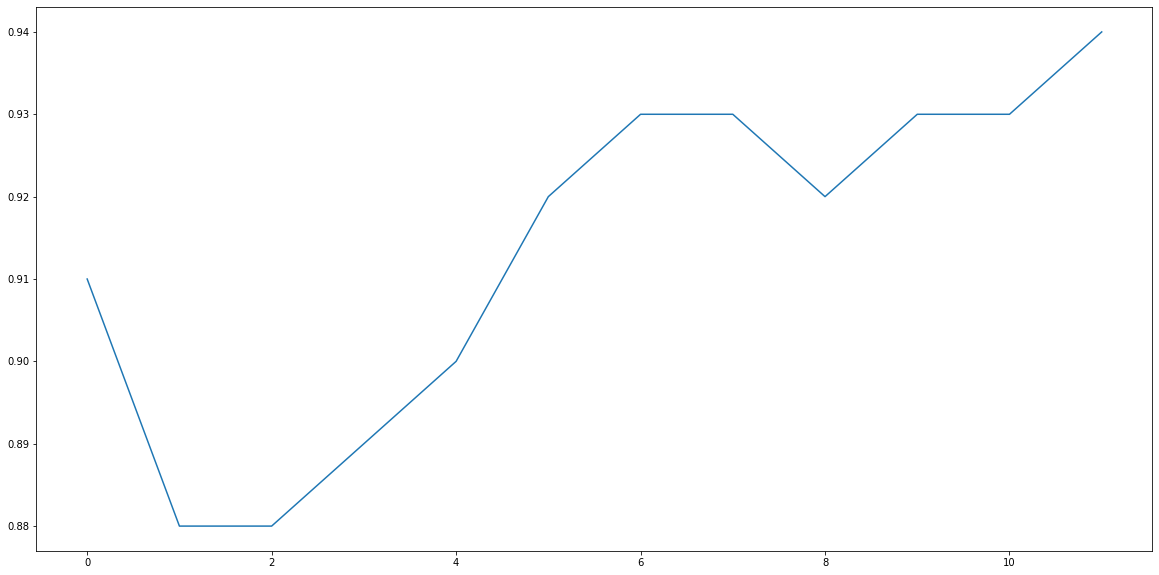

In [50]:
latesByMonth = get_lates_mean_by_months(cleanDf)

# Lates by month
fig, axes = plt.subplots(1, figsize=(20,10))
srLatesByMonth = pd.Series(latesByMonth, index=flights_count_per_month.keys())
one_dim_plot(srLatesByMonth, 'line', axes)

<blockquote>
<br>
We can see a massive correlation between the flights per month and the lates per month, Which means - <b>as more as flights there are in month - the more lates at that month</b>
<br>
<br>
</blockquote>

<blockquote>
<b>
<br>
The next thing we want to see is the amount of delays and eralies per origin and airline (30 with most and least)
<br>
<br>
</b>
</blockquote>

In [51]:
def get_places_with_flights_lateness(inputDf, isMost, returnValueAsPercentage, sortResults):
    """
    This function will return the most lates and most earlies by origin.
    The functino will check whether the user wants to get the most (isMost variable is True) or least (isMost variable is False) in order to assess the needed value to be returned.
    """

    global dictOfSymbolizedDelta
    
    returnLates = None

    groupBySymbolizedDelta = inputDf.groupby("Origin")["SymbolizedDeparturesDelta"].value_counts()
    dictOfSymbolizedDelta = groupBySymbolizedDelta.sort_values().to_dict()

    # Get only the (key, value) pairs which contains 1 in the key
    # ('Abidjan (ABJ)', 1) --> key[1] == 1
    dictOfLates = { key[0] : value for (key, value) in dictOfSymbolizedDelta.items() if key[1] == 1 }

    # Sort the new dictionary by value (Source: https://stackoverflow.com/a/2258273/2196301)
    listOfLates = sorted(dictOfLates.items(), key = lambda x: x[1], reverse = True)

    # If we want the 20 places with the most latenesses
    if isMost == True:
        # Get the ***first*** {topToChoose} keys
        listOfLates = listOfLates[:topToChoose]
    # If we want the 20 places with the least latenesses
    else:
        # Get the ***last*** {topToChoose} keys
        listOfLates = listOfLates[-topToChoose:]

    returnOrigins = [item[0] for item in listOfLates]
    
    if returnValueAsPercentage == True:
        returnLates = [100 * (float(item[1])/len(inputDf[inputDf["Origin"] == item[0]])) for item in listOfLates]
    else:
        returnLates = [item[1] for item in listOfLates]
    
    if sortResults == True:
        returnLates, returnOrigins = (list(unzippedElement) for unzippedElement in zip(*sorted(zip(returnLates, returnOrigins))))
    
    return returnOrigins, returnLates

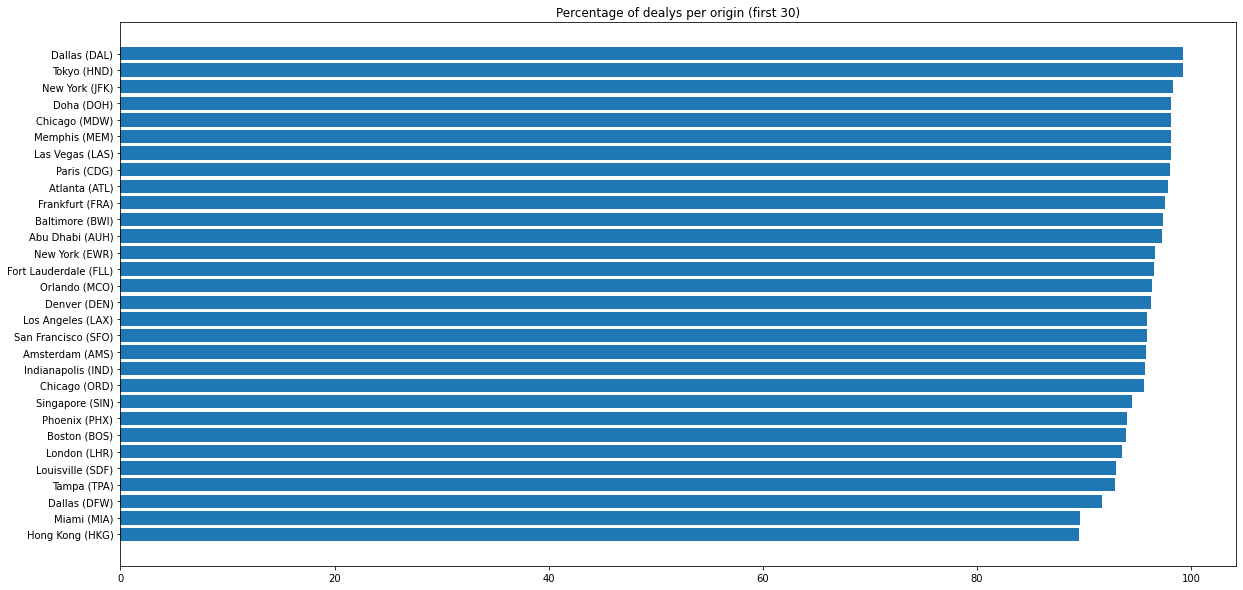

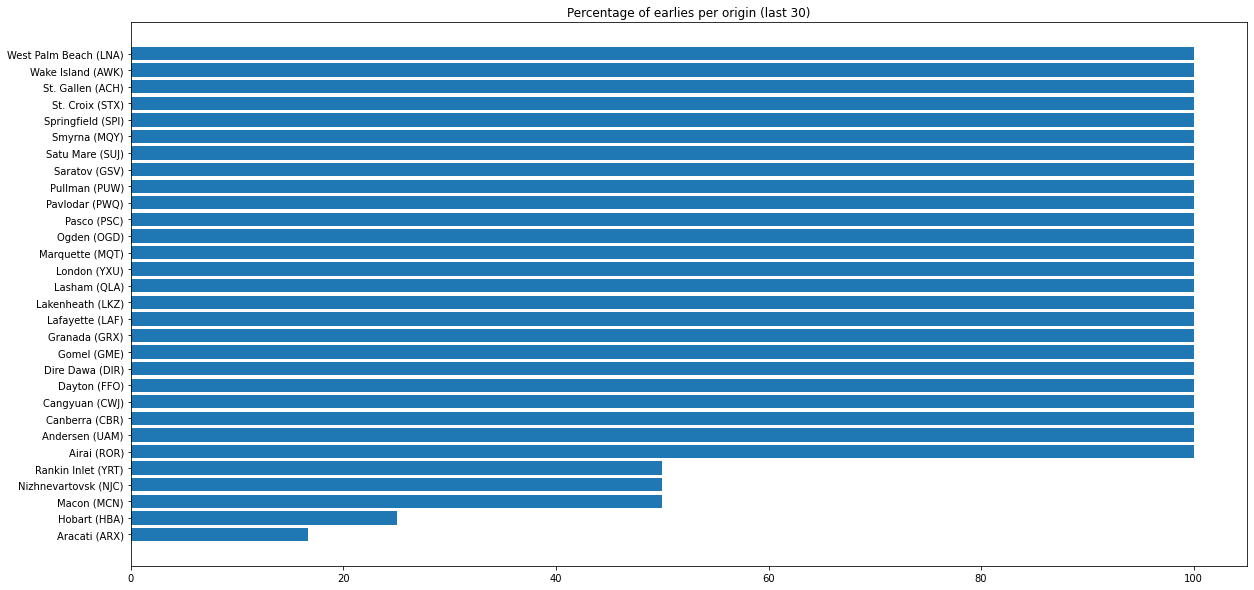

In [52]:
originsMost, latesMost = get_places_with_flights_lateness(cleanDf, isMost = True, returnValueAsPercentage = True, sortResults = True)

# Amount of delays per origin
fig, axes = plt.subplots(1, figsize=(20,10))
srMostLatenessPlaces = pd.Series(latesMost, index=originsMost)
one_dim_plot(srMostLatenessPlaces, 'barh', axes, title = f"Percentage of dealys per origin (first {topToChoose})")

originsLeast, latesLeast = get_places_with_flights_lateness(cleanDf, isMost = False, returnValueAsPercentage = True, sortResults = True)

# Amount of earlies per origin
fig, axes = plt.subplots(1, figsize=(20,10))
srLeastLatenessPlaces = pd.Series(latesLeast , index=originsLeast)
one_dim_plot(srLeastLatenessPlaces, 'barh', axes, title = f"Percentage of earlies per origin (last {topToChoose})")

In [53]:
def get_airlines_with_flights_lateness(inputDf, isMost, returnValueAsPercentage, sortResults):
    """
    """

    global dictOfSymbolizedDelta

    returnPairs = None
    returnLates = None
    
    groupBySymbolizedDelta = inputDf.groupby("Airline")["SymbolizedDeparturesDelta"].value_counts()
    dictOfSymbolizedDelta = groupBySymbolizedDelta.sort_values().to_dict()

    # Get only the (key, value) pairs which contains 1 in the key
    # ('Abidjan (ABJ)', 1) --> key[1] == 1
    dictOfLates = { key[0] : value for (key, value) in dictOfSymbolizedDelta.items() if key[1] == 1 }

    # Sort the new dictionary by value (Source: https://stackoverflow.com/a/2258273/2196301)
    listOfLates = sorted(dictOfLates.items(), key = lambda x: x[1], reverse = True)

    # If we want the 20 places with the most latenesses
    if isMost == True:
        # Get the ***first*** {topToChoose} keys
        listOfLates = listOfLates[:topToChoose]
    # If we want the 20 places with the least latenesses
    else:
        # Get the ***last*** {topToChoose} keys
        listOfLates = listOfLates[-topToChoose:]

    returnAirlines = [item[0] for item in listOfLates]
    
    if returnValueAsPercentage == True:
        returnLates = [100 * (float(item[1])/len(inputDf[inputDf["Airline"] == item[0]])) for item in listOfLates]
    else:
        returnLates = [item[1] for item in listOfLates]
        
    if sortResults == True:
        returnLates, returnAirlines = (list(unzippedElement) for unzippedElement in zip(*sorted(zip(returnLates, returnAirlines))))

    return returnAirlines, returnLates

['UPS', 'Amazon Air', 'Cathay Pacific', 'SF Airlines', 'FedEx', 'KLM', 'Vietnam Airlines', 'LATAM Airlines', 'Azul Linhas Aereas', 'Singapore Airlines', 'Malta Air', 'Qatar Airways', 'Ethiopian Airlines', 'El Al', 'Etihad Airways', 'JetBlue Airways', 'Air Japan', 'American Airlines', 'Air China', 'Turkish Airlines', 'China Southern Airlines', 'British Airways', 'United Airlines', 'Air France', 'Ryanair', 'Lufthansa', 'Hainan Airlines', 'Southwest Airlines', 'Delta Air Lines', 'Japan Airlines']
[72.70061413102263, 76.39763779527559, 81.46036005814604, 82.04853037619985, 82.87502971709327, 85.13195098963241, 87.21101819970487, 88.66947232113954, 88.98885808442746, 89.50751037496786, 90.15474522198038, 91.41784678382528, 91.57967032967032, 92.71001615508885, 93.75099190604665, 93.81914249545929, 93.86680392777954, 94.02647093272948, 94.75899524779362, 94.78637461480804, 96.09796596097966, 96.29028518432645, 96.83720930232558, 97.03472840605521, 97.4048196207044, 97.47077069911715, 97.5383

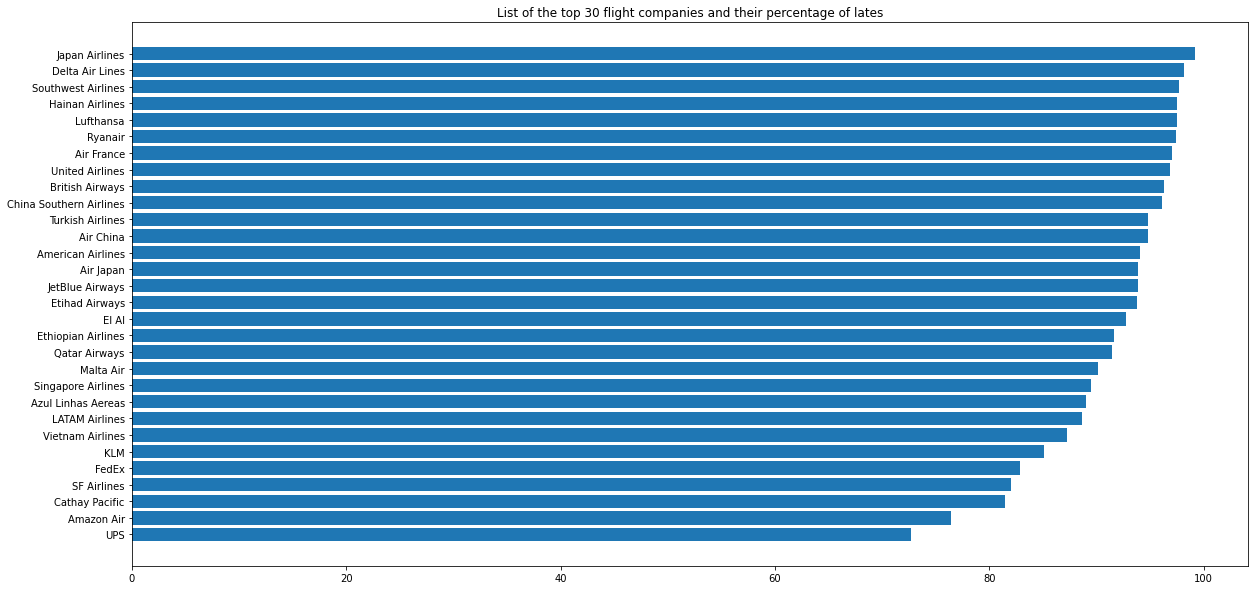

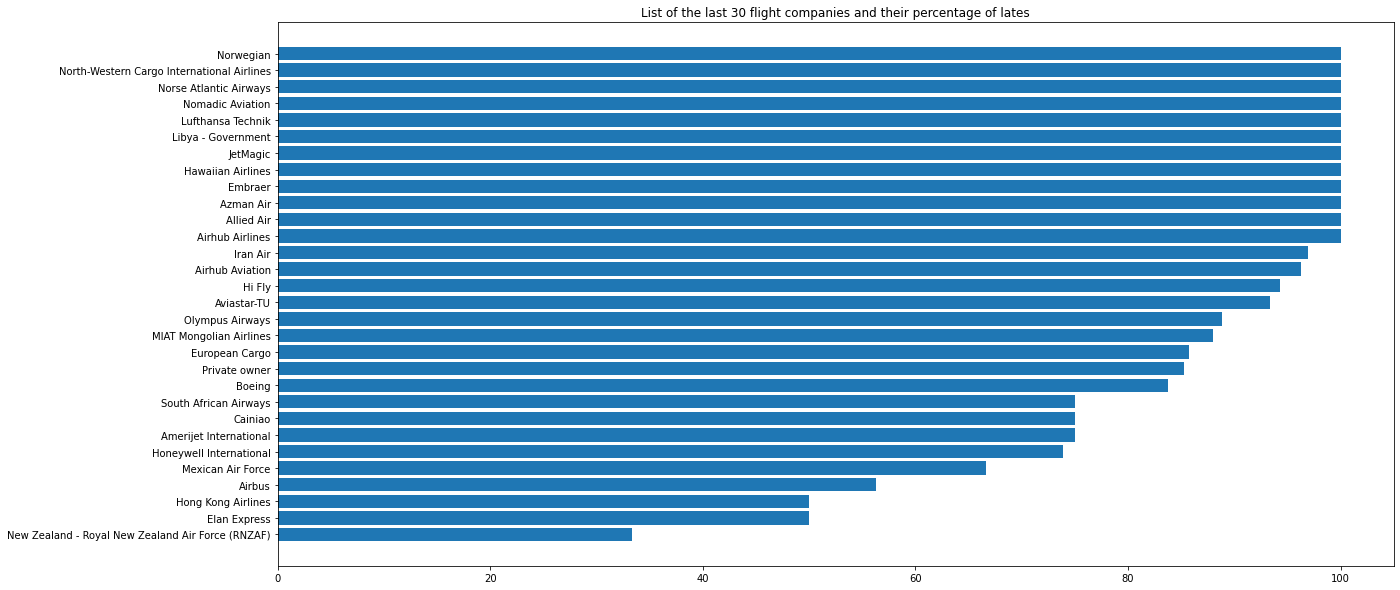

In [54]:
airlinesMost, latesAirlineMost = get_airlines_with_flights_lateness(cleanDf, isMost = True, returnValueAsPercentage = True, sortResults = True)

print(airlinesMost)
print(latesAirlineMost)

# Amount of delays per airline
fig, axes = plt.subplots(1, figsize=(20,10))
srMostLatenessAirlines = pd.Series(latesAirlineMost, index=airlinesMost)
one_dim_plot(srMostLatenessAirlines, 'barh', axes, title = f"List of the top {topToChoose} flight companies and their percentage of lates")

airlinesLeast, latesAirlineLeast = get_airlines_with_flights_lateness(cleanDf, isMost = False, returnValueAsPercentage = True, sortResults = True)

print(airlinesLeast)
print(latesAirlineLeast)

# Amount of earlies per airline
fig, axes = plt.subplots(1, figsize=(20,10))
srLeastLatenessAirlines = pd.Series(latesAirlineLeast, index=airlinesLeast)
one_dim_plot(srLeastLatenessAirlines, 'barh', axes, title = f"List of the last {topToChoose} flight companies and their percentage of lates")

<blockquote>
<b>
<br>
The next thing we want to see is the pairs (origin, destination) with the most of lates.
<br>
<br>
</b>
</blockquote>

In [55]:
def get_lates_by_airports_pairs(inputDf):
    """
    get_lates_by_airports_pairs()

    Purpose:
        Get the lates by airports pairs

    Parameters:
        [pd.DataFrame] inputDf - The input DataFrame object to work with

    Return Value:
        [list] returnAirlines - List with the airlines pair and the lates.
    """

    # lates_per_pairs

    pairsGroupBy = inputDf.groupby(["Origin", "Destination"])["SymbolizedDeparturesDelta"].value_counts()
    # print(pairsGroupBy)

    pairs, counts = zip(*pairsGroupBy.items())
    latesPairsWithCounts = [(pairs[i][0], pairs[i][1], counts[i]) for i in range(len(pairs)) if pairs[i][2] == 1]

    return latesPairsWithCounts

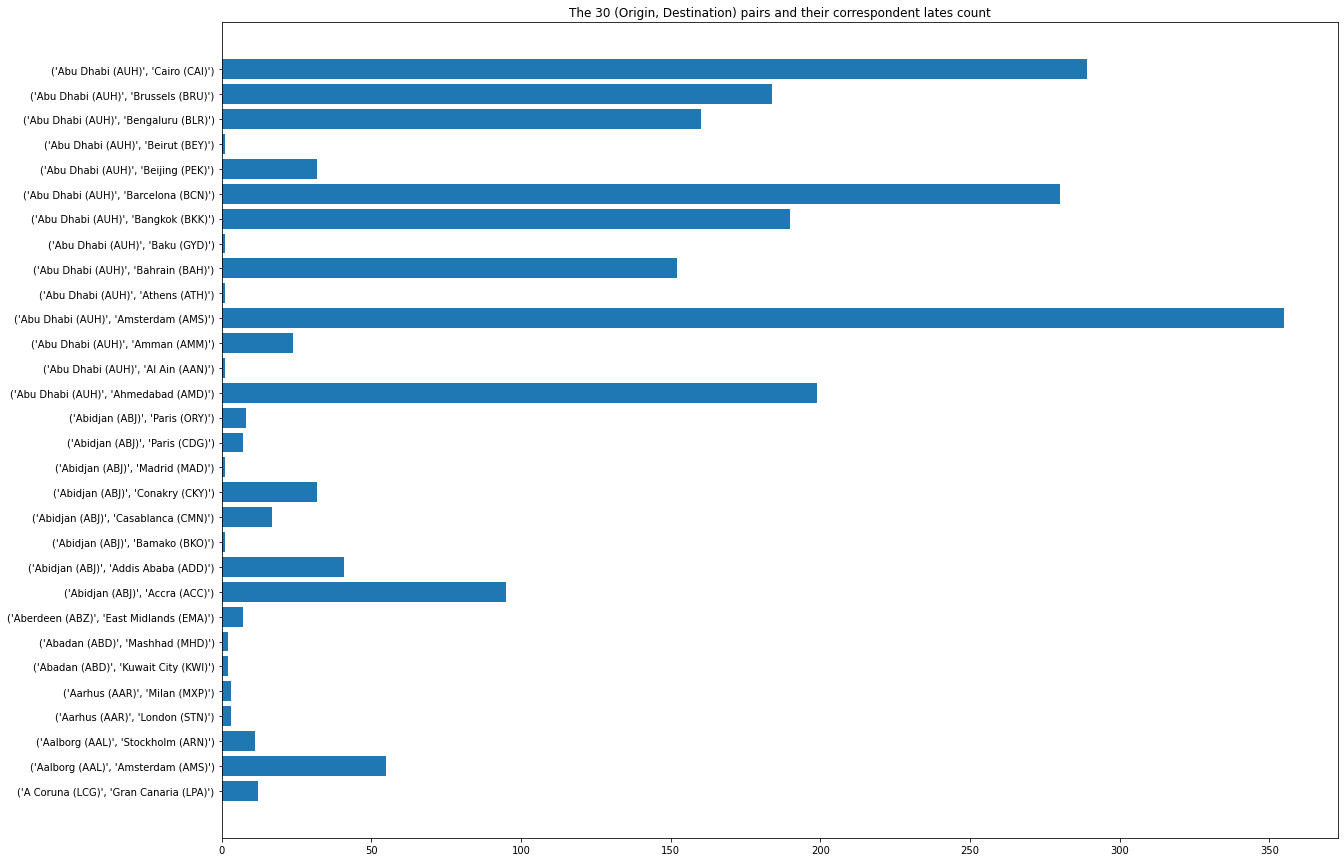

In [56]:
latesByPairs = get_lates_by_airports_pairs(cleanDf)

# Lates by month
fig, axes = plt.subplots(1, figsize=(20,15))
srLatesByPairs = pd.Series([item[2] for item in latesByPairs][:topToChoose], index=[str((item[0], item[1])) for item in latesByPairs][:topToChoose])
one_dim_plot(srLatesByPairs, 'barh', axes, title = f"The {topToChoose} (Origin, Destination) pairs and their correspondent lates count")

<blockquote>
<b>
<br>
We can evan show the correlation matrix of the cleanDf
<br>
<br>
</b>
</blockquote>

In [57]:
def get_properties_with_highest_correlations(df, number_of_highest_values = 5):
    """
    This function will return a dictionary containing the properties with highest correlection in the DF.
    The function will return the dicationary based of the number of highest values required (while the default value is 5).
    """

    df = df.iloc[:,:number_of_highest_values]

    # NOTE: "For any non-numeric data type columns in the dataframe it is ignored."
    # (Source: https://www.geeksforgeeks.org/python-pandas-dataframe-corr/)
    corrsDf = df.corr()

    # "Ignore" the correlations of properties with themselves by replacing them with -1 ....
    # (Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html)
    corrsDf = corrsDf.replace(1, -1)

    columns = corrsDf.columns
    
    returnDict = {}
    
    for column in columns:
    
        # Create the list which holds the information about all the rows names with the higest correlations of this column
        returnDict[column] = []
        
        # Get the rows which includes the highest correlations with the current column
        # (Source: https://stackoverflow.com/a/65024323/2196301)
        tempDf = corrsDf.nlargest(number_of_highest_values, column)
        
        # Iterate on every row id and save it with the correlation of it with the current column
        for row in tempDf.index:
            """
                       | duration | isEnglish
            ----------------------------------
            duration   |   -1     |    0.8
            ----------------------------------
            isEnglish  |   0.8    |    -1
            ----------------------------------
            
            duration = [(isEnglish, 0.8)]
            isEnglish = [(duration, 0.8)]
            """
        
            # If this current pair (row and column) has already covered by the algorithm
            if (row in returnDict.keys() and column in [item[0] for item in returnDict[row]]):
                # go to the next pair
                continue
            else:
                if row is column:
                    continue
                else:
                    # Create the tuple which holds the information about the current row name with the correlation of this column
                    currentRowTuple = (row, tempDf.loc[row, column])
                    
                    # Add this tuple to the list
                    returnDict[column].append(currentRowTuple)
                    
    for key in list(returnDict.keys()):
        if returnDict[key] == []:
            del returnDict[key]
    
    return returnDict

In [58]:
def showCorrelationMatrix(inputDf, number_of_highly_correlated_to_display = None):
    """
    showCorrelationMatrix()
    
    Purpose:
        This method is responsible to show the correlation matrix of the given DataFrame object
    
    Parameters:
        [pd.DataFrame] inputDf                                 - The input DataFrame object to work on
    
    Return Value:
        [int]          number_of_highly_corrrelated_to_display - OPTIONAL. Indicates how many highly correlated columns to show.
                                                                 If this value is None, all the columns will be displayed.
    """
    
    corrMatrix = None
    
    if number_of_highly_correlated_to_display == None:
        corrMatrix = inputDf.corr()
    else:
        corrsDict = get_properties_with_highest_correlations(inputDf, number_of_highest_values = number_of_highly_correlated_to_display)
        corrMatrix = pd.DataFrame([corrsDict])
    
    fig, axes = plt.subplots(1, figsize=(20,10))
    sns.heatmap(corrMatrix, annot=True, ax = axes)
    plt.show()

    return

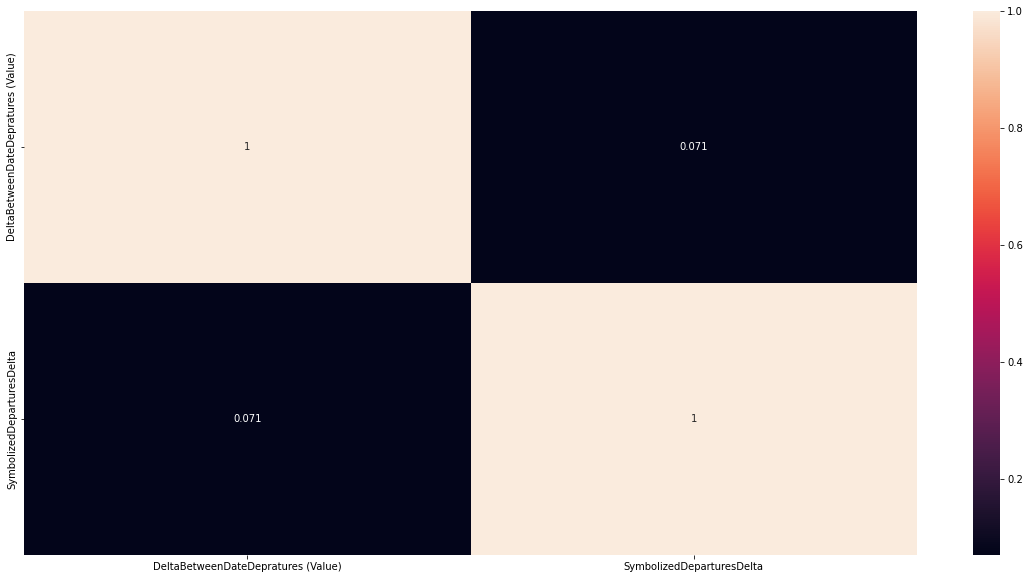

In [59]:
showCorrelationMatrix(cleanDf)

<blockquote>
<br>
    <b>Note that</b> the reason that the dimension of this matrix is 2x2, is that <b>we only have 2 numeric columns at this point of work.</b>
<br>
<br>
</blockquote>

# Mission #6 - Preparation For Machine Learning Models (Missions #7-#9)
    The code in this section was used in order to prepare the clean DataFrame for each machine learning model seperately.

### Preperation For Linear Regression:

In [60]:
###################
#                 #
#     Imports     #
#                 #
###################

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

###################
#                 #
#     Globals     #
#                 #
###################

airlinesDf = None

In [61]:
###################
#                 #
#     Methods     #
#                 #
###################

In [62]:
def prepare_dataset_for_linear_regression(inputDf):
    """
    prepare_dataset_for_linear_regression()
    
    Purpose:
        This method is responsible to create a dataset which suitable for a LinearRegression machine learning model

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to extract the data from

    Return Value:
        [pd.DataFrame] outputDf - The clean DataFrame object
    """
    
    global airlinesDf

    outputDf = inputDf.copy(deep = True)

    # First of all, add a column which indicates for each row if this flight is a low-cost flight or not
    outputDf = add_lowcost_column(outputDf)

    airlinesDf = pd.DataFrame(data = outputDf["Airline"], columns = ["Airline"])

    # Convert Airline column from their category values to numeric codes
    outputDf["Airline"] = outputDf["Airline"].astype('category').cat.codes

    airlinesDf["AirlineCode"] = outputDf["Airline"]
    airlinesDf = airlinesDf.drop_duplicates()

    # Scale the airline column with MinMaxScaler
    outputDf = make_min_max_scaler(outputDf, "Airline", override = True)

    airlinesDf["AirlineCode_scaled"] = outputDf["Airline"]
    airlinesDf.to_csv(PATH_OF_GENERAL_OUTPUTS + "airlines.csv", index = False)

    # Convert Origin and Destination columns from their category values to numeric codes
    origins = outputDf["Origin"].to_numpy()
    destinations = outputDf["Destination"].to_numpy()
    categorical_airports = np.concatenate([origins, destinations])
    categorical_airports = np.unique(categorical_airports)

    airports_dict = {}

    for i in range(len(categorical_airports)):
        currentCategoricalAirport = categorical_airports[i]
        airports_dict[currentCategoricalAirport] = i

    # Scale the airlines codes with MinMaxScaler
    airportsDf = pd.DataFrame(data = airports_dict.items(), columns = ["AirportName", "AirportCode"])
    airportsDf = make_min_max_scaler(airportsDf, "AirportCode", override = False)
    airportsDf.to_csv(PATH_OF_GENERAL_OUTPUTS + "airports.csv", index = False)

    airports_dict = airportsDf.to_dict(orient = "list")
    keys = airports_dict["AirportName"]
    values = airports_dict["AirportCode_scaled"]
    airports_dict = dict(zip(keys, values))

    # Change the codes of the airports to their scaled codes values
    outputDf["Origin"] = outputDf["Origin"].apply(lambda currentOrigin: airports_dict[currentOrigin])
    outputDf["Destination"] = outputDf["Destination"].apply(lambda currentDestination: airports_dict[currentDestination])

    # Remove the column "FlightID"
    outputDf = outputDf.drop(["FlightID"], axis = 1)

    outputDf["FlightTime"] = outputDf["FlightTime"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "time"))

    # Remove the columns "ScheduledDateDeparture" and "ActualDateDeparture (DateOfFlight)"
    outputDf = outputDf.drop(["ScheduledDateDeparture", "ActualDateDeparture (DateOfFlight)"], axis = 1)

    # Remove the columns "ScheduledTimeDeparture" and "ActualTimeDeparture"
    outputDf = outputDf.drop(["ScheduledTimeDeparture", "ActualTimeDeparture"], axis = 1)

    outputDf["DeltaBetweenDateDepratures (Value)"] = outputDf["DeltaBetweenDateDepratures (Value)"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "date"))
    outputDf["DeltaBetweenTimeDepratures (Value)"] = outputDf["DeltaBetweenTimeDepratures (Value)"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "time"))

    outputDf["DeltaBetweenDepratures (Value)"] = outputDf["DeltaBetweenDateDepratures (Value)"].astype(np.number) + outputDf["DeltaBetweenTimeDepratures (Value)"].astype(np.number)
    outputDf["DeltaBetweenDepratures (Value)"] = outputDf["DeltaBetweenDepratures (Value)"].apply(lambda value: get_bin(value))

    outputDf = outputDf.drop(["ScheduledDateArrival", "ScheduledTimeArrival"], axis = 1)
    outputDf = outputDf.drop(["LandingTime"], axis = 1)

    # Re-arrange the order of the column to our desired order
    columns = [
        "Airline",
        "Origin",
        "Destination",
        "FlightTime",
        "DeltaBetweenDateDepratures (Value)",
        "DeltaBetweenTimeDepratures (Value)",
        "DeltaBetweenDepratures (Value)",
        "SymbolizedDeparturesDelta",
        "IsLowCost"
        ]
    
    outputDf = outputDf[columns]

    return outputDf

In [63]:
def prepare_dataset_for_logistic_regression(inputDf):
    """
    prepare_dataset_for_logistic_regression()
    
    Purpose:
        This method is responsible to create a dataset which suitable for a LogisticRegression machine learning model

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to extract the data from

    Return Value:
        [pd.DataFrame] outputDf - The clean DataFrame object
    """

    outputDf = inputDf.copy(deep = True)

    # First of all, add a column which indicates for each row if this flight is a low-cost flight or not
    outputDf = add_lowcost_column(outputDf)

    # Convert Airline column from their category values to numeric codes
    outputDf["Airline"] = outputDf["Airline"].astype('category').cat.codes

    # Convert Origin and Destination columns from their category values to numeric codes
    origins = outputDf["Origin"].to_numpy()
    destinations = outputDf["Destination"].to_numpy()
    categorical_airports = np.concatenate([origins, destinations])
    categorical_airports = np.unique(categorical_airports)

    airports_dict = {}

    for i in range(len(categorical_airports)):
        currentCategoricalAirport = categorical_airports[i]
        airports_dict[currentCategoricalAirport] = i

    outputDf["Origin"] = outputDf["Origin"].apply(lambda currentOrigin: airports_dict[currentOrigin])
    outputDf["Destination"] = outputDf["Destination"].apply(lambda currentDestination: airports_dict[currentDestination])

    # Remove the column "FlightID"
    outputDf = outputDf.drop(["FlightID"], axis = 1)

    outputDf["FlightTime"] = outputDf["FlightTime"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "time"))

    # Add "DeltaBetweenTimeDepratures (Symbol)" and "DeltaBetweenDateDepratures (Symbol)" columns
    outputDf = add_symbolized_departures_delta(outputDf)

    # Remove the columns "ScheduledDateDeparture" and "ActualDateDeparture (DateOfFlight)"
    outputDf = outputDf.drop(["ScheduledDateDeparture", "ActualDateDeparture (DateOfFlight)"], axis = 1)

    # Remove the columns "ScheduledTimeDeparture" and "ActualTimeDeparture"
    outputDf = outputDf.drop(["ScheduledTimeDeparture", "ActualTimeDeparture"], axis = 1)

    outputDf["DeltaBetweenDateDepratures (Value)"] = outputDf["DeltaBetweenDateDepratures (Value)"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "date"))
    outputDf["DeltaBetweenTimeDepratures (Value)"] = outputDf["DeltaBetweenTimeDepratures (Value)"].apply(lambda currentFlightTime: convert_time_to_minutes_presentation(currentFlightTime, "time"))

    outputDf["DeltaBetweenDepratures (Value)"] = outputDf["DeltaBetweenDateDepratures (Value)"].astype(np.number) + outputDf["DeltaBetweenTimeDepratures (Value)"].astype(np.number)

    outputDf = outputDf.drop(["ScheduledDateArrival", "ScheduledTimeArrival"], axis = 1)

    # Re-arrange the order of the column to our desired order
    columns = [
        "Airline",
        # "DateOfFlight",
        "Origin",
        "Destination",
        #"FlightID",
        "FlightTime",
        #"ScheduledDateDeparture",
        #"ActualDateDeparture",
        "DeltaBetweenDateDepratures (Symbol)",
        # "DeltaBetweenDateDepratures (Value)",
        #"ScheduledTimeDeparture",
        #"ActualTimeDeparture",
        "DeltaBetweenTimeDepratures (Symbol)",
        "SymbolizedDeparturesDelta",
        "DeltaBetweenDepratures (Value)",
        # "DeltaBetweenTimeDepratures (Value)",
        #"ScheduledDateArrival",
        #"ScheduledTimeArrival",
        # "Status",
        #"LandingTime"
        "IsLowCost"
        ]

    outputDf = outputDf[columns]

    return outputDf

In [64]:
def prepare_dataset_for_clustering(inputDf):
    """
    prepare_dataset_for_clustering()
    
    Purpose:
        This method is responsible to create a dataset which suitable for a clustering machine learning model

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to extract the data from

    Return Value:
        [pd.DataFrame] outputDf - The clean DataFrame object
    """

    outputDf = prepare_dataset_for_logistic_regression(inputDf)

    return outputDf

In [65]:
def add_lowcost_column(inputDf):
    """
    add_lowcost_column()
    
    Purpose:
        This method is responsible to add a lowcost column to the given DataFrame object

    Parameters:
        [pd.DataFrame] inputDf  - The input DataFrame object to work on

    Return Value:
        [pd.DataFrame] outputDf - The ready DataFrame after the current work
    """

    outputDf = inputDf.copy(deep = True)

    # Get the full list of all the low cost airlines
    lowCostAirlines = get_low_cost_airlines()

    outputDf['IsLowCost'] = np.where(outputDf['Airline'].isin(lowCostAirlines), 1, 0)

    return outputDf

In [66]:
def make_min_max_scaler(inputdf, srtingOfCol, override = False):
    """
    make_min_max_scaler()
    
    Purpose:
        This method is responsible to scale the requested column of a given DataFrame object.

    Parameters:
        [pd.DataFrame] inputDf     - The input DataFrame object to work on
        [str]          stringOfCol - The column which need to be scaled
        [bool]         override    - A bool value which indicates if to override the original column's values.
                                     If not, a new column will be created for the scaled column (column name format: {stringOfCol_scaled}))

    Return Value:
        [pd.DataFrame] outputDf    - The ready DataFrame after the current work
    """

    min_max_scaler = MinMaxScaler()
    outputDf = inputdf.copy(deep = True)

    if override == True:
        outputDf[[srtingOfCol]] = min_max_scaler.fit_transform(outputDf[[srtingOfCol]])
    else:
        outputDf[[srtingOfCol + "_scaled"]] = min_max_scaler.fit_transform(outputDf[[srtingOfCol]])

    return outputDf

In [67]:
def get_bin(value, binlimit = 30):
    """
    get_bin()
    
    Purpose:
        This method is responsible to return the bin of the given number

    Parameters:
        [int] value       - The value which should be binned
        [int] binLimit    - The number which the given "value" will be devided by (this is actually the bins indicator)

    Return Value:
        [int] returnValue - The bin number of the input number
    """

    returnValue = None

    if binlimit == 0:
        binlimit = 30

    if value == 0:
        returnValue = 0
    elif value > 0:
        returnValue = (int(value / binlimit) + 1)
    elif value < 0:
        returnValue = (int(value / binlimit) - 1)

    return returnValue

In [68]:
def add_symbolized_departures_delta(inputDf):
    """
    add_symbolized_departures_delta()
    
    Purpose:
        This method is responsible to create a new column in the given DataFrame which named "DeltaBetweenDepartures (Symbol)".
        The values in this column, for each row in the DataFrame can be from the next options according to the Delta status:
        
        # -1 (early)
        # 0 (on time)
        # 1 (late)

    Parameters:
        None

    Return Value:
        [pd.DataFrame] outputDf - The ready DataFrame after the current work
    """

    outputDf = inputDf.copy(deep = True)

    outputDf['DeltaBetweenDateDepratures (Symbol)'] = outputDf['DeltaBetweenDateDepratures (Value)'].apply(lambda value: convert_date_deprature_delta_value_to_symbol(value))

    outputDf['DeltaBetweenTimeDepratures (Symbol)'] = np.where(outputDf['DeltaBetweenTimeDepratures (Value)'].str.contains('-'), -1, 1)
    outputDf['DeltaBetweenTimeDepratures (Symbol)'] = np.where(outputDf['DeltaBetweenTimeDepratures (Value)'].str.contains('0:00'), 0, outputDf['DeltaBetweenTimeDepratures (Symbol)'])

    return outputDf

In [69]:
linearDf = prepare_dataset_for_linear_regression(cleanDf)
linearDf.to_csv(PATH_OF_GENERAL_OUTPUTS + "linearDf.csv", index = False)
print("\t" * 7 + "linearDf:")
linearDf

							linearDf:


,Airline,Origin,Destination,FlightTime,DeltaBetweenDateDepratures (Value),DeltaBetweenTimeDepratures (Value),DeltaBetweenDepratures (Value),SymbolizedDeparturesDelta,IsLowCost
0,0.636364,0.439606,0.887428,121,0,21,1,1,0
1,0.636364,0.887428,0.439606,96,0,15,1,1,0
2,0.636364,0.428102,0.887428,79,0,15,1,1,0
3,0.636364,0.887428,0.428102,66,0,13,1,1,0
5,0.636364,0.428102,0.887428,87,0,204,7,1,0
...,...,...,...,...,...,...,...,...,...
1656318,0.839572,0.078882,0.203780,65,0,10,1,1,1
1656319,0.839572,0.386196,0.078882,60,0,8,1,1,1
1656320,0.839572,0.289236,0.386196,151,0,8,1,1,1
1656321,0.839572,0.372227,0.289236,132,0,0,0,0,1


In [70]:
logisticDf = prepare_dataset_for_logistic_regression(cleanDf)
logisticDf.to_csv(PATH_OF_GENERAL_OUTPUTS + "logisticDf.csv", index = False)
print("\t" * 7 + "logisticDf:")
logisticDf

							logisticDf:


,Airline,Origin,Destination,FlightTime,DeltaBetweenDateDepratures (Symbol),DeltaBetweenTimeDepratures (Symbol),SymbolizedDeparturesDelta,DeltaBetweenDepratures (Value),IsLowCost
0,119,535,1080,121,0,1,1,21.0,0
1,119,1080,535,96,0,1,1,15.0,0
2,119,521,1080,79,0,1,1,15.0,0
3,119,1080,521,66,0,1,1,13.0,0
5,119,521,1080,87,0,1,1,204.0,0
...,...,...,...,...,...,...,...,...,...
1656318,157,96,248,65,0,1,1,10.0,1
1656319,157,470,96,60,0,1,1,8.0,1
1656320,157,352,470,151,0,1,1,8.0,1
1656321,157,453,352,132,0,0,0,0.0,1


In [71]:
clusteringDf = prepare_dataset_for_clustering(cleanDf)
clusteringDf.to_csv(PATH_OF_GENERAL_OUTPUTS + "clusteringDf.csv", index = False)
print("\t" * 7 + "clusteringDf:")
clusteringDf

							clusteringDf:


,Airline,Origin,Destination,FlightTime,DeltaBetweenDateDepratures (Symbol),DeltaBetweenTimeDepratures (Symbol),SymbolizedDeparturesDelta,DeltaBetweenDepratures (Value),IsLowCost
0,119,535,1080,121,0,1,1,21.0,0
1,119,1080,535,96,0,1,1,15.0,0
2,119,521,1080,79,0,1,1,15.0,0
3,119,1080,521,66,0,1,1,13.0,0
5,119,521,1080,87,0,1,1,204.0,0
...,...,...,...,...,...,...,...,...,...
1656318,157,96,248,65,0,1,1,10.0,1
1656319,157,470,96,60,0,1,1,8.0,1
1656320,157,352,470,151,0,1,1,8.0,1
1656321,157,453,352,132,0,0,0,0.0,1


# Mission #7 - 1st Machine Learning (Linear Regression)
    The code in this section was used in order to try to answer the next question with usage of LinearRegression model:
    
<blockquote>If details of new flight are being given to us - <b>Will the flight be late? Will it arrive on time? Will it land earlier than expected? If so, by how much time (in minutes)?</b> </blockquote>

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

### Pre-Execution Visualization
    First we wanted to see 2 thins for each airlines from the list of airlines with the top flights volume:
    1. A Scatter Plot which will describe for each airline the affection of the flight time on the delta time between departuers
    2. An Histograma of the binned delta times between departuers of each airline

C:\Users\ahaav\AppData\Local\Temp\ipykernel_19208\1083988489.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))


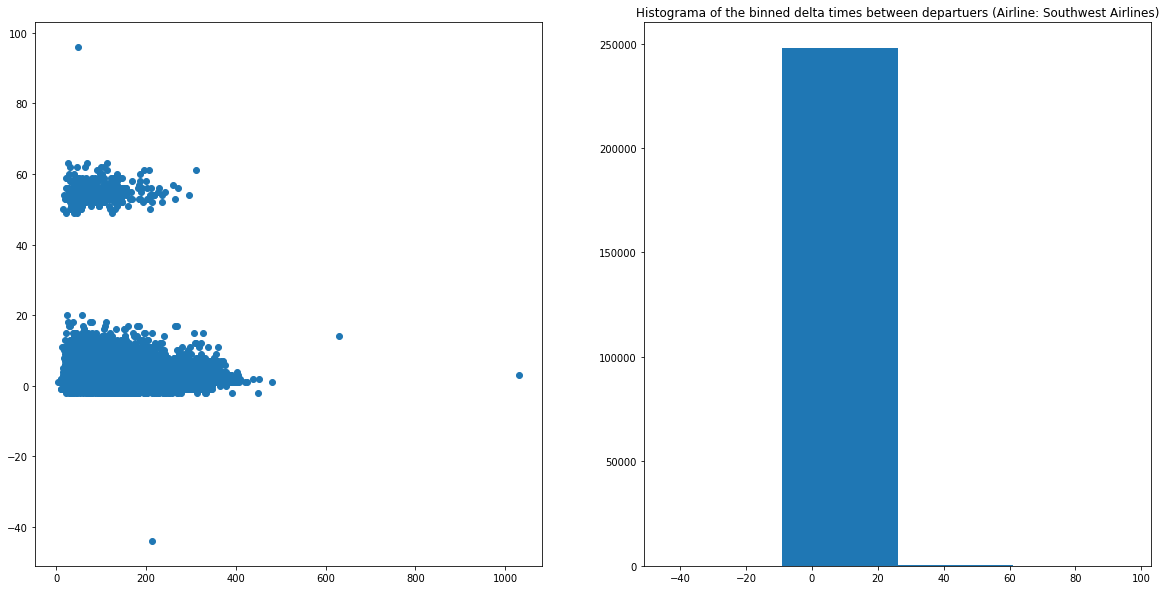

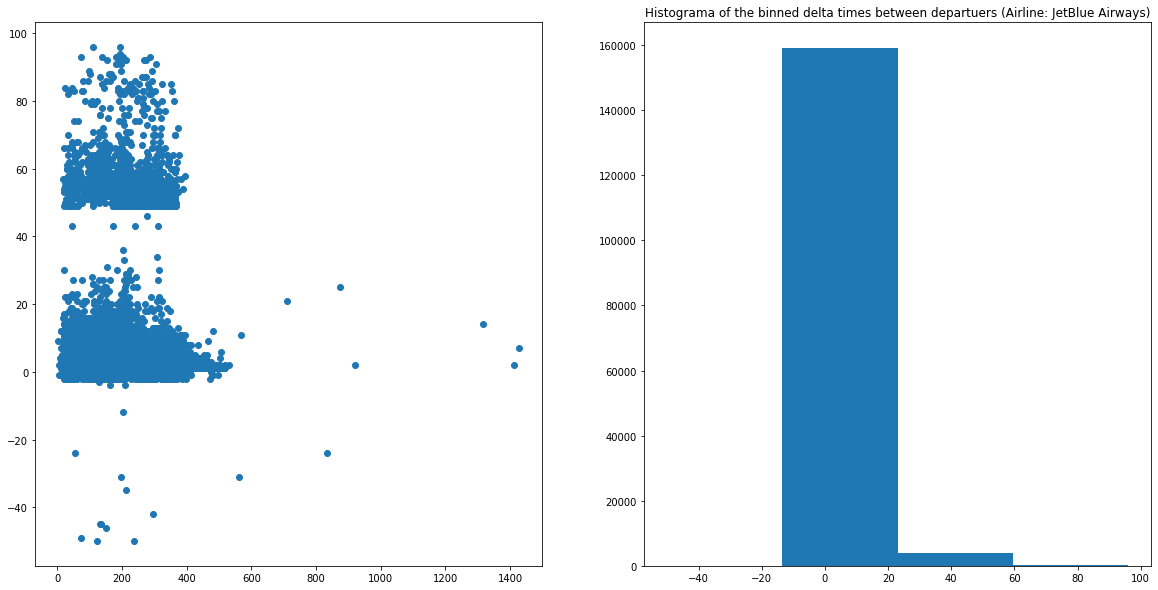

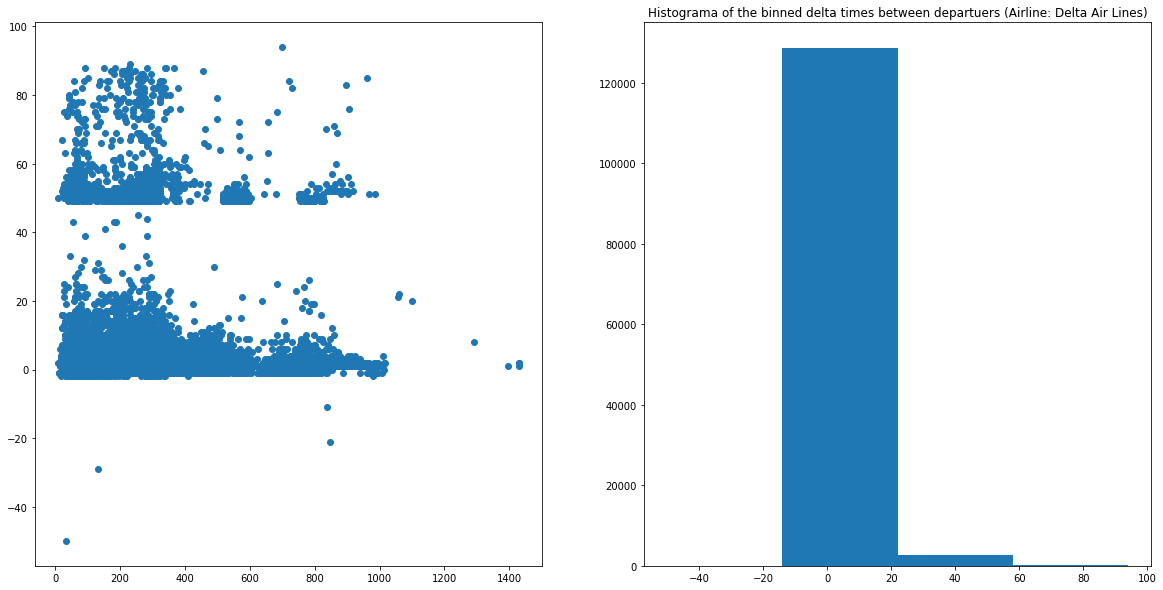

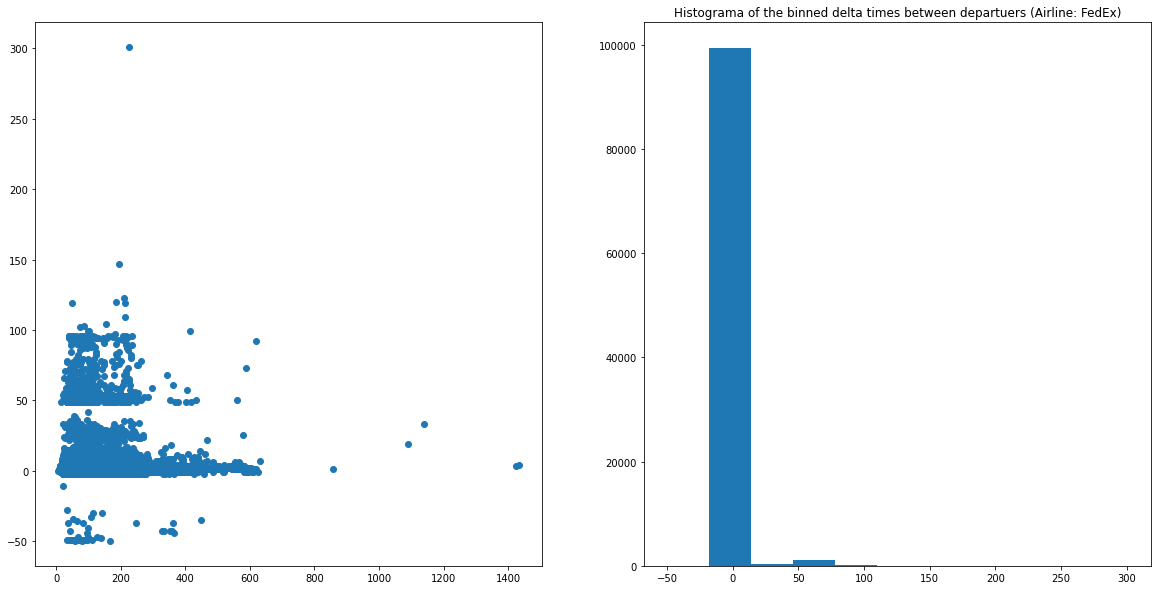

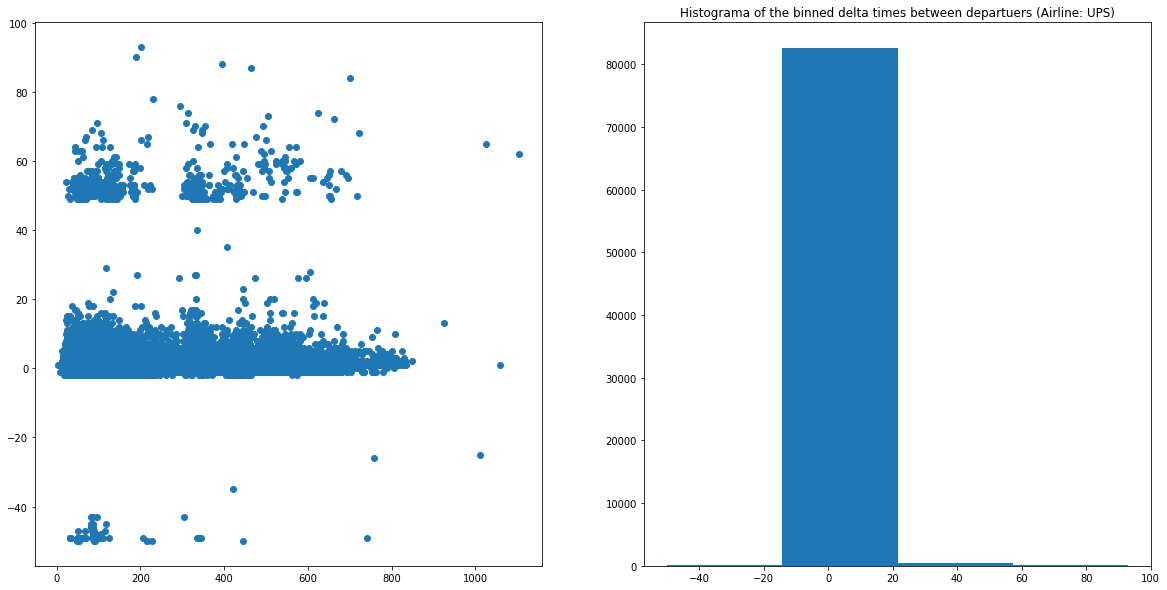

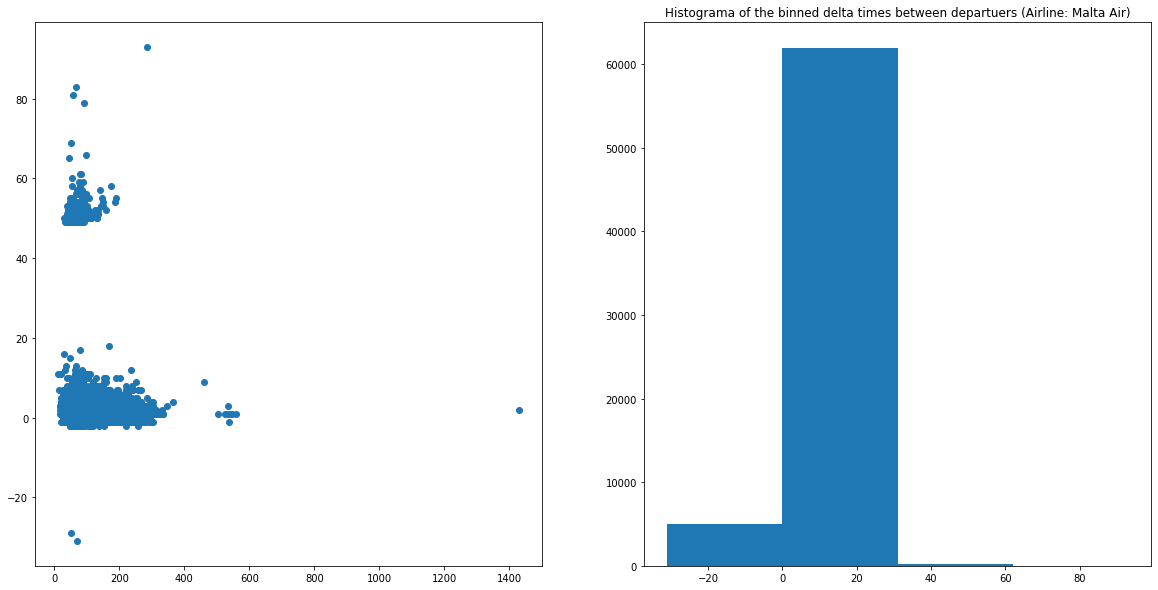

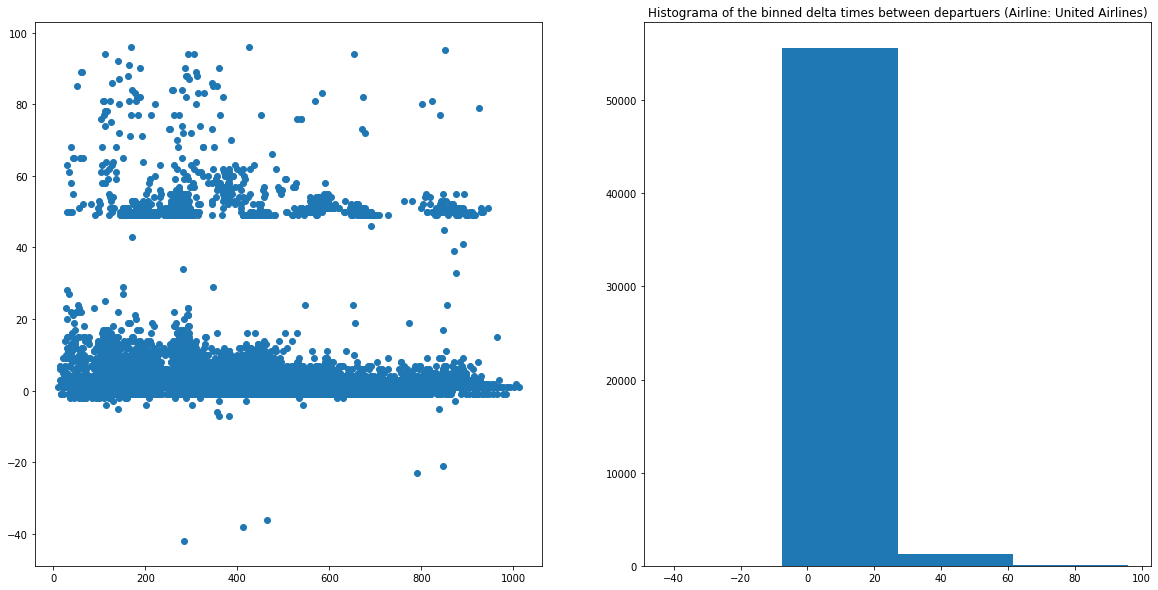

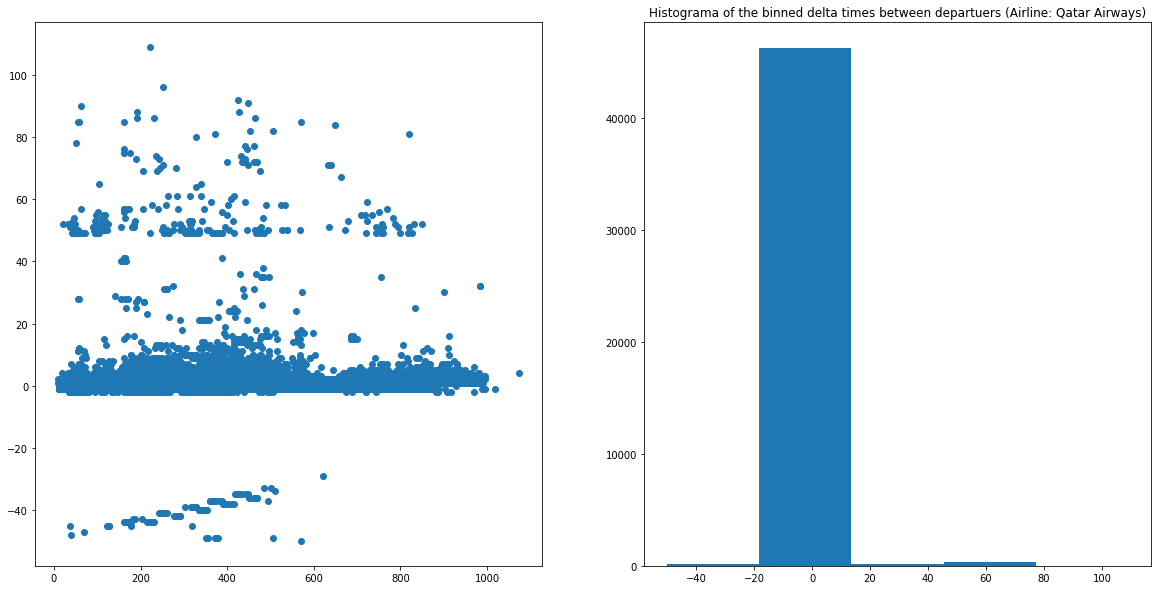

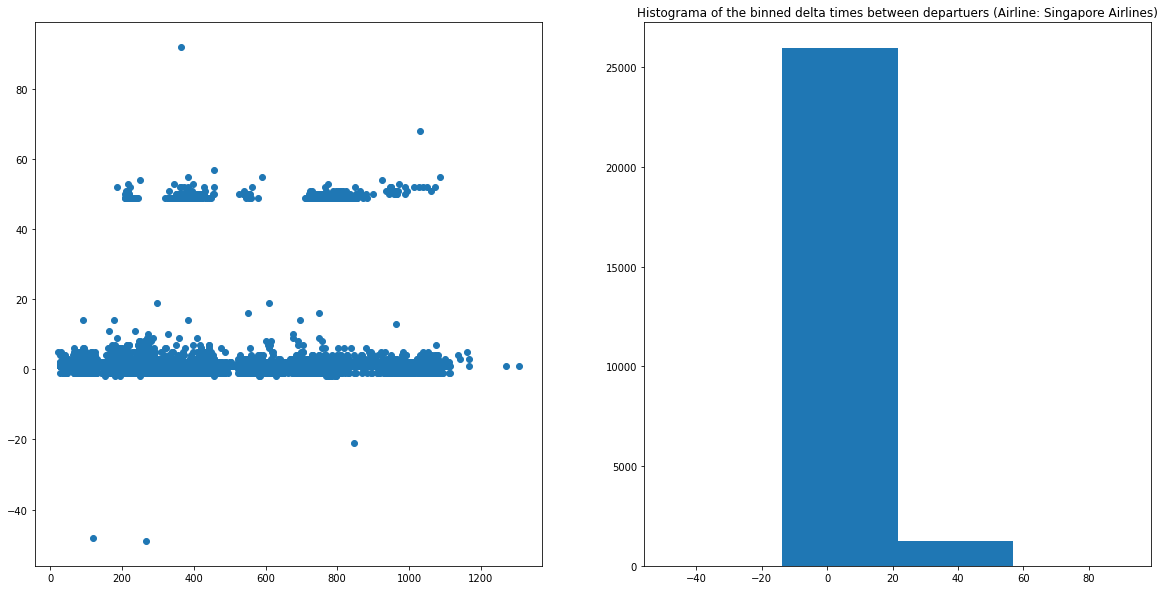

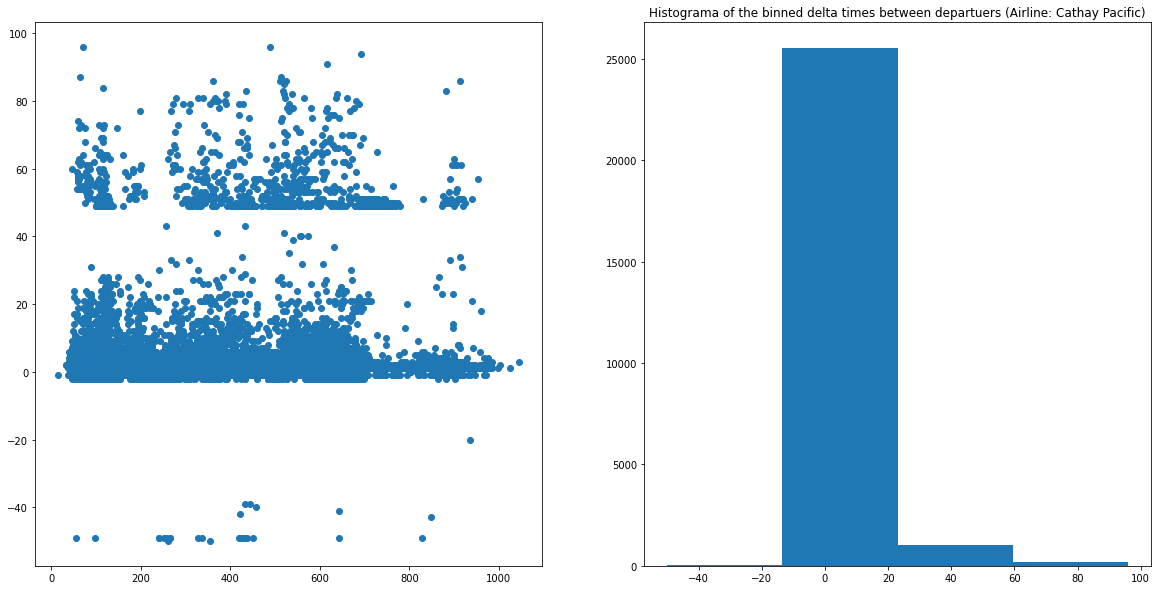

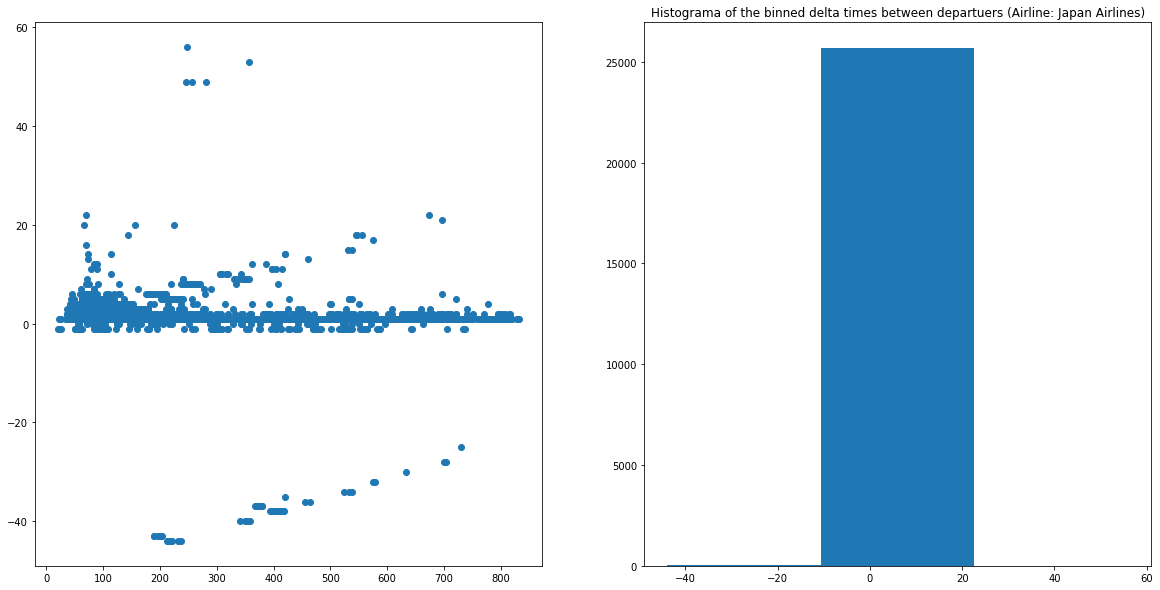

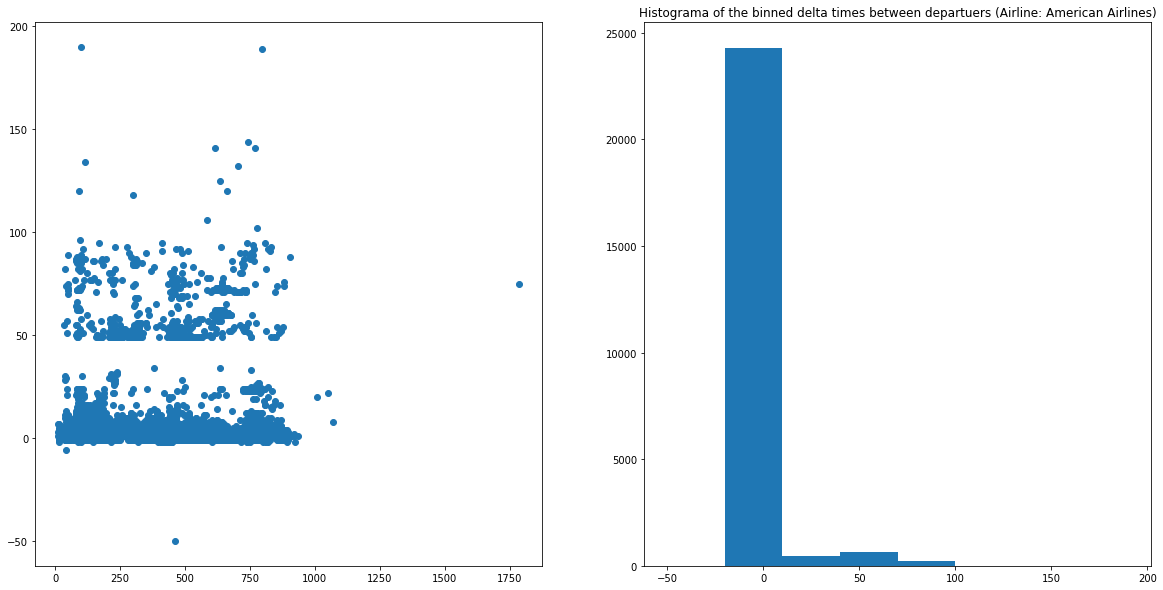

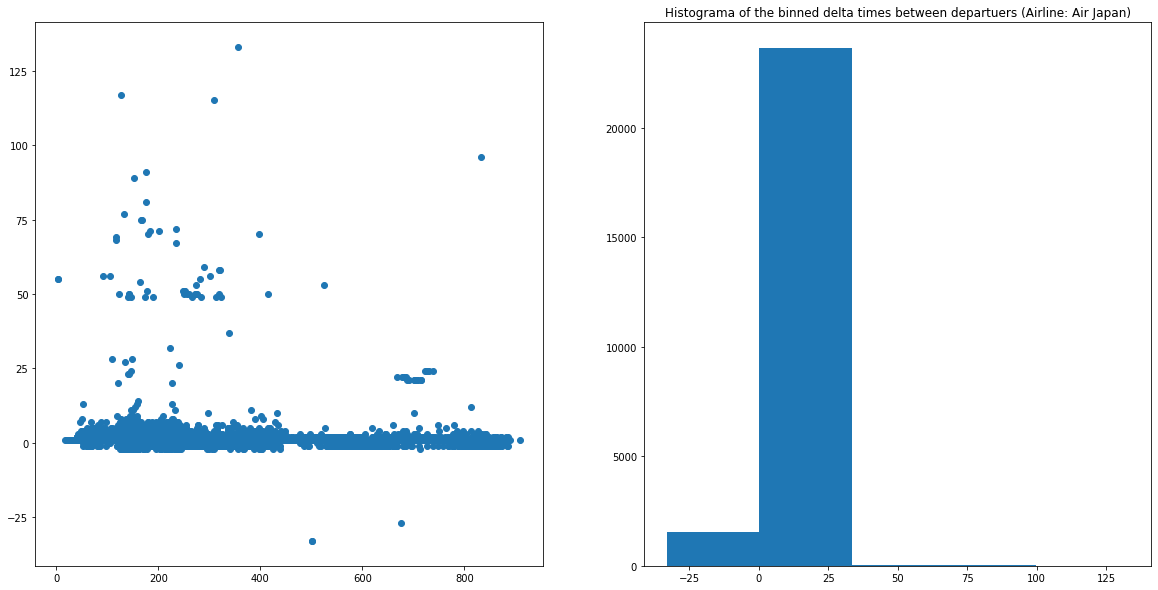

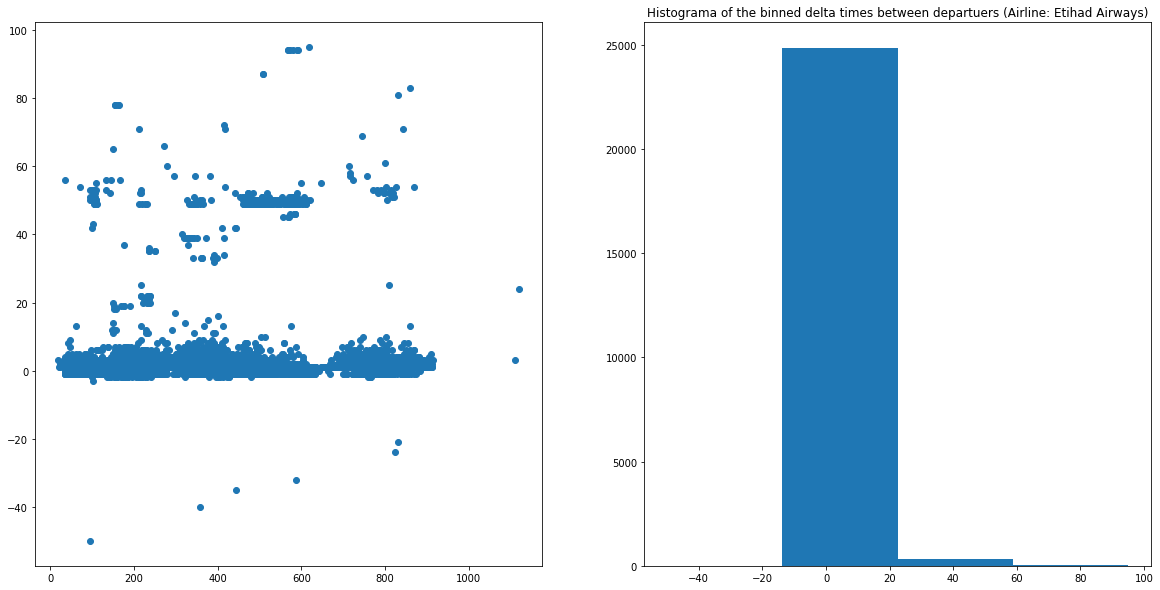

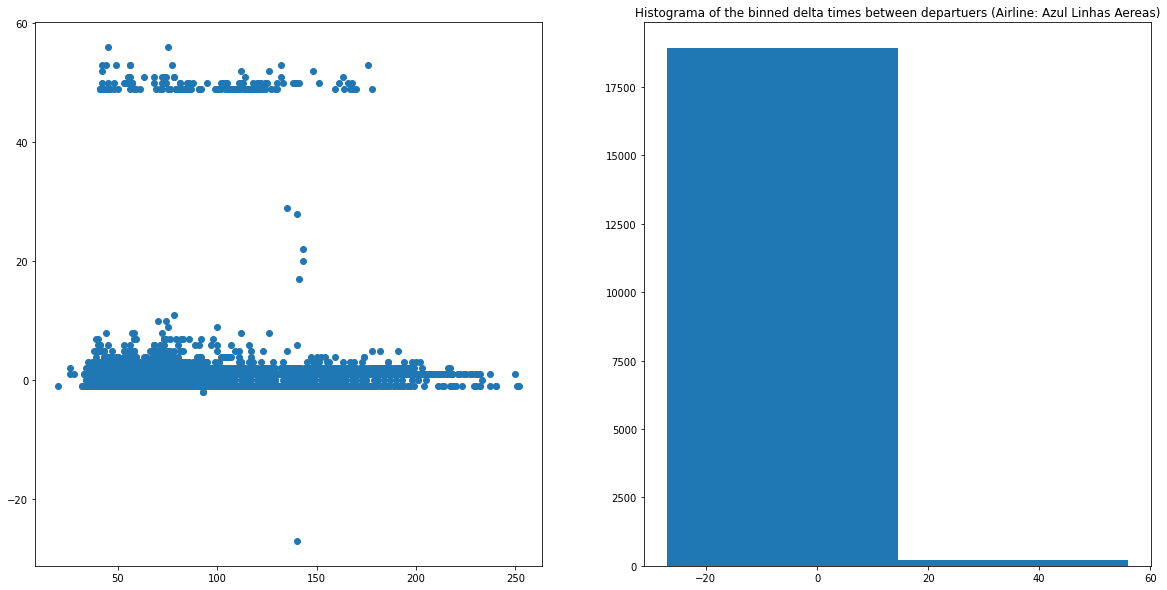

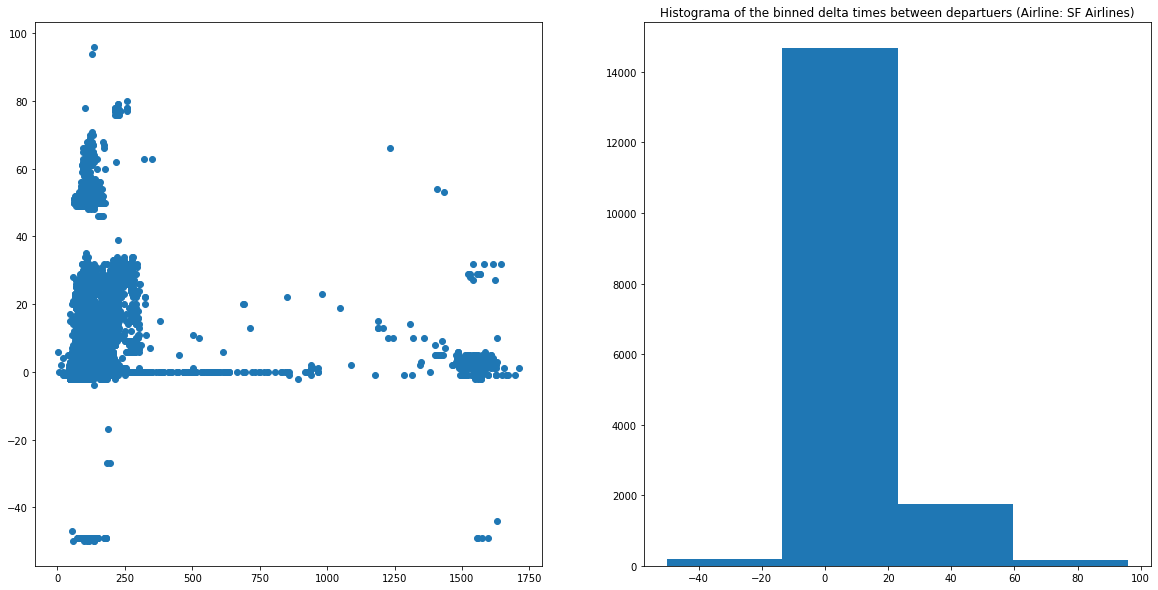

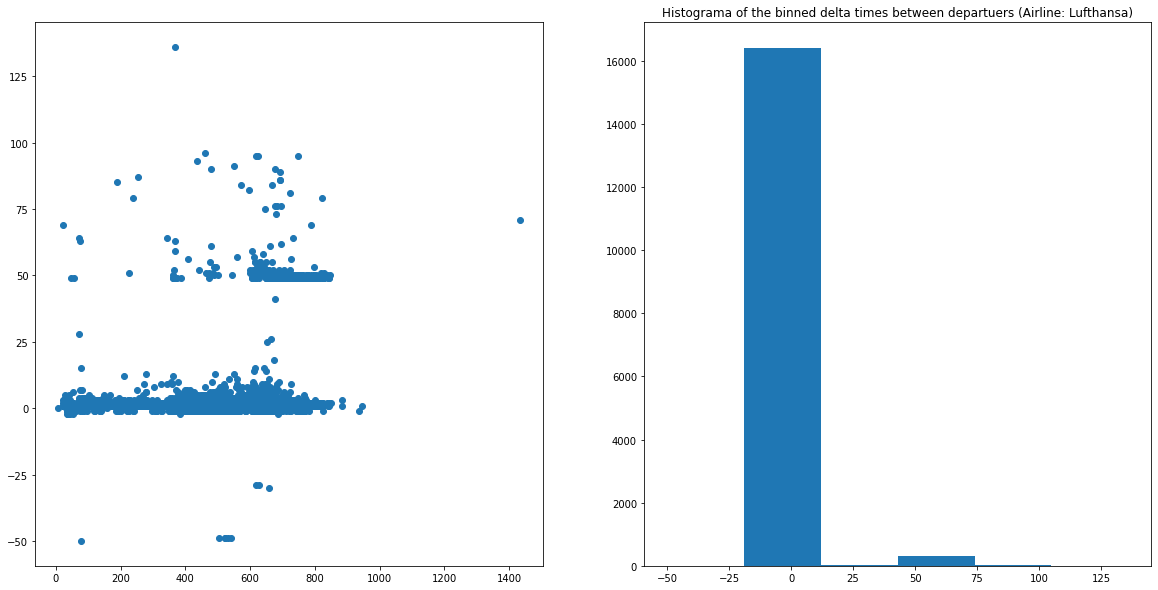

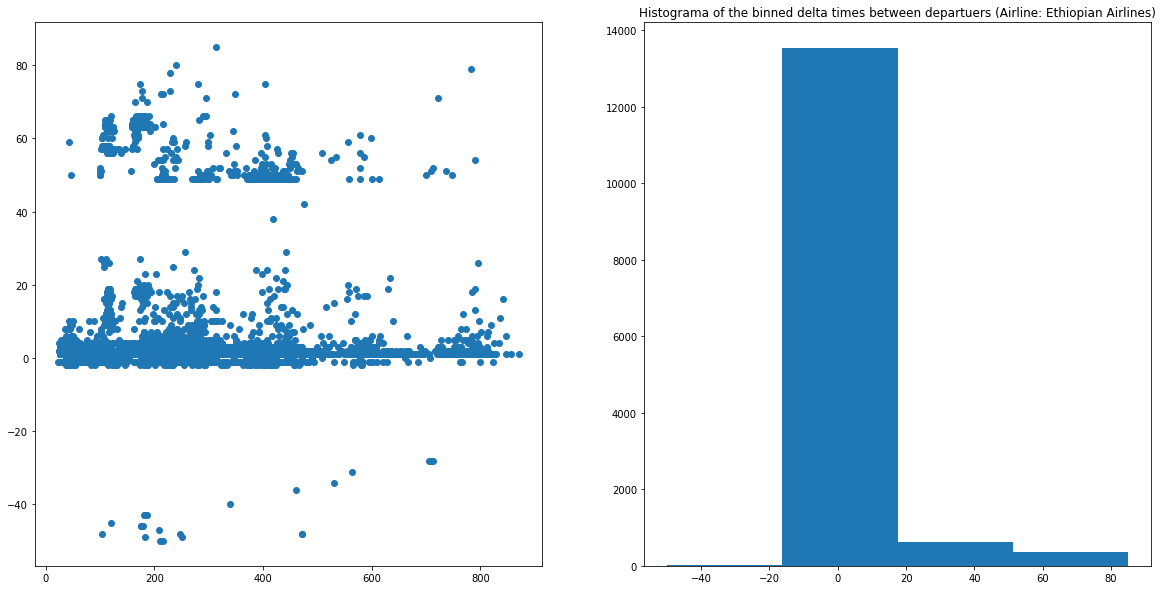

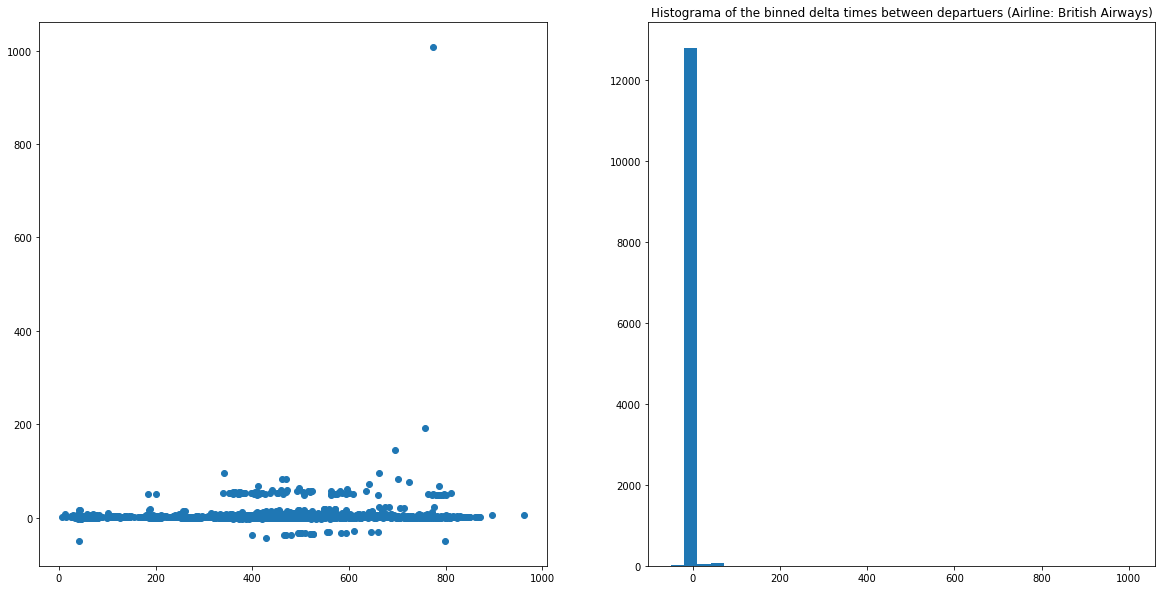

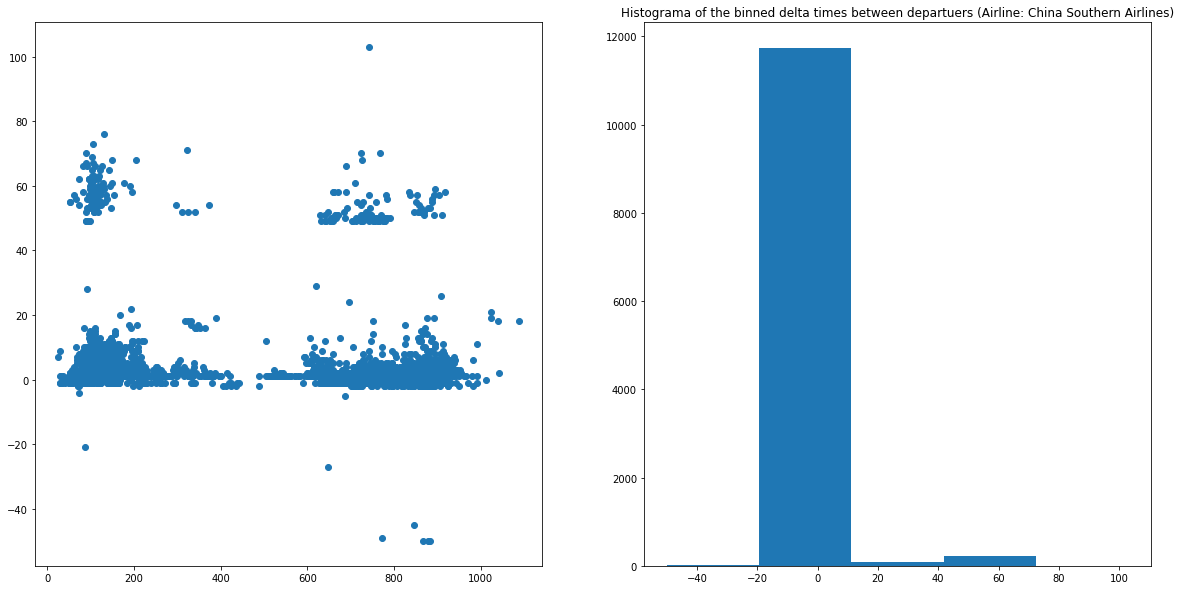

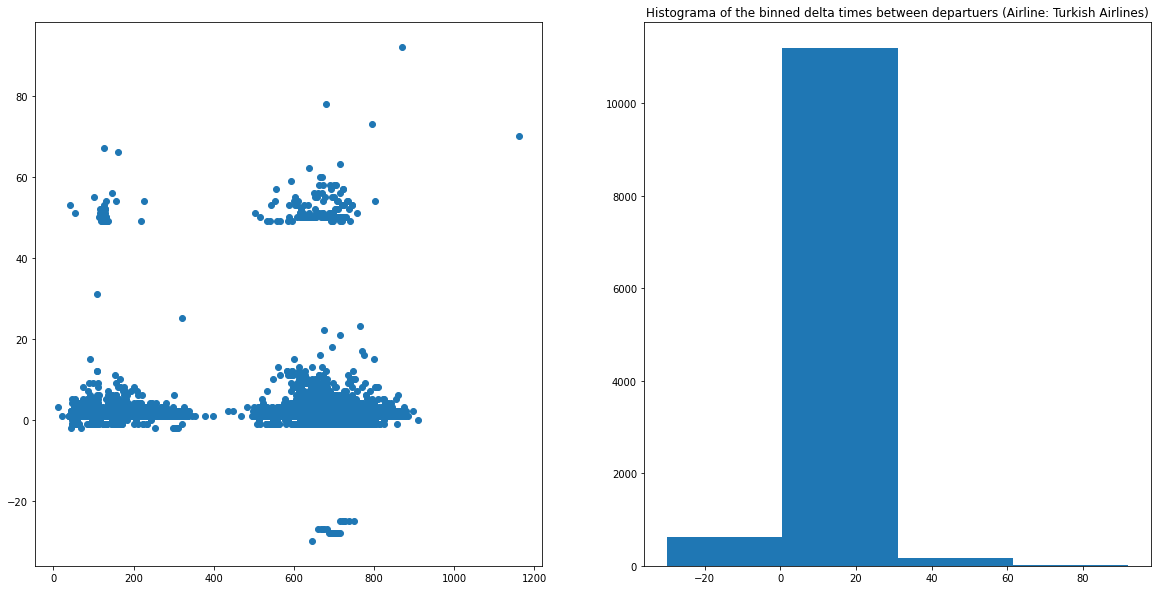

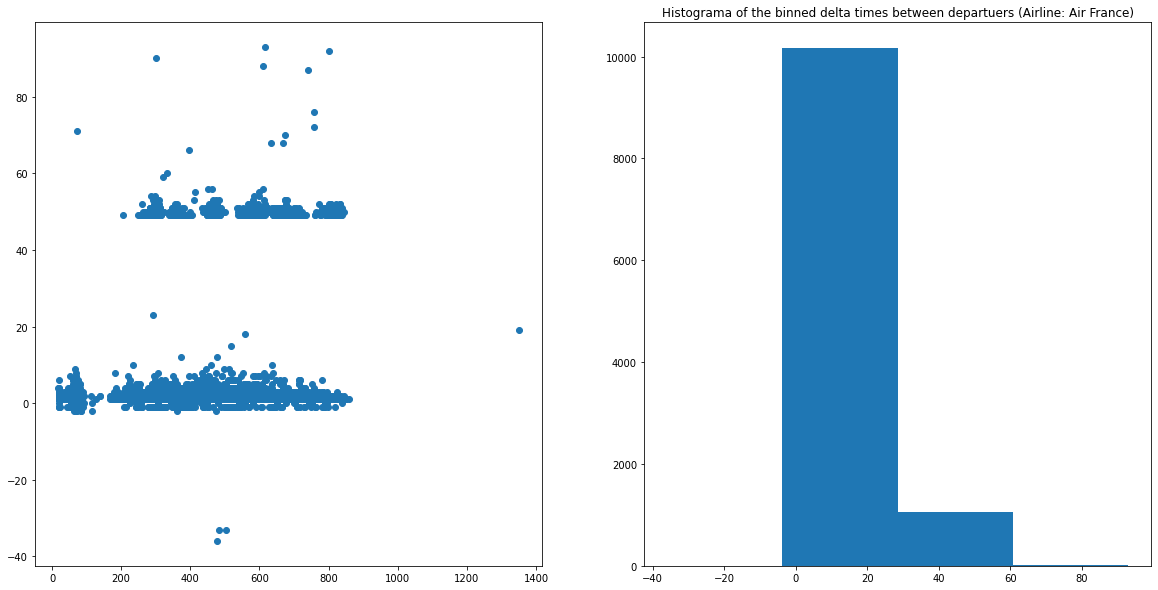

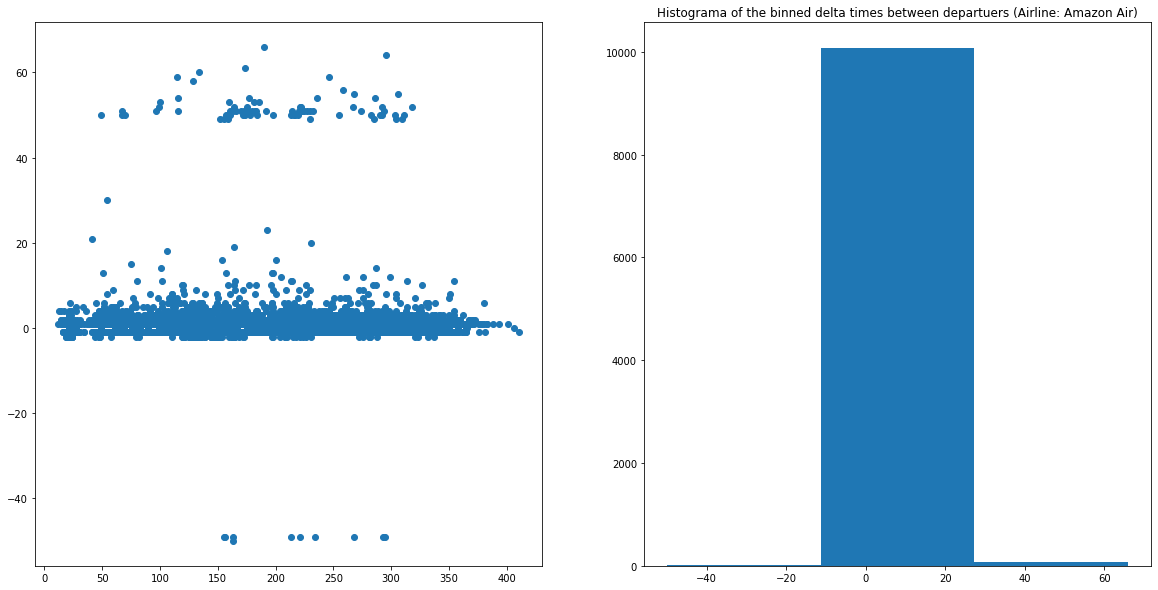

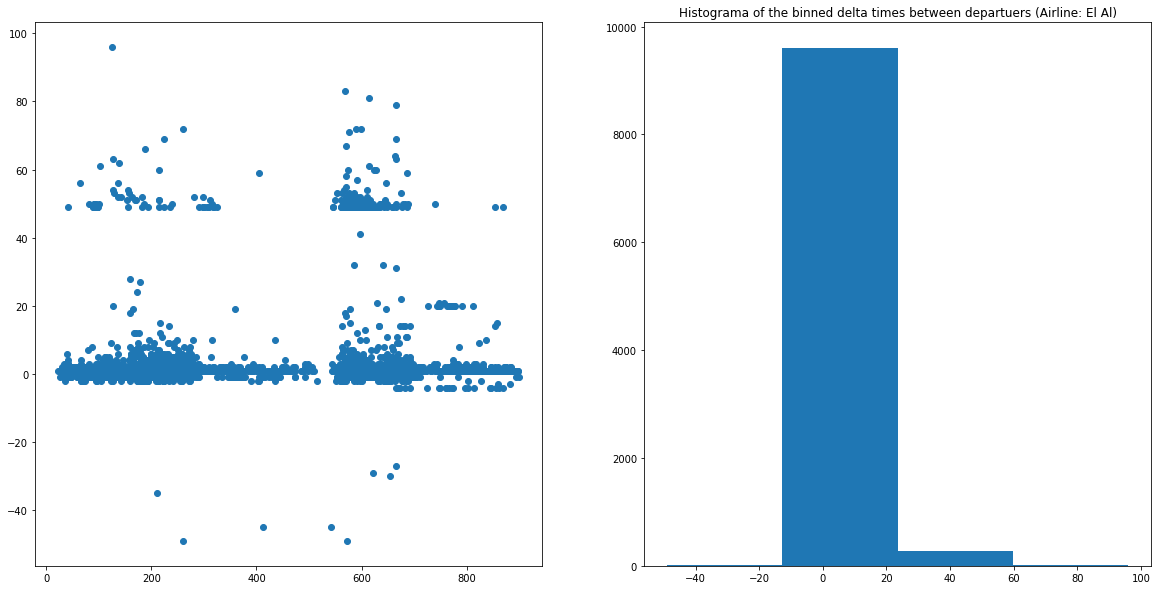

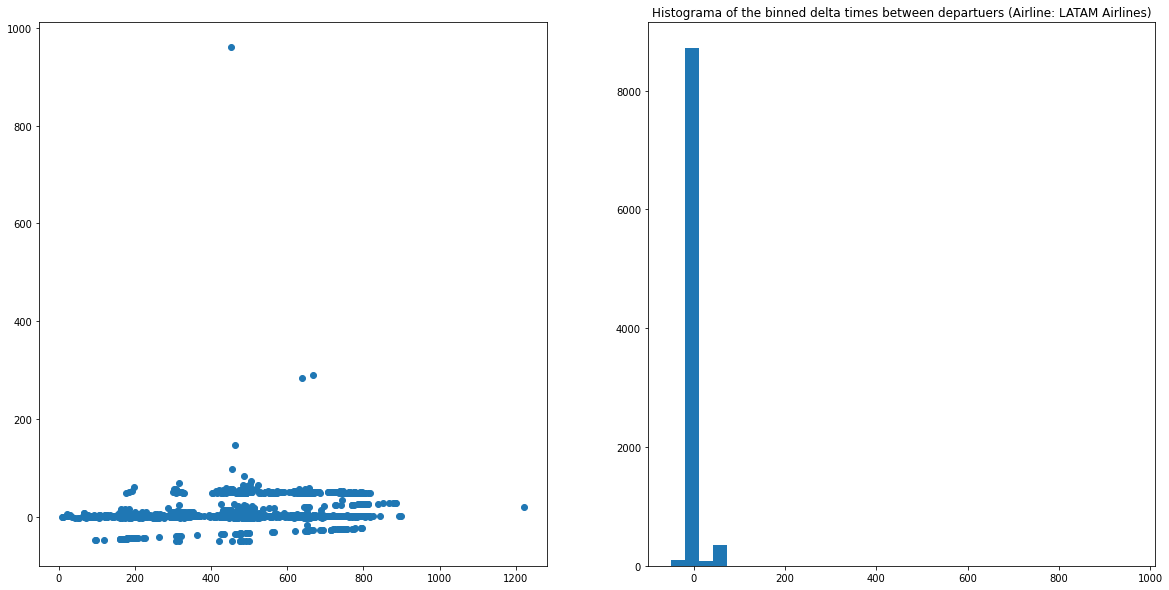

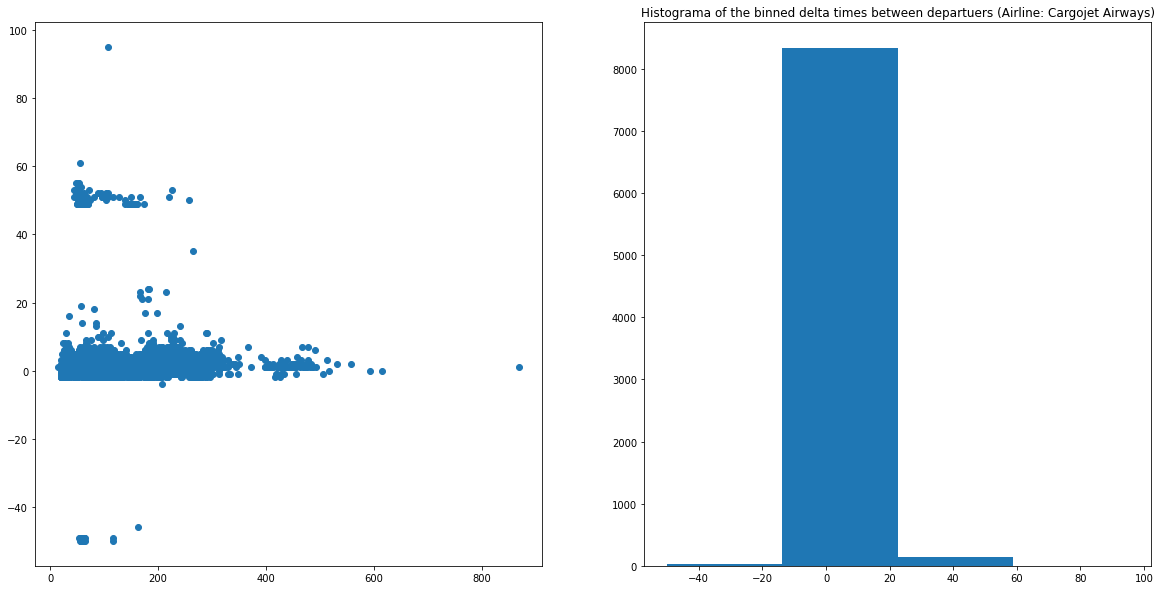

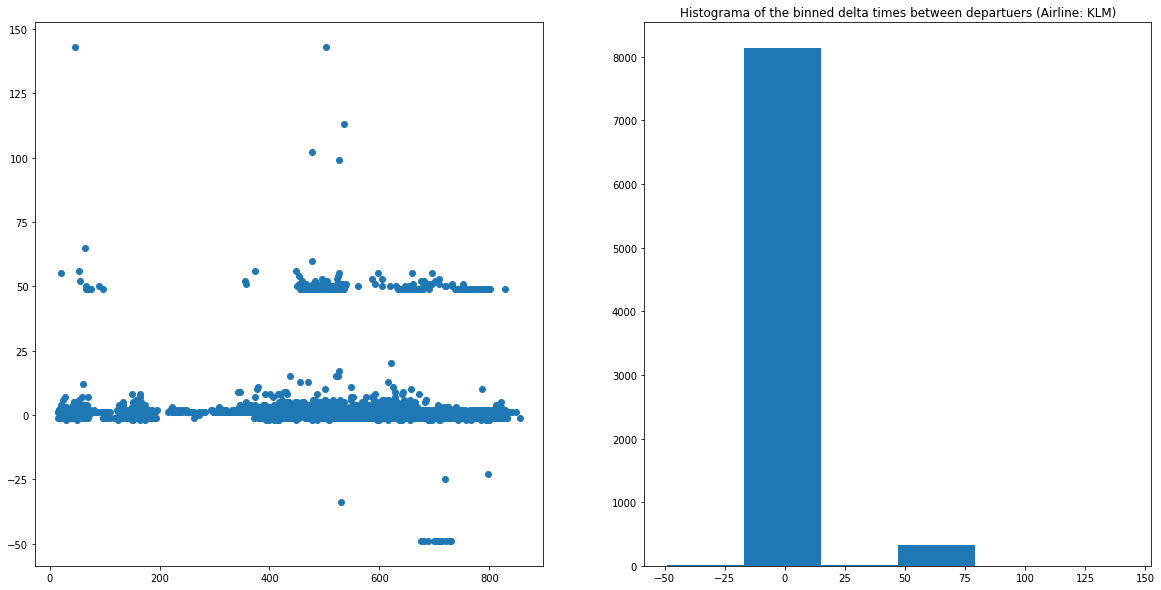

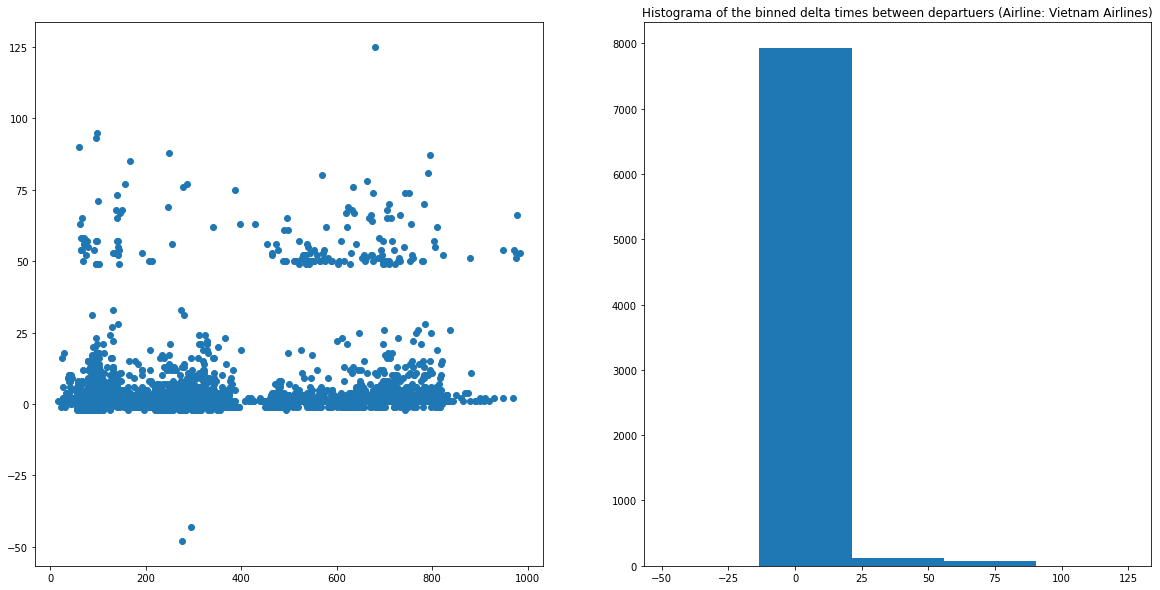

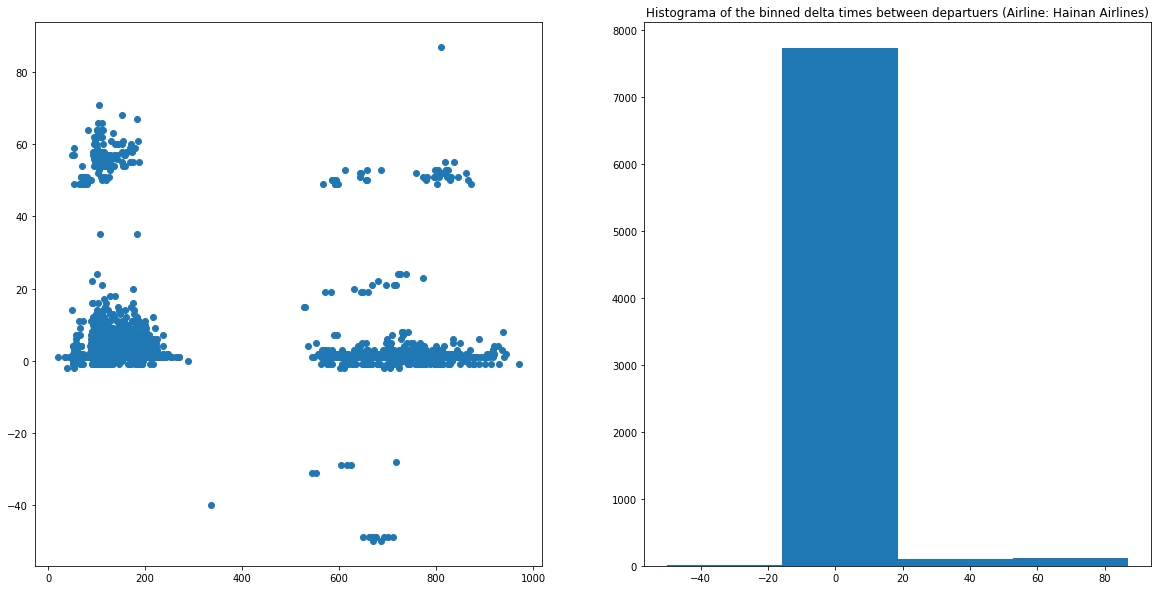

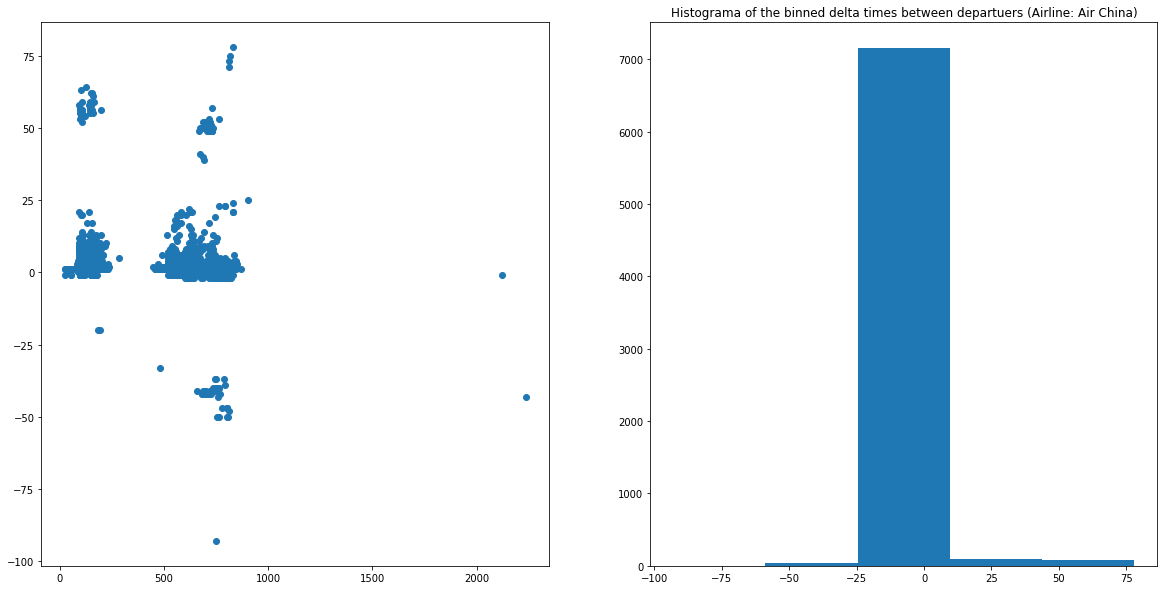

In [73]:
airlines = airlinesSortedByTraffic[:topToChoose]
airlinesDf = airlinesDf

airlinesDict = airlinesDf.to_dict(orient = "list")
keys = airlinesDict["Airline"]
values = airlinesDict["AirlineCode_scaled"]
airlinesDict = dict(zip(keys, values))

for airline in airlines:
    airlineCode = airlinesDict[airline]
    
    tempDf = linearDf[np.isclose(linearDf["Airline"], airlineCode)]
    deltas = tempDf["DeltaBetweenDepratures (Value)"].tolist()
    flightTimes = tempDf["FlightTime"].tolist()
    
    # Amount of earlies per airline
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    
    # deltas is y axis because this is the musbar variable
    sr_snaks = pd.Series(deltas, index = flightTimes)
    
    one_dim_plot(sr_snaks, 'scatter', axes[0], title = f"Affection of the flight time on the delta time between departuers (Airline: {airline})")
    
    minTime = tempDf["DeltaBetweenDepratures (Value)"].min()
    maxTime = tempDf["DeltaBetweenDepratures (Value)"].max()
    bins = int((abs(minTime) + abs(maxTime)) / 30)
    
    if bins == 0:
        bins = 1
    
    one_dim_plot(sr_snaks, 'hist', axes[1], title = f"Histograma of the binned delta times between departuers (Airline: {airline})")

    Second thing we want is to see is a correlation matrix of the different columns of the dataframe.

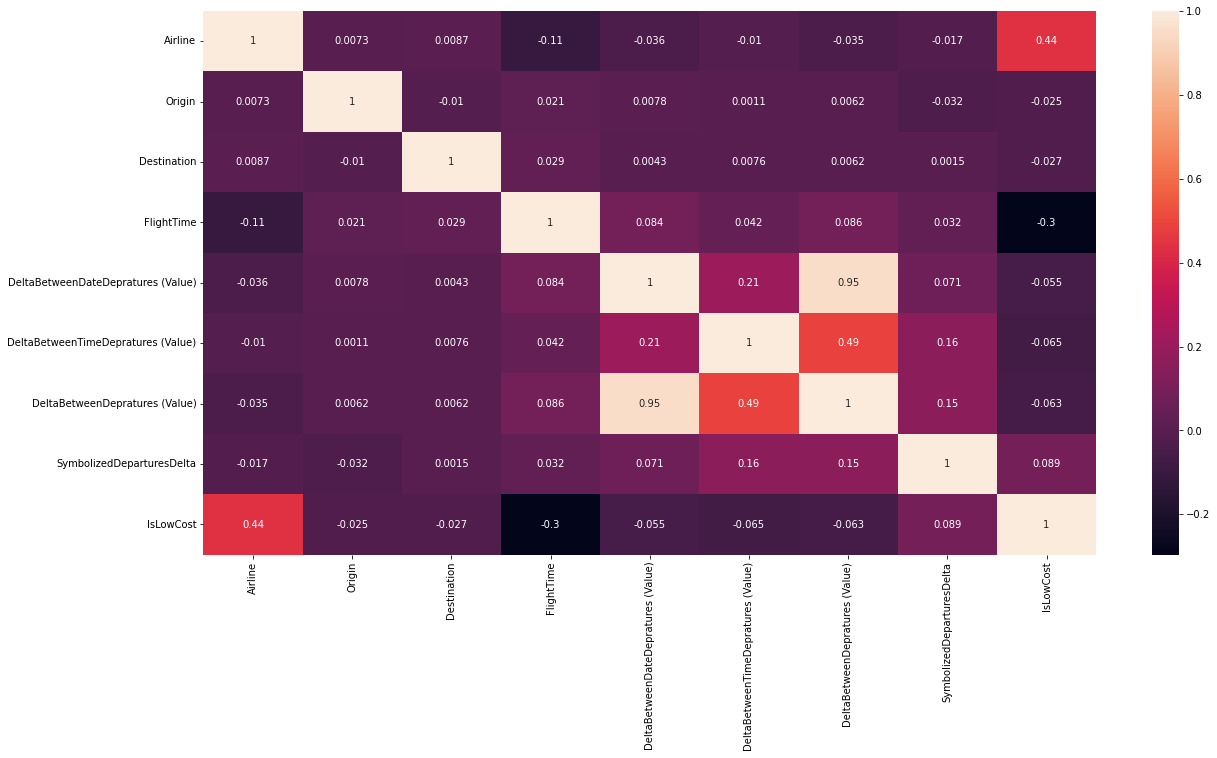

In [74]:
showCorrelationMatrix(linearDf, number_of_highly_correlated_to_display = None)

    As we can see there are columns with too high correlation: "DeltaBetweenDepartures (Value)" and "DeltaBetweenDateDepartures (Value)"
    That's why we need to remove one of them.
    Let's remove the column "DeltaBetweenDateDepartures (Value)" because "DeltaBetweenDepartures (Value)" is highly correlated with more columns, so it's better to keep it.

### Fitting The Dataset

In [75]:
get_properties_with_highest_correlations(linearDf, number_of_highest_values = 5)

{'Airline': [('Destination', 0.008740840396762555),
  ('Origin', 0.007347059716343506),
  ('DeltaBetweenDateDepratures (Value)', -0.03607255800035189),
  ('FlightTime', -0.10782093271619554)],
 'Origin': [('FlightTime', 0.021297223974367837),
  ('DeltaBetweenDateDepratures (Value)', 0.00778631280650391),
  ('Destination', -0.010090309583042608)],
 'Destination': [('FlightTime', 0.02943598896464875),
  ('DeltaBetweenDateDepratures (Value)', 0.004340166327736735)],
 'FlightTime': [('DeltaBetweenDateDepratures (Value)', 0.08374835611620786)]}

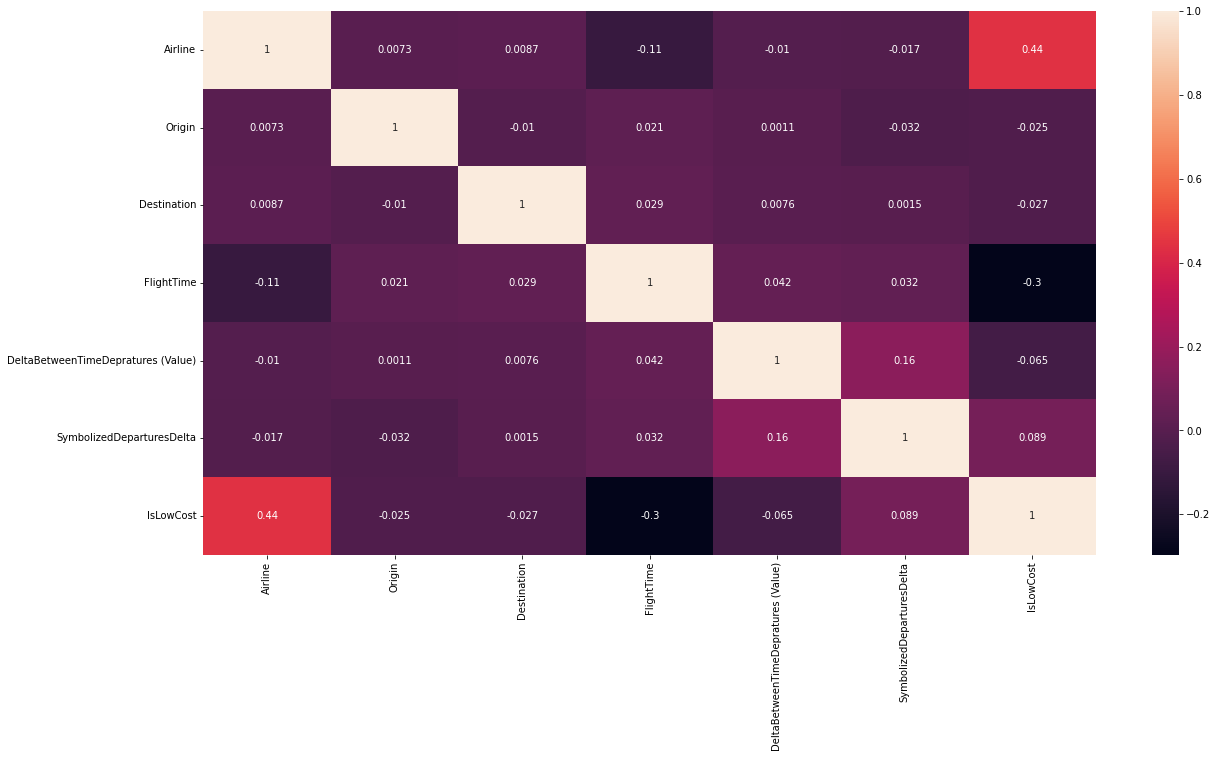

Slope: [-0.44684657  0.1886956   0.01283008  0.00234637  0.05221708  1.18497233
 -0.28570116]
Intercept: -0.6089795349396616
[ 2.35053004  1.76999518 -1.85218951 ...  0.77908796  4.38261161
  3.14841523]
R2: 0.2456782519020786


In [76]:
cols1 = [
"Airline",
"Origin",
"Destination",
"FlightTime",
# We removed this column due to high correlatuion with other columns
# "DeltaBetweenDateDepratures (Value)",
"DeltaBetweenTimeDepratures (Value)",
# We removed this column because this is the column which we want to predict
# "DeltaBetweenDepratures (Value)",
"SymbolizedDeparturesDelta",
"IsLowCost"]

showCorrelationMatrix(linearDf[cols1], number_of_highly_correlated_to_display = None)

X = linearDf[cols1]
y = linearDf['DeltaBetweenDepratures (Value)']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LinearRegression(fit_intercept = True) # create a linear regression object
clf.fit(X=xtrain, y=ytrain)
y_pred = clf.predict(xtest)

print("Slope:",clf.coef_)
print("Intercept:",clf.intercept_)
print(y_pred)
print("R2:",r2_score(ytest,y_pred))

    OK, We've got an r2 result of 0.245, which isn't good enough.
    We tried to improve this dataset in order to get higer results..
    The code below shows the last try which has been made:

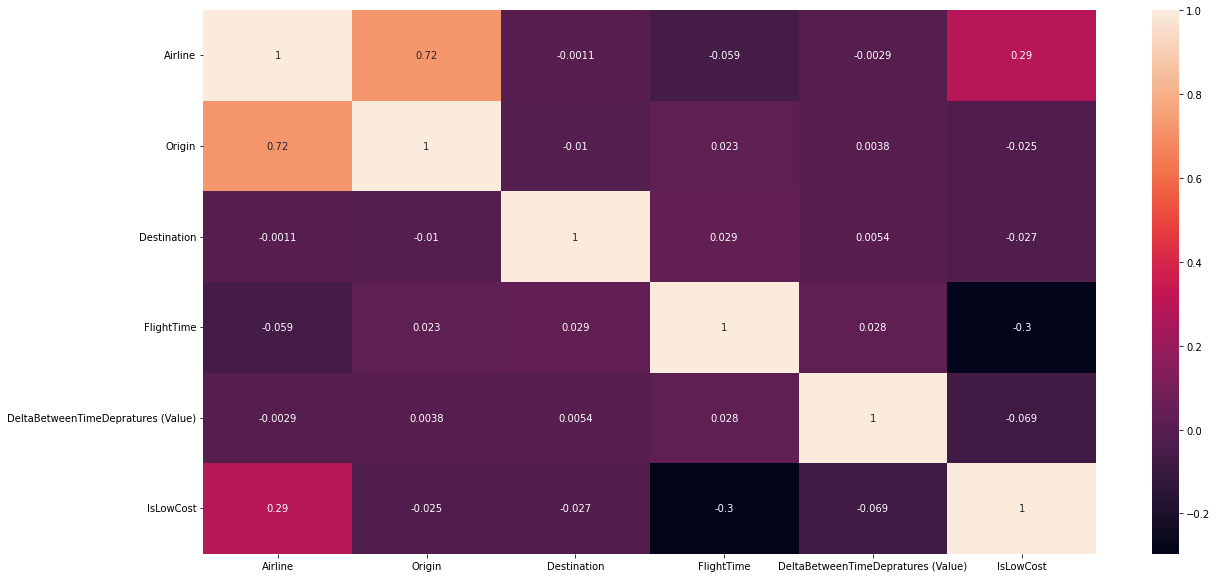

In [77]:
cols10 = [
"Airline",
"Origin",
"Destination",
"FlightTime",
# We removed this column due to high correlatuion with other columns
# "DeltaBetweenDateDepratures (Value)",
"DeltaBetweenTimeDepratures (Value)",
# We removed this column because this is the column which we want to predict
# "DeltaBetweenDepratures (Value)",
# "SymbolizedDeparturesDelta",
"IsLowCost"]

linearDf["Airline"] = linearDf["Airline"] + linearDf["Origin"]
linearDf["DeltaBetweenTimeDepratures (Value)"] = (linearDf["DeltaBetweenTimeDepratures (Value)"] * linearDf["SymbolizedDeparturesDelta"]) + linearDf["Origin"]
# linearDf["FlightTime_X_Airline"] = linearDf["FlightTime"] + linearDf["Airline"]
linearDf["FlightTime"] = linearDf["FlightTime"] + linearDf["Origin"]

showCorrelationMatrix(linearDf[cols10], number_of_highly_correlated_to_display = None)

In [78]:
X = linearDf[cols10]
y = linearDf['DeltaBetweenDepratures (Value)']

### Splitting The Dataset:

In [79]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

### Preparation Of The Model

In [80]:
clf = LinearRegression(fit_intercept = True) # create a linear regression object
clf.fit(X=xtrain, y=ytrain)

LinearRegression()

### Execution Of The Model

In [81]:
y_pred = clf.predict(xtest)

### Evaluation Of The Model

In [82]:
print("Slope:",clf.coef_)
print("Intercept:",clf.intercept_)
print(y_pred)
print("R2:",r2_score(ytest,y_pred))

Slope: [-0.72531946  0.80921213  0.04370139  0.0028779   0.05689572  0.08679351]
Intercept: 0.16778541937380176
[2.13987956 1.38981334 0.58238796 ... 0.35312216 4.14408368 2.88976318]
R2: 0.265179599099295


# Mission #8 - 2nd Machine Learning (Logistic Regression)
    The code in this section was used in order to try to answer the next question with usage of LogisticRegression model:
    
<blockquote>If details of new flight are being given to us - <b>Is the flight is LowCost flight or not?</b></blockquote>

In [83]:
from sklearn import *

### Pre-Execution Visualization
    First, we want to see the percentage of lowcost and not-lowcost flights which are in the dataset.

In [84]:
def get_percentage_of_lowcost_flights(inputDf):
    """
    add_symbolized_departures_delta()
    
    Purpose:
        This method is responsible to retrieve a list with the percentages of lowcost and not-lowcost flights which in the DataFrame

    Parameters:
        [pd.DataFrame] inputDf - The input DataFrame object to work on

    Return Value:
        [list] percentages     - The list with the percentages of lowcost and not-lowcost flights
    """

    # Count the total number of flights
    totalNumberOfFlights = len(inputDf)

    # Count the number of flights for each airline
    sumOfLowCostFlights = inputDf["IsLowCost"].value_counts().values.tolist()

    percentages = [round(100 * (float(value) / totalNumberOfFlights), 2) for value in sumOfLowCostFlights]
    print(percentages)

    return percentages

[78.24, 21.76]


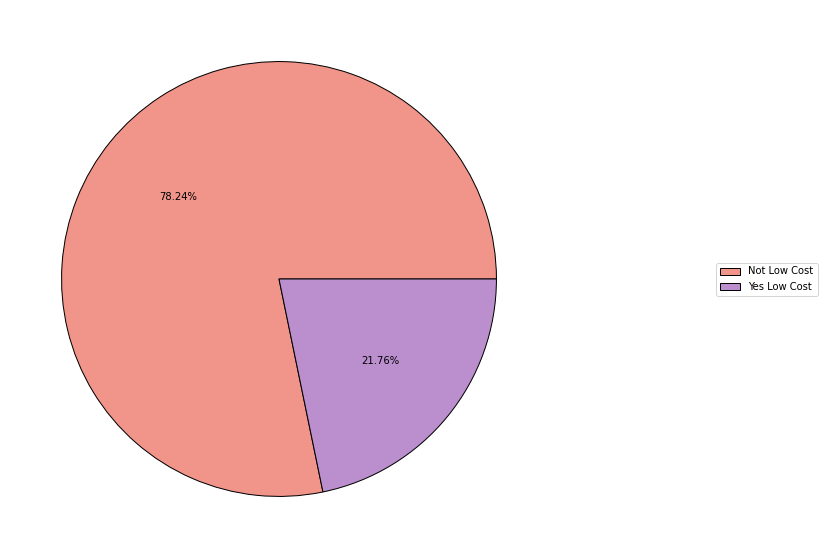

In [85]:
perLowCostFlights = get_percentage_of_lowcost_flights(logisticDf)

fig, axes = plt.subplots(1, figsize=(20,10))
srPercentageOfLowCostFlights = pd.Series(perLowCostFlights , index=['Not Low Cost', 'Yes Low Cost'])
one_dim_plot(srPercentageOfLowCostFlights, 'pie', axes)

    We can see that the number of lowcost flights is not equal to the number of not-lowcost flights.
    Therefore we need to make them even, which means - to remove some not-lowcost flights in order to have an equal number.

In [86]:
lowcostDf = logisticDf[logisticDf["IsLowCost"] == 1]
numberOfLowcostFlights = len(lowcostDf)
print(numberOfLowcostFlights)

325469


In [87]:
notlowcostDf = logisticDf[logisticDf["IsLowCost"] == 0]
numberOfNotLowcostFlights = len(notlowcostDf)
print(numberOfNotLowcostFlights)

1170145


In [88]:
logisticDf2 = pd.concat([lowcostDf, notlowcostDf.iloc[:numberOfLowcostFlights, :]])
logisticDf2

,Airline,Origin,Destination,FlightTime,DeltaBetweenDateDepratures (Symbol),DeltaBetweenTimeDepratures (Symbol),SymbolizedDeparturesDelta,DeltaBetweenDepratures (Value),IsLowCost
8612,139,205,634,502,0,1,1,1.0,1
19855,139,599,634,688,0,1,1,44.0,1
19856,139,634,599,702,0,1,1,17.0,1
19857,139,415,634,636,0,1,1,19.0,1
19858,139,907,415,41,0,1,1,7.0,1
...,...,...,...,...,...,...,...,...,...
385421,66,966,618,298,0,1,1,74.0,0
385422,66,618,966,260,1,1,1,1563.0,0
385423,66,942,618,57,0,1,1,87.0,0
385424,66,948,942,89,0,1,1,45.0,0


In [89]:
print(len(logisticDf2[logisticDf2["IsLowCost"] == 0]))
print(len(logisticDf2[logisticDf2["IsLowCost"] == 1]))

logisticDf2 = logisticDf2.reset_index(drop = True)
logisticDf2

325469
325469


,Airline,Origin,Destination,FlightTime,DeltaBetweenDateDepratures (Symbol),DeltaBetweenTimeDepratures (Symbol),SymbolizedDeparturesDelta,DeltaBetweenDepratures (Value),IsLowCost
0,139,205,634,502,0,1,1,1.0,1
1,139,599,634,688,0,1,1,44.0,1
2,139,634,599,702,0,1,1,17.0,1
3,139,415,634,636,0,1,1,19.0,1
4,139,907,415,41,0,1,1,7.0,1
...,...,...,...,...,...,...,...,...,...
650933,66,966,618,298,0,1,1,74.0,0
650934,66,618,966,260,1,1,1,1563.0,0
650935,66,942,618,57,0,1,1,87.0,0
650936,66,948,942,89,0,1,1,45.0,0


### Fitting The Dataset

In [90]:
logisticDf3 = logisticDf2.drop('Airline',axis=1,inplace=False)
logisticDf3

,Origin,Destination,FlightTime,DeltaBetweenDateDepratures (Symbol),DeltaBetweenTimeDepratures (Symbol),SymbolizedDeparturesDelta,DeltaBetweenDepratures (Value),IsLowCost
0,205,634,502,0,1,1,1.0,1
1,599,634,688,0,1,1,44.0,1
2,634,599,702,0,1,1,17.0,1
3,415,634,636,0,1,1,19.0,1
4,907,415,41,0,1,1,7.0,1
...,...,...,...,...,...,...,...,...
650933,966,618,298,0,1,1,74.0,0
650934,618,966,260,1,1,1,1563.0,0
650935,942,618,57,0,1,1,87.0,0
650936,948,942,89,0,1,1,45.0,0


### Splitting The Dataset:

In [91]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(logisticDf3.drop('IsLowCost', axis=1), logisticDf3['IsLowCost'],random_state = 0)

### Preparation Of The Model

In [92]:
clf1 = linear_model.LogisticRegression()
clf1.fit(xtrain1,ytrain1)

LogisticRegression()

### Execution Of The Model

In [93]:
y_pred1 = clf1.predict(xtest1)

### Evaluation Of The Model

In [94]:
metrics.confusion_matrix(ytest1, y_pred1)

print("accuracy is:",metrics.accuracy_score(ytest1, y_pred1))
print("precision is:",metrics.precision_score(ytest1, y_pred1))
print("recall is:",metrics.recall_score(ytest1, y_pred1))
print("f1 is:",metrics.f1_score(ytest1, y_pred1))

accuracy is: 0.7405598058192767
precision is: 0.6933994899875462
recall is: 0.8623300636723455
f1 is: 0.7686930224403928


    We've got very high scores !!!
<b> #WOW_EFFECT </b>

    Let's how the results in DataFrame:

In [95]:
y_pred_fortbl = clf1.predict(xtest1)
resDF=pd.DataFrame({"Actual":ytest1,"Predicted":y_pred_fortbl})
resDF["correct"]=abs((resDF["Actual"]^resDF["Predicted"])-1)
resDF[resDF["correct"]==1]

,Actual,Predicted,correct
51288,1,1,1
13912,1,1,1
101054,1,1,1
283349,1,1,1
203126,1,1,1
...,...,...,...
473493,0,0,1
13593,1,1,1
17098,1,1,1
19044,1,1,1


    How good the model is? Let's try it ourselves.
    Let's insert the next parameters of a single (Not LowCost) flight:

In [96]:
lst_expi1 =[[800,604,400,0,0,0,0]]
clos_of_testing = list(logisticDf3.columns)
clos_of_testing.remove('IsLowCost')
df_testing = pd.DataFrame(lst_expi1, columns = clos_of_testing)
print(clf1.predict(df_testing))

[0]


But we can do more than that !
Now let's challenge ourselves and let's create a model which doesn't take into account the "FlightTime" column.
<b> It means that we will give the new model details of a flight which is currently in progress (not landed yet).</b>

<b> #SUPER_WOW_EFFECT </b>

In [97]:
logisticDf4 = logisticDf2.drop(['Airline','FlightTime'], axis=1, inplace=False)

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(logisticDf4.drop('IsLowCost', axis=1), logisticDf4['IsLowCost'], random_state = 0)

clf2=linear_model.LogisticRegression()
clf2.fit(xtrain2,ytrain2)
acc2=clf2.score(xtest2,ytest2)

print(f"accuracy is {acc2}")

accuracy is 0.5632531416105939


<b> WOWWWWW, THIS IS A STRONG MESSAGE ! </b>
<br>
We can actually predict if a flight is lowcost or not, even if it is now in the air !
<br>
Let's try it on a single flight :)

In [98]:
lst_expi2 =[[800,604,0,0,0,0]]
clos_of_testing2 = list(logisticDf4.columns)

clos_of_testing2.remove('IsLowCost')

df_testing2 = pd.DataFrame(lst_expi2, columns = clos_of_testing2)
print(clf2.predict(df_testing2))

[0]


# Mission #9 - 3rd Machine Learning (Clustering)
    The code in this section was used in order to cluster the flight using a Clustering model.
    We chose for this Mission the KMeans Clustering Model.

### Preparation, Execution & Evaluation Of The Model

<p>
We chose to run the clustering model from 3 to 15 because we thought that 15 is enough clusters and a higher value won't give us a better result.
In addition, we chose the "random_state" parameter to be 42 after we tried different values.
Moreover, the value 42 has been recommended by the official documentation of sklearn (Source: <a> href="https://scikit-learn.org/stable/glossary.html#term-random_state">https://scikit-learn.org/stable/glossary.html#term-random_state</a>)
</p>

For n_clusters = 3 The silhouette_score is : 0.30498161590436756


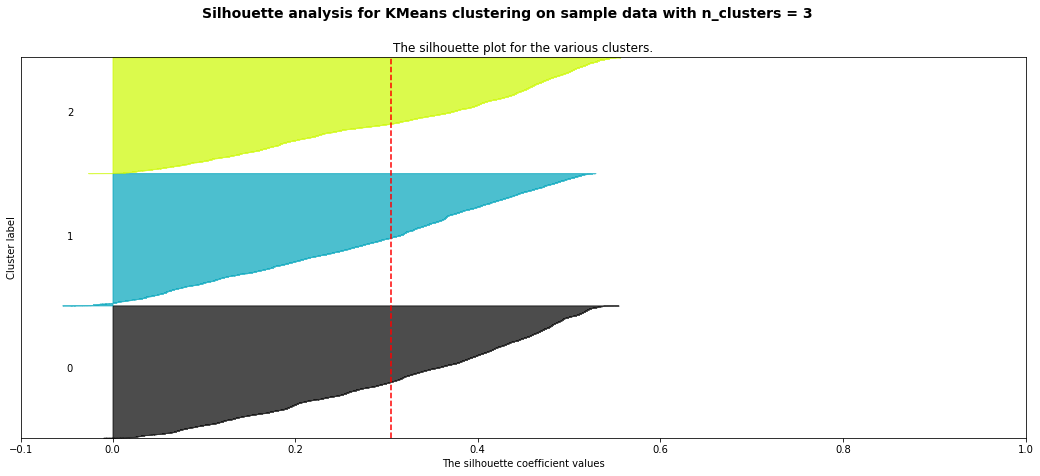

For n_clusters = 4 The silhouette_score is : 0.32675536846199693


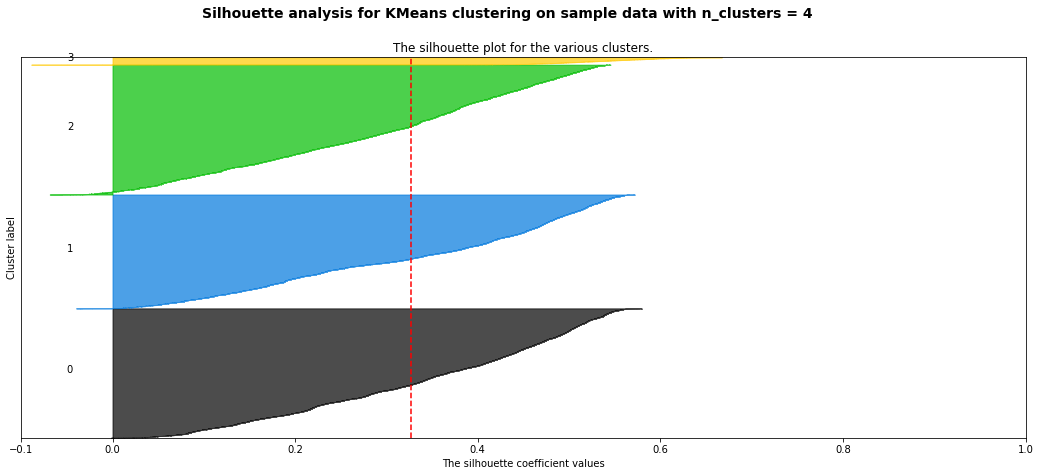

For n_clusters = 5 The silhouette_score is : 0.3341827676374635


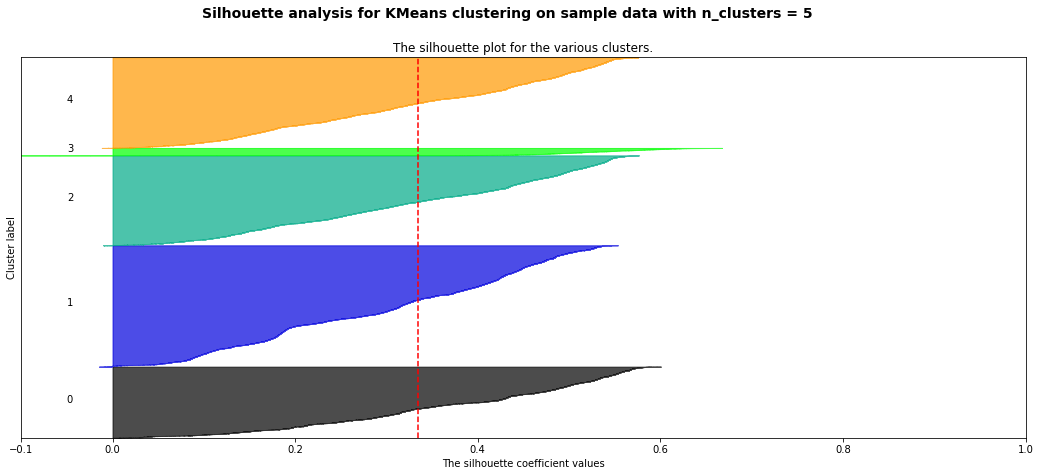

For n_clusters = 6 The silhouette_score is : 0.34158148483715006


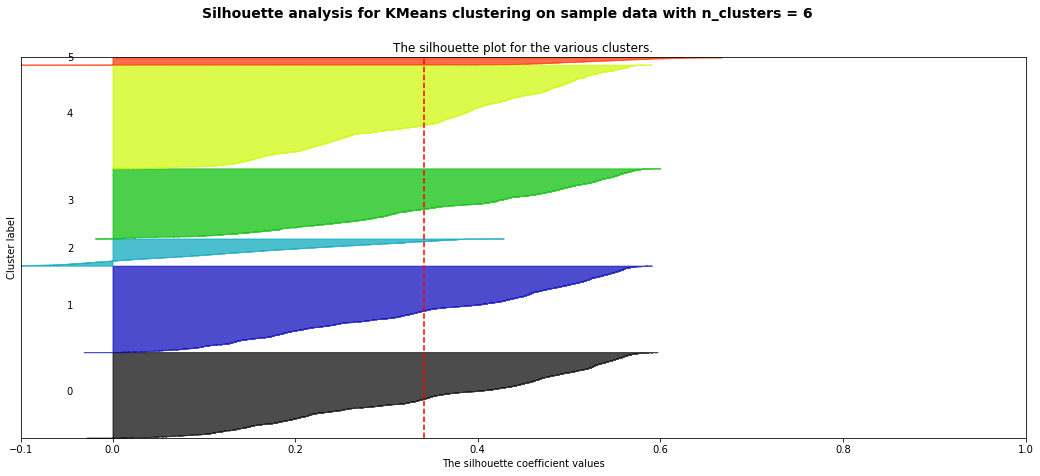

For n_clusters = 7 The silhouette_score is : 0.3047234943006806


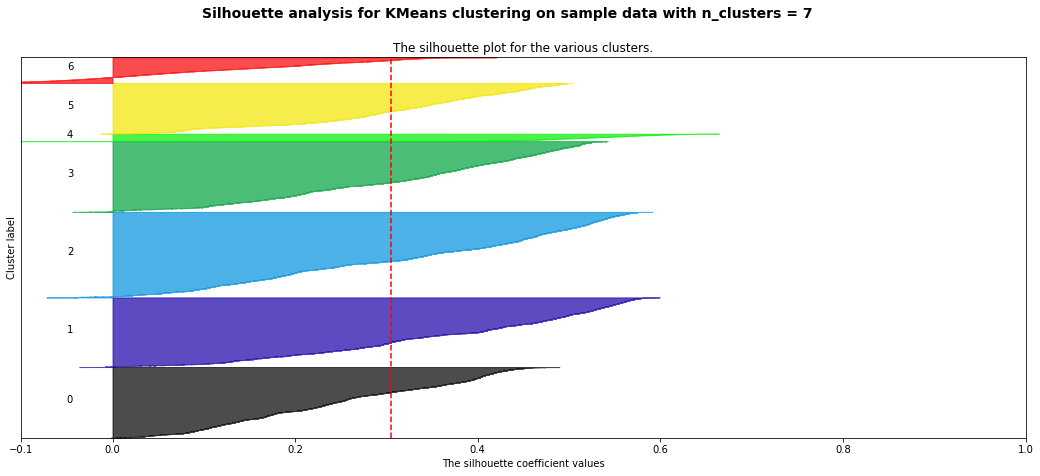

For n_clusters = 8 The silhouette_score is : 0.29874182514797115


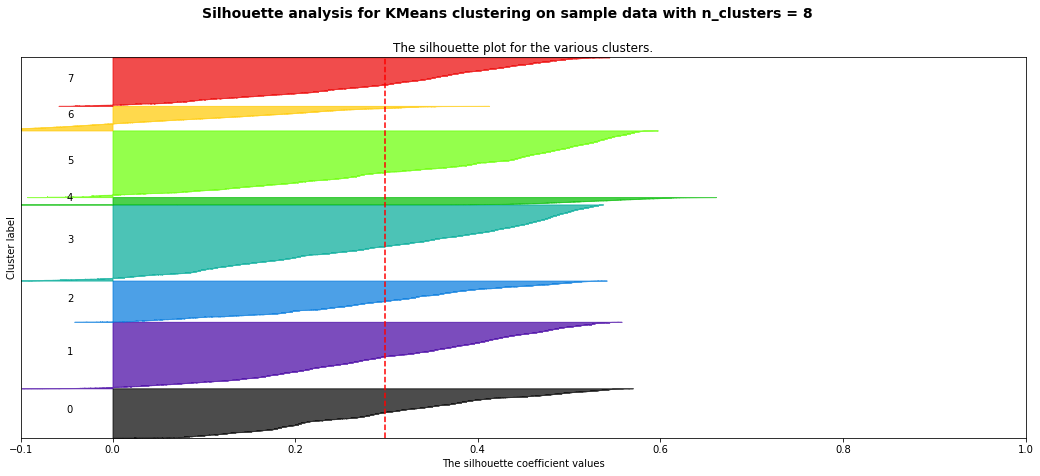

For n_clusters = 9 The silhouette_score is : 0.28240967238409515


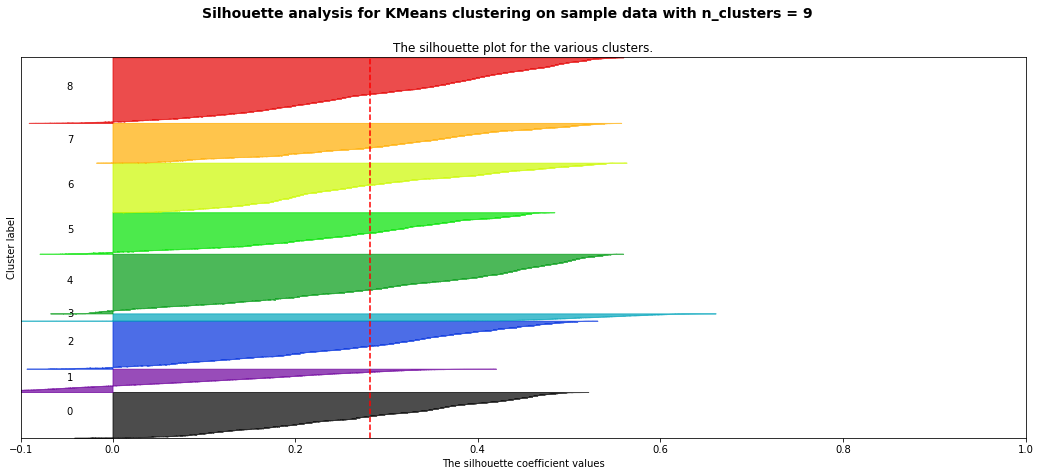

For n_clusters = 10 The silhouette_score is : 0.27533489294061037


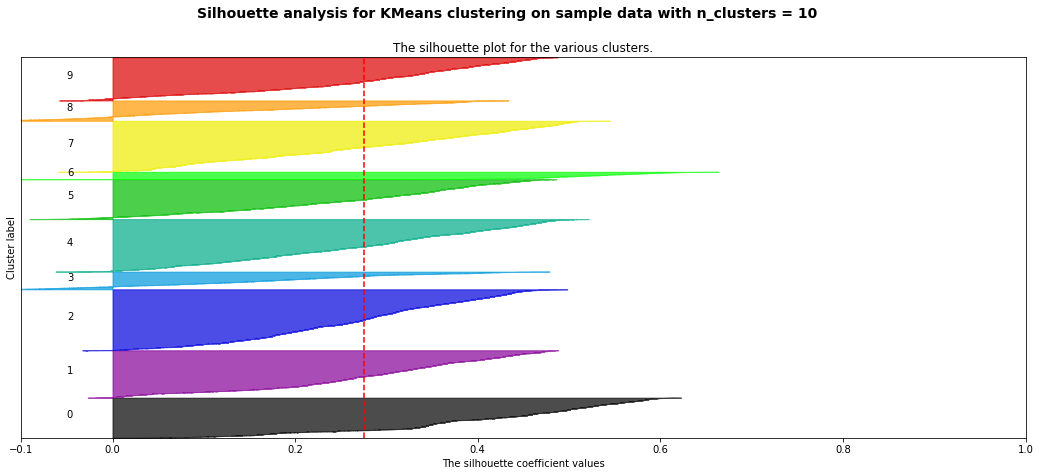

For n_clusters = 11 The silhouette_score is : 0.2977787303056789


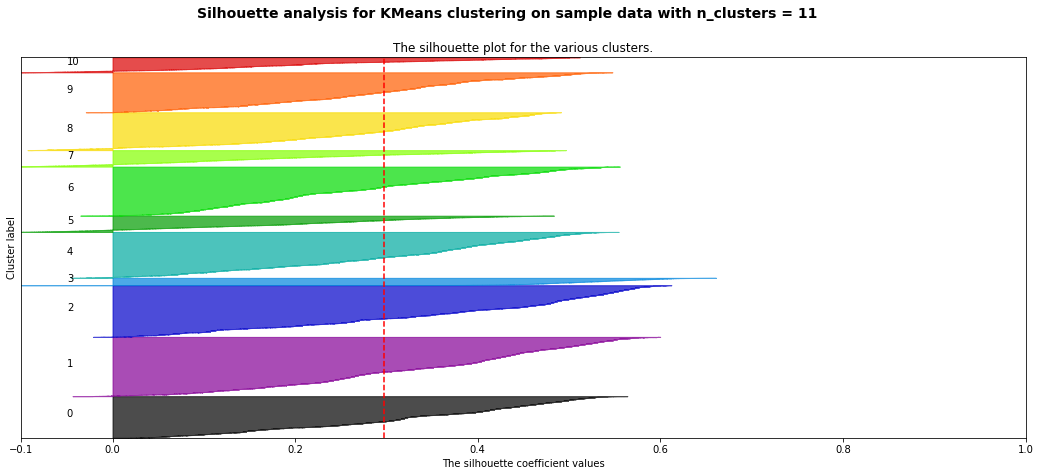

For n_clusters = 12 The silhouette_score is : 0.2823124675629631


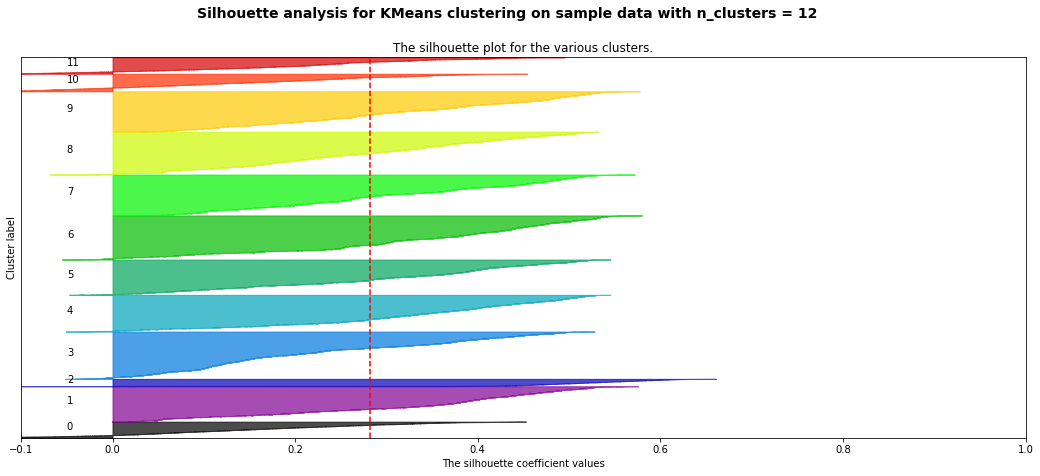

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

range_n_clusters = range(3,15)
scores=[]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clusteringDf) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',random_state=42)
    cluster_labels = clusterer.fit_predict(clusteringDf)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(clusteringDf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The silhouette_score is :", silhouette_avg)
    scores.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clusteringDf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette coefficient of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

As we can see, the best clustering which we're getting is for the value: 6 of n_clusters